# Data Analysis - Final Project
## Team: Analog Avengers

**Dataset:** Bike Sales Data (113,037 transactions)

Selected for time-series analysis because:
- Spans 2011-2016 (multiple years for trend analysis)
- 113,037 data points (exceeds 50,000 minimum)
- Contains dates for daily aggregation
- Financial metrics: Revenue, Profit, Cost

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
#Section C
import math
from scipy import stats
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
def banner(banner_text: str):
    print('='*80)
    print(banner_text)
    print('='*80)

# Task A: Data Preprocessing and Data Quality (70 points)

## A.1 Dataset Overview (10 points)

In [2]:
# 1) Load dataset
df = pd.read_csv('BikeSales/Sales.csv')

print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"Total data points: {df.shape[0] * df.shape[1]}")

df.head()

Shape: 113036 rows x 18 columns
Total data points: 2034648


Date  Day     Month  Year  Customer_Age       Age_Group  \
0  2013-11-26   26  November  2013            19     Youth (<25)   
1  2015-11-26   26  November  2015            19     Youth (<25)   
2  2014-03-23   23     March  2014            49  Adults (35-64)   
3  2016-03-23   23     March  2016            49  Adults (35-64)   
4  2014-05-15   15       May  2014            47  Adults (35-64)   

  Customer_Gender    Country             State Product_Category Sub_Category  \
0               M     Canada  British Columbia      Accessories   Bike Racks   
1               M     Canada  British Columbia      Accessories   Bike Racks   
2               M  Australia   New South Wales      Accessories   Bike Racks   
3               M  Australia   New South Wales      Accessories   Bike Racks   
4               F  Australia   New South Wales      Accessories   Bike Racks   

               Product  Order_Quantity  Unit_Cost  Unit_Price  Profit  Cost  \
0  Hitch Rack - 4-Bike               8         45         120     590   360   
1  Hitch Rack - 4-Bike               8         45         120     590   360   
2  Hitch Rack - 4-Bike              23         45         120    1366  1035   
3  Hitch Rack - 4-Bike              20         45         120    1188   900   
4  Hitch Rack - 4-Bike               4         45         120     238   180   

   Revenue  
0      950  
1      950  
2     2401  
3     2088  
4      418

In [3]:
# 2) Check data types
print("Column types:")
print(df.dtypes)
print("\n")
df.info()

Column types:
Date                object
Day                  int64
Month               object
Year                 int64
Customer_Age         int64
Age_Group           object
Customer_Gender     object
Country             object
State               object
Product_Category    object
Sub_Category        object
Product             object
Order_Quantity       int64
Unit_Cost            int64
Unit_Price           int64
Profit               int64
Cost                 int64
Revenue              int64
dtype: object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113036 entries, 0 to 113035
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Date              113036 non-null  object
 1   Day               113036 non-null  int64 
 2   Month             113036 non-null  object
 3   Year              113036 non-null  int64 
 4   Customer_Age      113036 non-null  int64 
 5   Age_Group         113036 non-null  obje

In [4]:
# 3) Time range and sampling analysis
df['Date'] = pd.to_datetime(df['Date'])

print(f"Start: {df['Date'].min()}")
print(f"End: {df['Date'].max()}")
print(f"Span: {(df['Date'].max() - df['Date'].min()).days} days")
print(f"Years: {sorted(df['Year'].unique())}")

# Sampling rate
transactions_per_day = df.groupby('Date').size()
print(f"\nUnique dates: {df['Date'].nunique()}")
print(f"Avg transactions/day: {transactions_per_day.mean():.1f}")
print(f"Min/Max transactions per day: {transactions_per_day.min()} / {transactions_per_day.max()}")

# Check for gaps
missing_dates = (df['Date'].max() - df['Date'].min()).days - df['Date'].nunique()
print(f"Missing dates: {missing_dates}")

Start: 2011-01-01 00:00:00
End: 2016-07-31 00:00:00
Span: 2038 days
Years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016)]

Unique dates: 1884
Avg transactions/day: 60.0
Min/Max transactions per day: 1 / 288
Missing dates: 154


In [5]:
# 4) Missing values check
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "None - dataset is complete")
print(f"\nCompleteness: {(1 - df.isnull().sum().sum() / df.size) * 100:.1f}%")

Missing values per column:
None - dataset is complete

Completeness: 100.0%


## A.2 Basic Statistical Analysis (10 points)

In [6]:
# Descriptive statistics
numeric_cols = ['Customer_Age', 'Order_Quantity', 'Unit_Cost', 'Unit_Price', 'Profit', 'Cost', 'Revenue']
df[numeric_cols].describe().round(2)

Customer_Age  Order_Quantity  Unit_Cost  Unit_Price     Profit  \
count     113036.00       113036.00  113036.00   113036.00  113036.00   
mean          35.92           11.90     267.30      452.94     285.05   
std           11.02            9.56     549.84      922.07     453.89   
min           17.00            1.00       1.00        2.00     -30.00   
25%           28.00            2.00       2.00        5.00      29.00   
50%           35.00           10.00       9.00       24.00     101.00   
75%           43.00           20.00      42.00       70.00     358.00   
max           87.00           32.00    2171.00     3578.00   15096.00   

            Cost    Revenue  
count  113036.00  113036.00  
mean      469.32     754.37  
std       884.87    1309.09  
min         1.00       2.00  
25%        28.00      63.00  
50%       108.00     223.00  
75%       432.00     800.00  
max     42978.00   58074.00

In [7]:
# Grouped stats by Country
country_stats = df.groupby('Country').agg({
    'Revenue': ['sum', 'mean', 'count'],
    'Profit': ['sum', 'mean'],
    'Order_Quantity': ['sum', 'mean']
}).round(2)
country_stats.columns = ['_'.join(col) for col in country_stats.columns]
country_stats.sort_values('Revenue_sum', ascending=False)

Revenue_sum  Revenue_mean  Revenue_count  Profit_sum  \
Country                                                                
United States      27975547        713.55          39206    11073644   
Australia          21302059        889.96          23936     6776030   
United Kingdom     10646196        781.66          13620     4413853   
Germany             8978596        809.03          11098     3359995   
France              8432872        766.76          10998     2880282   
Canada              7935738        559.72          14178     3717296   

                Profit_mean  Order_Quantity_sum  Order_Quantity_mean  
Country                                                               
United States        282.45              477539                12.18  
Australia            283.09              263585                11.01  
United Kingdom       324.07              157218                11.54  
Germany              302.76              125720                11.33  
France               261.89              128995                11.73  
Canada               262.19              192259                13.56

In [8]:
# Grouped stats by Product Category
cat_stats = df.groupby('Product_Category').agg({
    'Revenue': ['sum', 'mean', 'count'],
    'Profit': ['sum', 'mean']
}).round(2)
cat_stats.columns = ['_'.join(col) for col in cat_stats.columns]
cat_stats.sort_values('Revenue_sum', ascending=False)

Revenue_sum  Revenue_mean  Revenue_count  Profit_sum  \
Product_Category                                                         
Bikes                61782134       2377.88          25982    20519276   
Accessories          15117992        215.60          70120     8862377   
Clothing              8370882        494.32          16934     2839447   

                  Profit_mean  
Product_Category               
Bikes                  789.75  
Accessories            126.39  
Clothing               167.68

In [9]:
#FIXME: Do we need this cell?

# Quantile analysis
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
financial_cols = ['Revenue', 'Profit', 'Cost', 'Order_Quantity']

q_df = df[financial_cols].quantile(quantiles).round(2)
q_df.index = [f"{int(q*100)}%" for q in quantiles]
print(q_df)

     Revenue  Profit    Cost  Order_Quantity
10%     25.0    10.0    12.0             1.0
25%     63.0    29.0    28.0             2.0
50%    223.0   101.0   108.0            10.0
75%    800.0   358.0   432.0            20.0
90%   2203.0   787.0  1426.0            26.0
95%   3113.0  1031.0  2171.0            28.0
99%   6747.0  2313.0  4342.0            30.0


## A.3 Data Quality Analysis with Visualization (20 points)

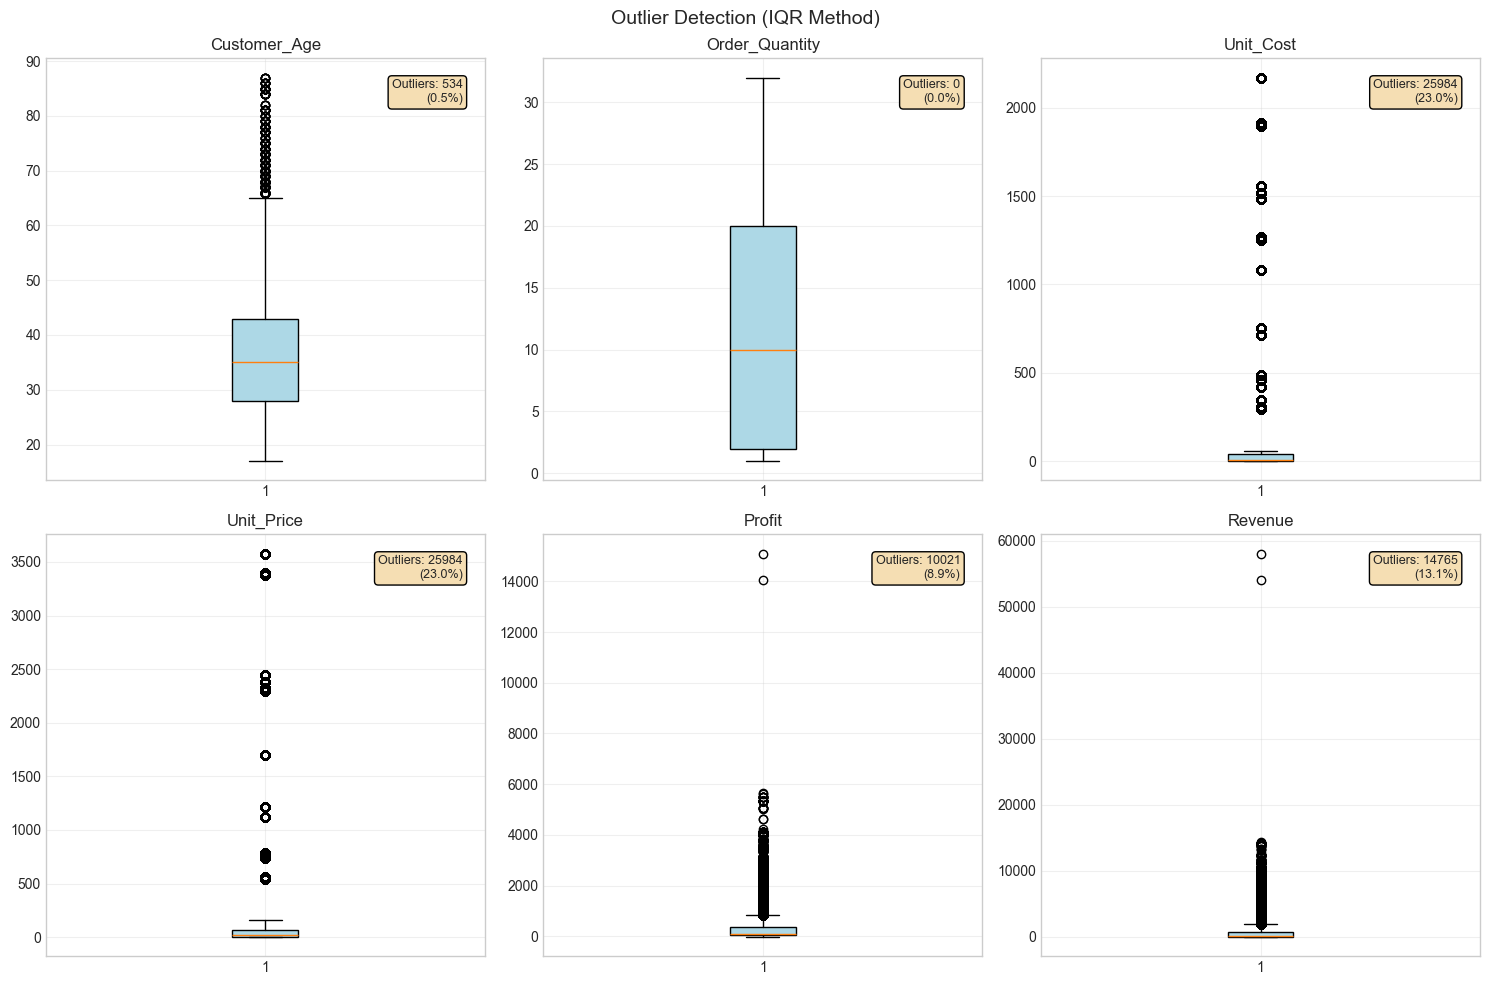

In [10]:
# Outlier detection with boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

cols_to_check = ['Customer_Age', 'Order_Quantity', 'Unit_Cost', 'Unit_Price', 'Profit', 'Revenue']

for i, col in enumerate(cols_to_check):
    bp = axes[i].boxplot(df[col], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    axes[i].set_title(col)
    axes[i].grid(True, alpha=0.3)
    
    # IQR outlier count
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)][col]
    axes[i].text(0.95, 0.95, f'Outliers: {len(outliers)}\n({len(outliers)/len(df)*100:.1f}%)', 
                 transform=axes[i].transAxes, fontsize=9, va='top', ha='right',
                 bbox=dict(boxstyle='round', facecolor='wheat'))

plt.suptitle('Outlier Detection (IQR Method)', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
# Outlier summary table
outlier_summary = []
for col in cols_to_check:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    n_outliers = len(df[(df[col] < lower) | (df[col] > upper)])
    outlier_summary.append({
        'Column': col, 'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
        'Lower': lower, 'Upper': upper,
        'Outliers': n_outliers, '%': round(n_outliers/len(df)*100, 2)
    })

pd.DataFrame(outlier_summary)

Column    Q1     Q3    IQR   Lower   Upper  Outliers      %
0    Customer_Age  28.0   43.0   15.0     5.5    65.5       534   0.47
1  Order_Quantity   2.0   20.0   18.0   -25.0    47.0         0   0.00
2       Unit_Cost   2.0   42.0   40.0   -58.0   102.0     25984  22.99
3      Unit_Price   5.0   70.0   65.0   -92.5   167.5     25984  22.99
4          Profit  29.0  358.0  329.0  -464.5   851.5     10021   8.87
5         Revenue  63.0  800.0  737.0 -1042.5  1905.5     14765  13.06

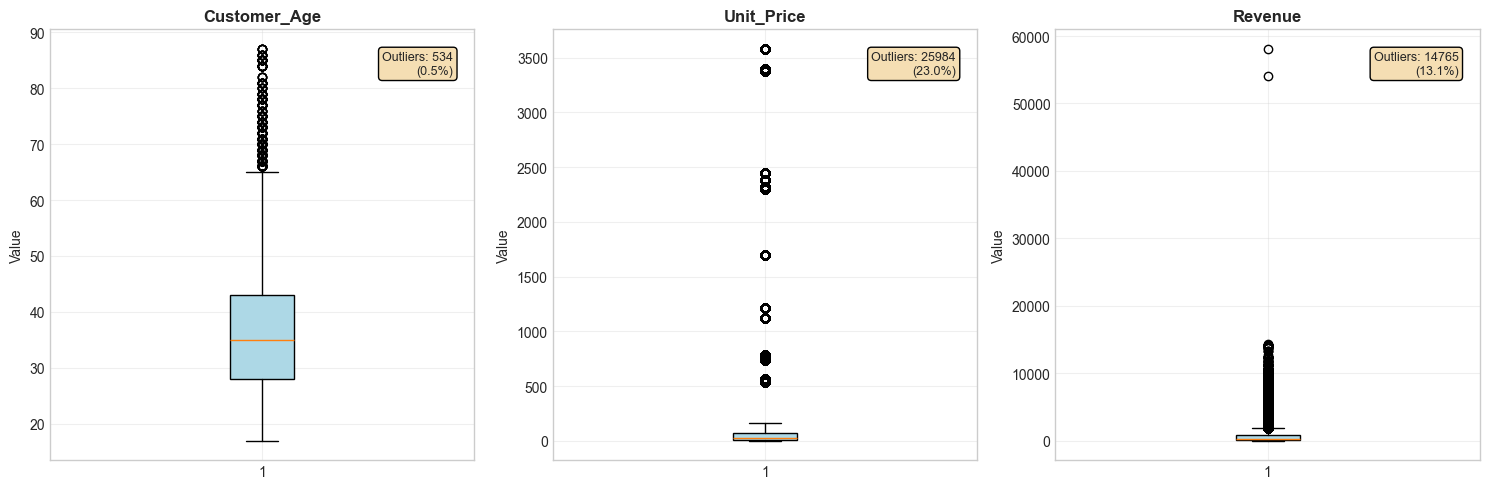

In [12]:
# Boxplots for Customer Age, Unit Price, and Revenue
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cols = ['Customer_Age', 'Unit_Price', 'Revenue']

for i, col in enumerate(cols):
    bp = axes[i].boxplot(df[col], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)
    
    # IQR outlier count
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)][col]
    axes[i].text(0.95, 0.95, f'Outliers: {len(outliers)}\n({len(outliers)/len(df)*100:.1f}%)', 
                 transform=axes[i].transAxes, fontsize=9, va='top', ha='right',
                 bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

In [13]:
# Duplicate check
exact_dups = df.duplicated().sum()
print(f"Exact duplicates: {exact_dups} ({exact_dups/len(df)*100:.2f}%)")

# Check by key columns
key_cols = ['Date', 'Customer_Age', 'Customer_Gender', 'Country', 'Product', 'Order_Quantity']
partial_dups = df.duplicated(subset=key_cols).sum()
print(f"Partial duplicates (key cols): {partial_dups}")

Exact duplicates: 1000 (0.88%)
Partial duplicates (key cols): 1031


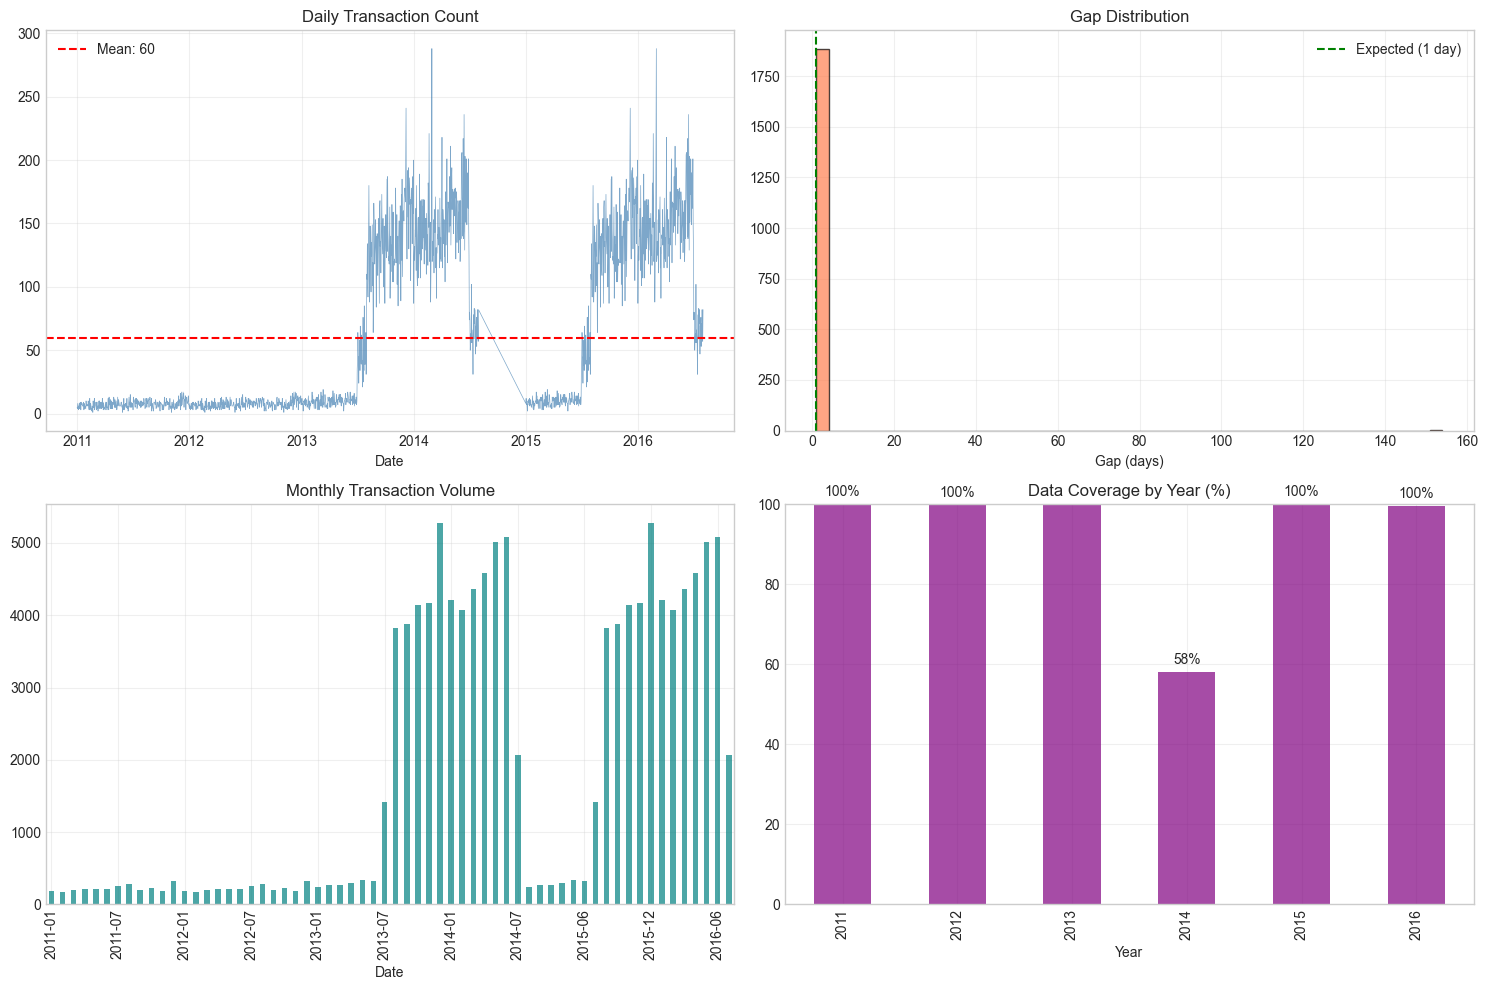


Total days in range: 2039
Days with data: 1884
Missing days: 155


In [14]:
# Timestamp gap analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1) Daily transactions over time
daily_counts = df.groupby('Date').size()
axes[0, 0].plot(daily_counts.index, daily_counts.values, color='steelblue', alpha=0.7, linewidth=0.5)
axes[0, 0].axhline(y=daily_counts.mean(), color='red', linestyle='--', label=f'Mean: {daily_counts.mean():.0f}')
axes[0, 0].set_title('Daily Transaction Count')
axes[0, 0].set_xlabel('Date')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2) Gap distribution
sorted_dates = df['Date'].sort_values().unique()
date_gaps = pd.Series(sorted_dates).diff().dt.days.dropna()
axes[0, 1].hist(date_gaps, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=1, color='green', linestyle='--', label='Expected (1 day)')
axes[0, 1].set_title('Gap Distribution')
axes[0, 1].set_xlabel('Gap (days)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3) Monthly volume
year_month = df['Date'].dt.to_period('M')
monthly = df.groupby(year_month).size()
monthly.plot(kind='bar', ax=axes[1, 0], color='teal', alpha=0.7)
axes[1, 0].set_title('Monthly Transaction Volume')
axes[1, 0].set_xticks(axes[1, 0].get_xticks()[::6])
axes[1, 0].grid(True, alpha=0.3)

# 4) Yearly coverage
full_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
date_presence = pd.DataFrame({'Date': full_range})
date_presence['HasData'] = date_presence['Date'].isin(df['Date'].unique()).astype(int)
date_presence['Year'] = date_presence['Date'].dt.year
yearly_cov = date_presence.groupby('Year')['HasData'].mean() * 100
yearly_cov.plot(kind='bar', ax=axes[1, 1], color='purple', alpha=0.7)
axes[1, 1].set_title('Data Coverage by Year (%)')
axes[1, 1].set_ylim(0, 100)
axes[1, 1].grid(True, alpha=0.3)
for i, v in enumerate(yearly_cov):
    if i == 2:
        continue
    axes[1, 1].text(i, v + 2, f'{v:.0f}%', ha='center')

plt.tight_layout()
plt.show()

print(f"\nTotal days in range: {len(full_range)}")
print(f"Days with data: {len(sorted_dates)}")
print(f"Missing days: {len(full_range) - len(sorted_dates)}")

In [15]:
# Data consistency check
#FIXME: was sind die revenue? ist komplet unlogisch. Vielleicht weglassen....
# Revenue = Quantity * Unit_Price?
calc_rev = df['Order_Quantity'] * df['Unit_Price']
rev_match = (np.abs(df['Revenue'] - calc_rev) < 1).sum()
print(f"Revenue = Qty * Price: {rev_match} ({rev_match/len(df)*100:.1f}%) match")

# Cost = Quantity * Unit_Cost?
calc_cost = df['Order_Quantity'] * df['Unit_Cost']
cost_match = (np.abs(df['Cost'] - calc_cost) < 1).sum()
print(f"Cost = Qty * Unit_Cost: {cost_match} ({cost_match/len(df)*100:.1f}%) match")

# Profit = Revenue - Cost?
calc_profit = df['Revenue'] - df['Cost']
profit_match = (np.abs(df['Profit'] - calc_profit) < 1).sum()
print(f"Profit = Revenue - Cost: {profit_match} ({profit_match/len(df)*100:.1f}%) match")

Revenue = Qty * Price: 6569 (5.8%) match
Cost = Qty * Unit_Cost: 113036 (100.0%) match
Profit = Revenue - Cost: 113036 (100.0%) match


## A.4 Data Preprocessing Pipeline (20 points)

In [16]:
def preprocess_sales_data(df):
    """
    Clean and transform sales data.
    Returns original df and cleaned df.
    """
    df_original = df.copy()
    df_clean = df.copy()
    
    # 1) Remove duplicates
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {len(df_original) - len(df_clean)} duplicates")
    
    # 2) Flag high-value transactions (top 10%)
    df_clean['Is_High_Value'] = df_clean['Revenue'] > df_clean['Revenue'].quantile(0.90)
    
    # 3) Add time features
    df_clean['DayOfWeek'] = df_clean['Date'].dt.dayofweek
    df_clean['DayOfWeek_Name'] = df_clean['Date'].dt.day_name()
    df_clean['WeekOfYear'] = df_clean['Date'].dt.isocalendar().week
    df_clean['Quarter'] = df_clean['Date'].dt.quarter
    df_clean['IsWeekend'] = df_clean['DayOfWeek'].isin([5, 6]).astype(int)
    
    # 4) Add financial features
    df_clean['Profit_Margin'] = (df_clean['Profit'] / df_clean['Revenue'] * 100).round(2)
    df_clean['Avg_Unit_Profit'] = (df_clean['Profit'] / df_clean['Order_Quantity']).round(2)
    
    return df_original, df_clean

df_original, df_cleaned = preprocess_sales_data(df)
print(f"Original: {df_original.shape}")
print(f"Cleaned: {df_cleaned.shape}")

Removed 1000 duplicates
Original: (113036, 18)
Cleaned: (112036, 26)


In [17]:
# Aggregate to daily time series
df_daily = df_cleaned.groupby('Date').agg({
    'Revenue': 'sum',
    'Profit': 'sum',
    'Cost': 'sum',
    'Order_Quantity': 'sum',
    'Product': 'count',
    'Customer_Age': 'mean',
    'Profit_Margin': 'mean',
    'Country': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown',
    'Product_Category': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown',
}).reset_index()

df_daily.columns = ['Date', 'Daily_Revenue', 'Daily_Profit', 'Daily_Cost', 
                    'Daily_Qty', 'Transaction_Count', 'Avg_Age', 'Avg_Margin', 
                    'Top_Country', 'Top_Category']

# Add time features
df_daily['DayOfWeek'] = df_daily['Date'].dt.dayofweek
df_daily['Month'] = df_daily['Date'].dt.month
df_daily['Year'] = df_daily['Date'].dt.year
df_daily['Quarter'] = df_daily['Date'].dt.quarter
df_daily['IsWeekend'] = df_daily['DayOfWeek'].isin([5, 6]).astype(int)

print(f"Daily dataset: {df_daily.shape}")
df_daily.head()

Daily dataset: (1884, 15)


Date  Daily_Revenue  Daily_Profit  Daily_Cost  Daily_Qty  \
0 2011-01-01          12821          3225        9596          8   
1 2011-01-02          11868          2925        8943          9   
2 2011-01-03          31175         12174       19001         17   
3 2011-01-04          18909          6240       12669         10   
4 2011-01-05           4675          1644        3031          5   

   Transaction_Count    Avg_Age  Avg_Margin    Top_Country Top_Category  \
0                  5  30.800000      28.336  United States        Bikes   
1                  4  37.000000      28.090      Australia        Bikes   
2                  8  39.125000      33.565      Australia        Bikes   
3                  5  34.800000      30.114  United States        Bikes   
4                  3  38.333333      35.080         Canada        Bikes   

   DayOfWeek  Month  Year  Quarter  IsWeekend  
0          5      1  2011        1          1  
1          6      1  2011        1          1  
2          0      1  2011        1          0  
3          1      1  2011        1          0  
4          2      1  2011        1          0

In [18]:
# Fill missing dates for complete time series
full_range = pd.date_range(start=df_daily['Date'].min(), end=df_daily['Date'].max(), freq='D')
df_daily_complete = df_daily.set_index('Date').reindex(full_range).reset_index()
df_daily_complete.columns = ['Date'] + list(df_daily.columns[1:])

# Fill numeric with 0 (no sales)
num_cols = ['Daily_Revenue', 'Daily_Profit', 'Daily_Cost', 'Daily_Qty', 'Transaction_Count']
df_daily_complete[num_cols] = df_daily_complete[num_cols].fillna(0)

# Fill averages with forward/backward fill
df_daily_complete['Avg_Age'] = df_daily_complete['Avg_Age'].ffill().bfill()
df_daily_complete['Avg_Margin'] = df_daily_complete['Avg_Margin'].ffill().bfill()

# Fill categorical
df_daily_complete['Top_Country'] = df_daily_complete['Top_Country'].fillna('No Sales')
df_daily_complete['Top_Category'] = df_daily_complete['Top_Category'].fillna('No Sales')

# Recreate time features
df_daily_complete['DayOfWeek'] = df_daily_complete['Date'].dt.dayofweek
df_daily_complete['Month'] = df_daily_complete['Date'].dt.month
df_daily_complete['Year'] = df_daily_complete['Date'].dt.year
df_daily_complete['Quarter'] = df_daily_complete['Date'].dt.quarter
df_daily_complete['IsWeekend'] = df_daily_complete['DayOfWeek'].isin([5, 6]).astype(int)

print(f"Complete time series: {df_daily_complete.shape}")
print(f"Days with no sales: {(df_daily_complete['Transaction_Count'] == 0).sum()}")

Complete time series: (2039, 15)
Days with no sales: 155


In [19]:
# Summary of datasets
print("Datasets created:")
print(f"  df_original: {df_original.shape} - raw data")
print(f"  df_cleaned: {df_cleaned.shape} - transaction level, cleaned")
print(f"  df_daily: {df_daily.shape} - daily aggregated")
print(f"  df_daily_complete: {df_daily_complete.shape} - complete time series")

print("\nNew features added:")
for f in ['DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend', 'Profit_Margin', 'Avg_Unit_Profit', 'Is_High_Value']:
    if f in df_cleaned.columns:
        print(f"  - {f}")

Datasets created:
  df_original: (113036, 18) - raw data
  df_cleaned: (112036, 26) - transaction level, cleaned
  df_daily: (1884, 15) - daily aggregated
  df_daily_complete: (2039, 15) - complete time series

New features added:
  - DayOfWeek
  - WeekOfYear
  - Quarter
  - IsWeekend
  - Profit_Margin
  - Avg_Unit_Profit
  - Is_High_Value


## A.5 Preprocessed vs Original Comparison (10 points)

In [20]:
# Before/After comparison
comparison = {
    'Metric': ['Rows', 'Columns', 'Duplicates', 'Missing', 'Total Revenue', 'Unique Dates'],
    'Original': [
        len(df_original), df_original.shape[1], df_original.duplicated().sum(),
        df_original.isnull().sum().sum(), f"${df_original['Revenue'].sum():,.0f}",
        df_original['Date'].nunique()
    ],
    'Cleaned': [
        len(df_cleaned), df_cleaned.shape[1], df_cleaned.duplicated().sum(),
        df_cleaned.isnull().sum().sum(), f"${df_cleaned['Revenue'].sum():,.0f}",
        df_cleaned['Date'].nunique()
    ],
    'Daily Complete': [
        len(df_daily_complete), df_daily_complete.shape[1], 'N/A',
        df_daily_complete.isnull().sum().sum(), f"${df_daily_complete['Daily_Revenue'].sum():,.0f}",
        len(df_daily_complete)
    ]
}
pd.DataFrame(comparison)

Metric     Original      Cleaned Daily Complete
0           Rows       113036       112036           2039
1        Columns           18           26             15
2     Duplicates         1000            0            N/A
3        Missing            0            0              0
4  Total Revenue  $85,271,008  $84,826,772    $84,826,772
5   Unique Dates         1884         1884           2039

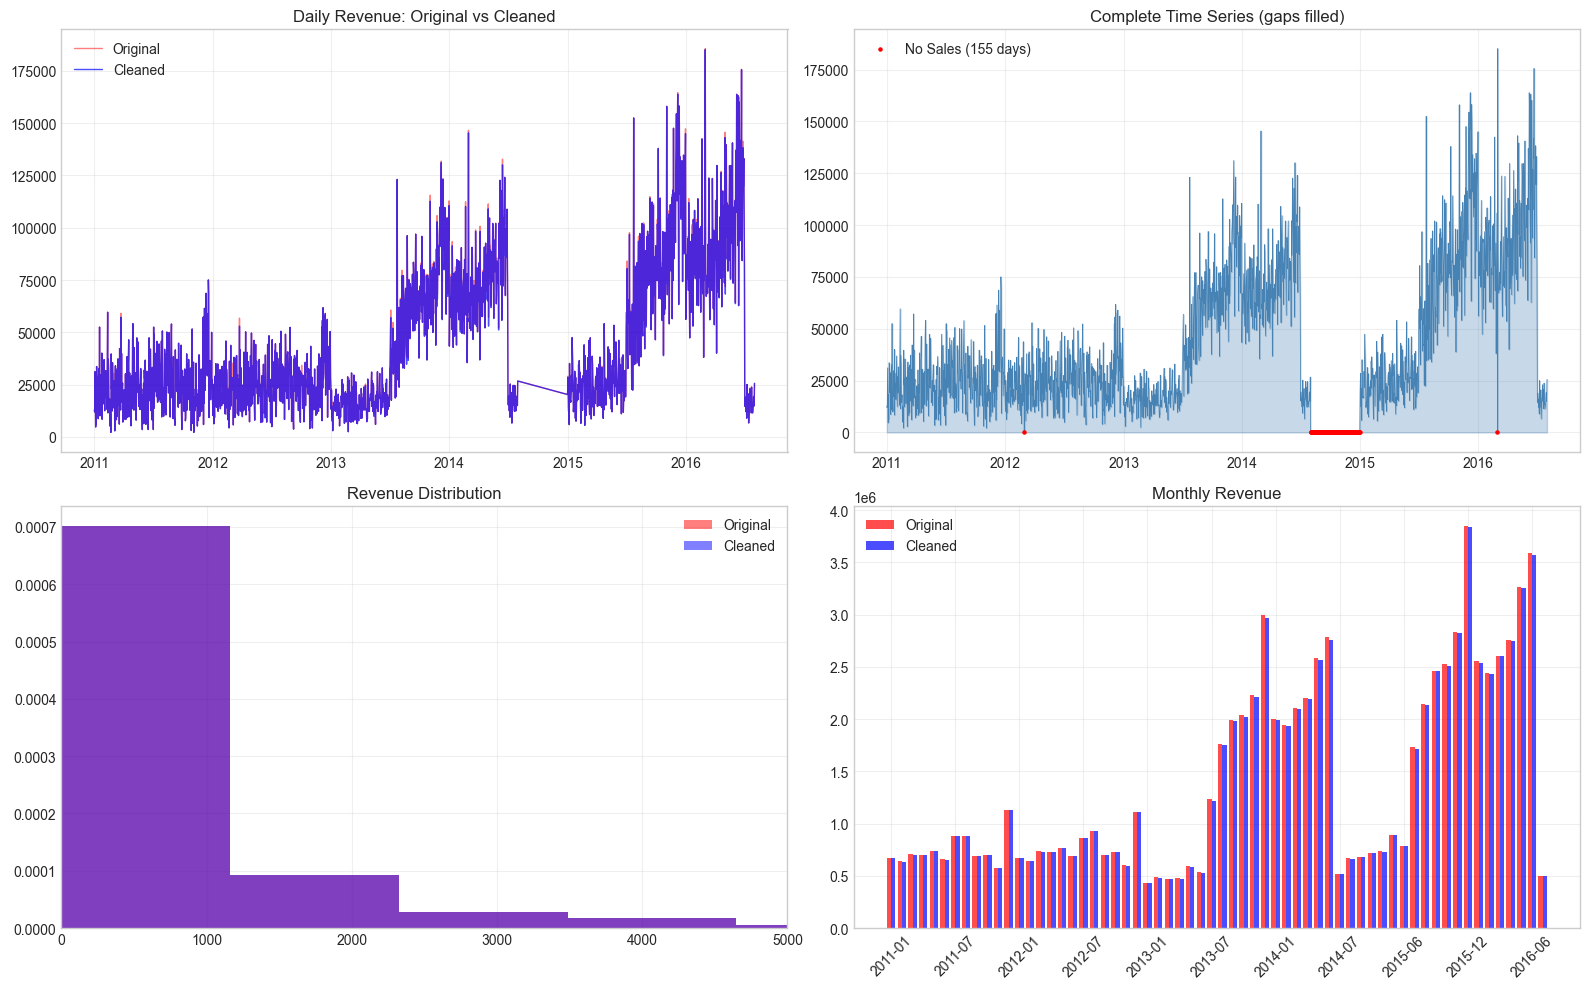

In [21]:
# Visual comparison: Original vs Cleaned
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1) Daily revenue comparison
orig_daily = df_original.groupby('Date')['Revenue'].sum()
clean_daily = df_cleaned.groupby('Date')['Revenue'].sum()
axes[0, 0].plot(orig_daily.index, orig_daily.values, color='red', alpha=0.5, label='Original', linewidth=1)
axes[0, 0].plot(clean_daily.index, clean_daily.values, color='blue', alpha=0.7, label='Cleaned', linewidth=1)
axes[0, 0].set_title('Daily Revenue: Original vs Cleaned')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2) Complete time series with gaps
axes[0, 1].fill_between(df_daily_complete['Date'], df_daily_complete['Daily_Revenue'], 
                        alpha=0.3, color='steelblue')
axes[0, 1].plot(df_daily_complete['Date'], df_daily_complete['Daily_Revenue'], 
                color='steelblue', linewidth=0.5)
no_sales = df_daily_complete[df_daily_complete['Transaction_Count'] == 0]
axes[0, 1].scatter(no_sales['Date'], no_sales['Daily_Revenue'], 
                   color='red', s=5, label=f'No Sales ({len(no_sales)} days)', zorder=5)
axes[0, 1].set_title('Complete Time Series (gaps filled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3) Revenue distribution
axes[1, 0].hist(df_original['Revenue'], bins=50, alpha=0.5, color='red', label='Original', density=True)
axes[1, 0].hist(df_cleaned['Revenue'], bins=50, alpha=0.5, color='blue', label='Cleaned', density=True)
axes[1, 0].set_title('Revenue Distribution')
axes[1, 0].set_xlim(0, 5000)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4) Monthly comparison
orig_monthly = df_original.groupby(df_original['Date'].dt.to_period('M'))['Revenue'].sum()
clean_monthly = df_cleaned.groupby(df_cleaned['Date'].dt.to_period('M'))['Revenue'].sum()
x = range(len(orig_monthly))
w = 0.4
axes[1, 1].bar([i - w/2 for i in x], orig_monthly.values, w, label='Original', color='red', alpha=0.7)
axes[1, 1].bar([i + w/2 for i in x], clean_monthly.values, w, label='Cleaned', color='blue', alpha=0.7)
axes[1, 1].set_title('Monthly Revenue')
axes[1, 1].set_xticks(x[::6])
axes[1, 1].set_xticklabels([str(orig_monthly.index[i]) for i in x[::6]], rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

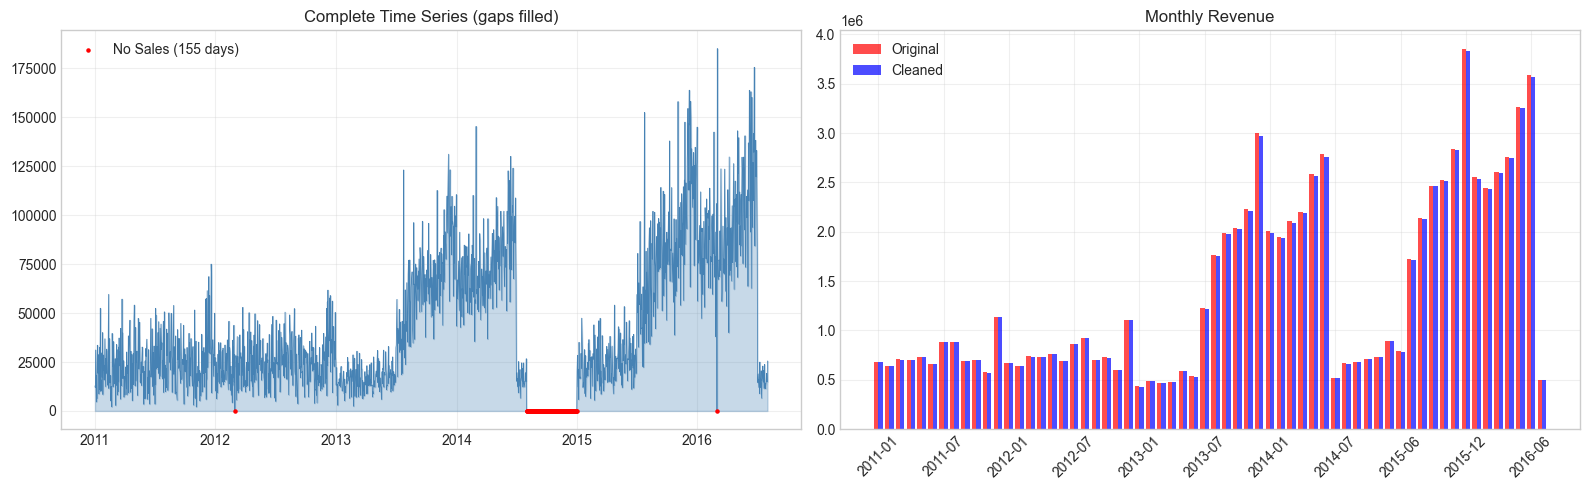

In [22]:
# For report: Focus on complete time series and monthly comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1) Complete time series with gaps
axes[0].fill_between(df_daily_complete['Date'], df_daily_complete['Daily_Revenue'], 
                        alpha=0.3, color='steelblue')
axes[0].plot(df_daily_complete['Date'], df_daily_complete['Daily_Revenue'], 
                color='steelblue', linewidth=0.5)
no_sales = df_daily_complete[df_daily_complete['Transaction_Count'] == 0]
axes[0].scatter(no_sales['Date'], no_sales['Daily_Revenue'], 
                   color='red', s=5, label=f'No Sales ({len(no_sales)} days)', zorder=5)
axes[0].set_title('Complete Time Series (gaps filled)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) Monthly comparison
orig_monthly = df_original.groupby(df_original['Date'].dt.to_period('M'))['Revenue'].sum()
clean_monthly = df_cleaned.groupby(df_cleaned['Date'].dt.to_period('M'))['Revenue'].sum()
x = range(len(orig_monthly))
w = 0.4
axes[1].bar([i - w/2 for i in x], orig_monthly.values, w, label='Original', color='red', alpha=0.7)
axes[1].bar([i + w/2 for i in x], clean_monthly.values, w, label='Cleaned', color='blue', alpha=0.7)
axes[1].set_title('Monthly Revenue')
axes[1].set_xticks(x[::6])
axes[1].set_xticklabels([str(orig_monthly.index[i]) for i in x[::6]], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

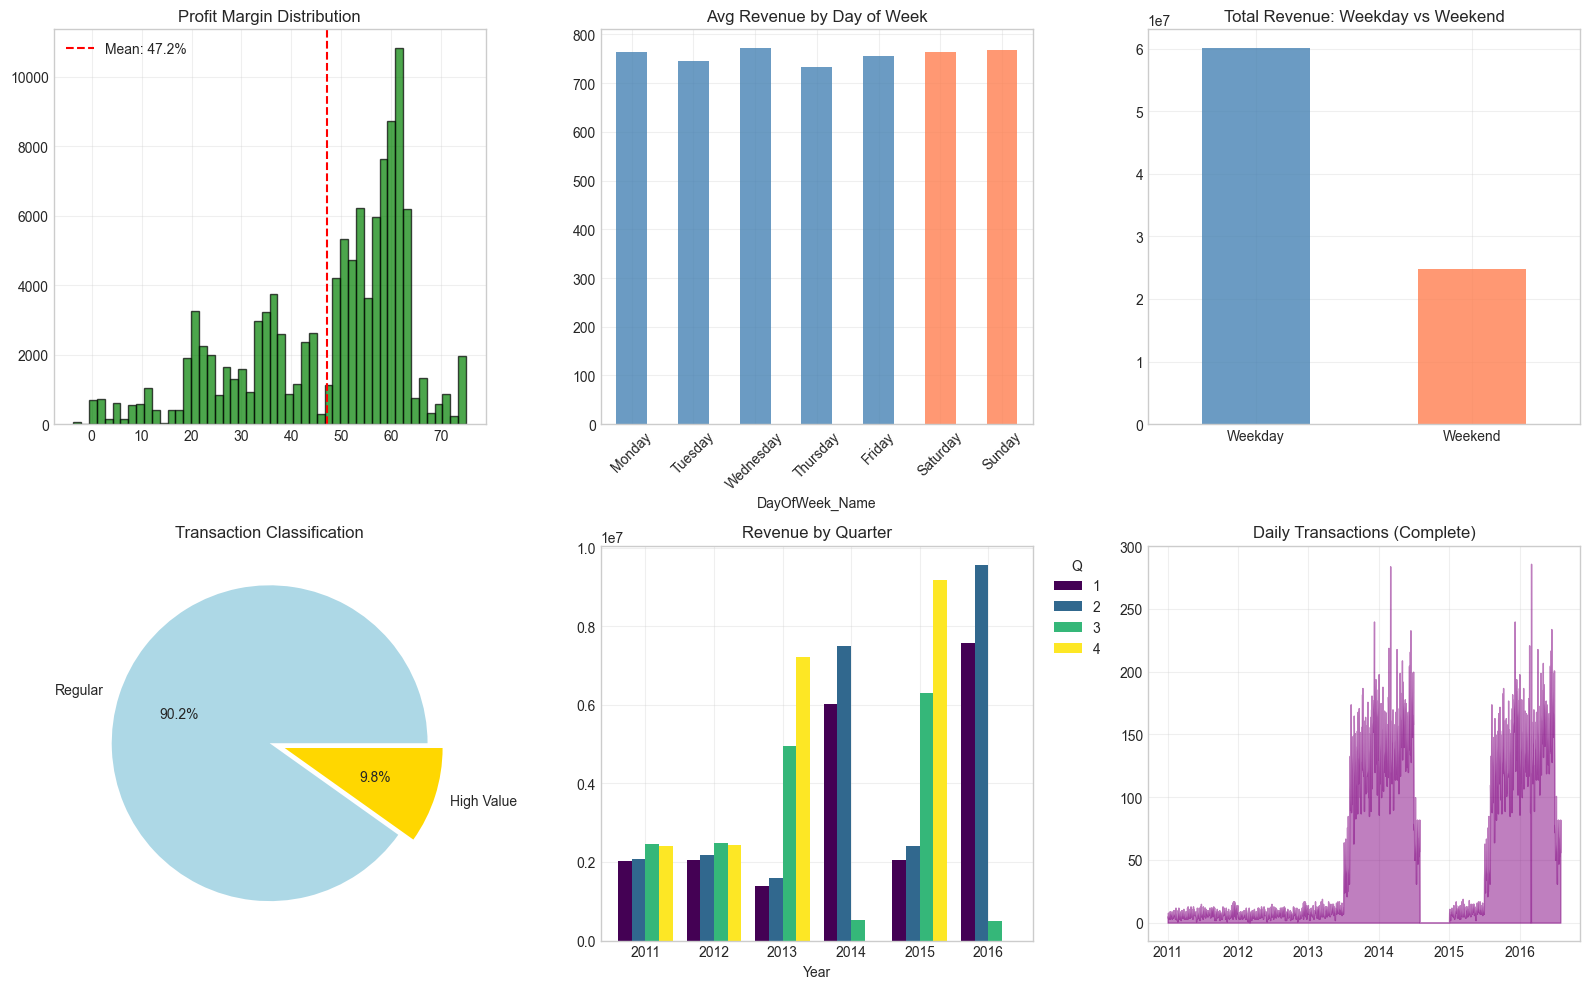

In [23]:
# New features visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1) Profit margin distribution
axes[0, 0].hist(df_cleaned['Profit_Margin'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df_cleaned['Profit_Margin'].mean(), color='red', linestyle='--', 
                   label=f"Mean: {df_cleaned['Profit_Margin'].mean():.1f}%")
axes[0, 0].set_title('Profit Margin Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2) Revenue by day of week
dow_rev = df_cleaned.groupby('DayOfWeek_Name')['Revenue'].mean()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_rev = dow_rev.reindex(dow_order)
colors = ['steelblue']*5 + ['coral']*2
dow_rev.plot(kind='bar', ax=axes[0, 1], color=colors, alpha=0.8)
axes[0, 1].set_title('Avg Revenue by Day of Week')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3) Weekend vs Weekday
weekend_total = df_cleaned.groupby('IsWeekend')['Revenue'].sum()
weekend_total.index = ['Weekday', 'Weekend']
weekend_total.plot(kind='bar', ax=axes[0, 2], color=['steelblue', 'coral'], alpha=0.8)
axes[0, 2].set_title('Total Revenue: Weekday vs Weekend')
axes[0, 2].tick_params(axis='x', rotation=0)
axes[0, 2].grid(True, alpha=0.3)

# 4) High value transactions
hv = df_cleaned['Is_High_Value'].value_counts()
hv.index = ['Regular', 'High Value']
axes[1, 0].pie(hv, labels=hv.index, autopct='%1.1f%%', colors=['lightblue', 'gold'], explode=[0, 0.1])
axes[1, 0].set_title('Transaction Classification')

# 5) Revenue by quarter
q_rev = df_cleaned.groupby(['Year', 'Quarter'])['Revenue'].sum().unstack()
q_rev.plot(kind='bar', ax=axes[1, 1], width=0.8, colormap='viridis')
axes[1, 1].set_title('Revenue by Quarter')
axes[1, 1].legend(title='Q', bbox_to_anchor=(1.02, 1))
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(True, alpha=0.3)

# 6) Daily transactions
axes[1, 2].fill_between(df_daily_complete['Date'], df_daily_complete['Transaction_Count'], 
                        alpha=0.5, color='purple')
axes[1, 2].set_title('Daily Transactions (Complete)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

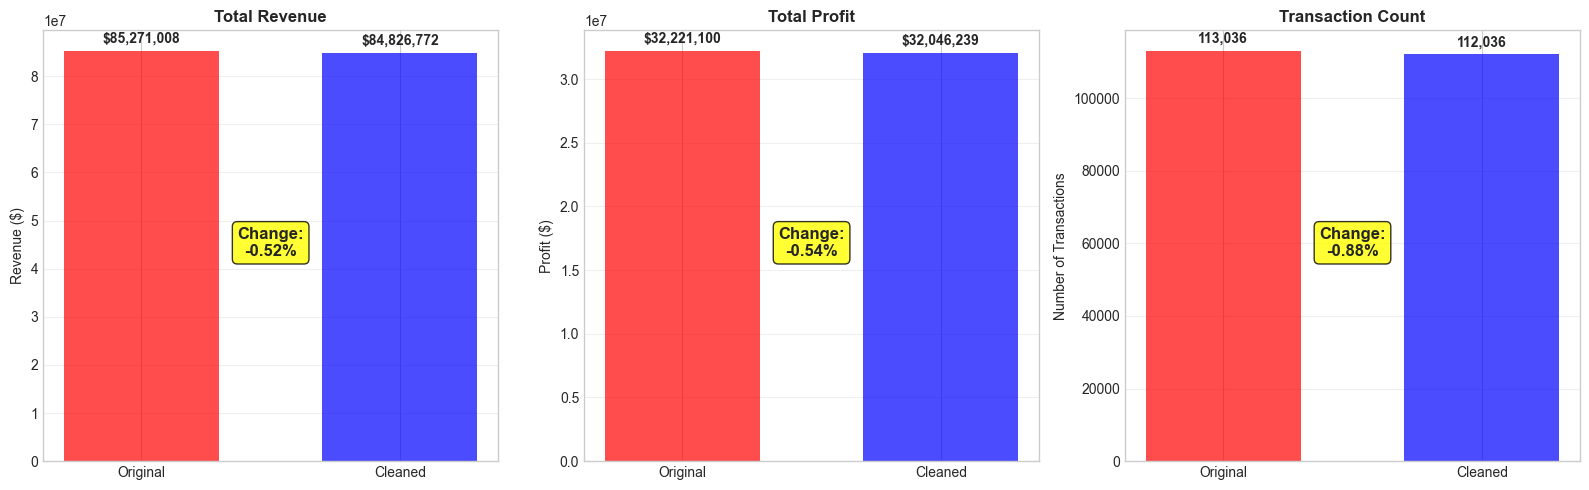

In [24]:
# Impact of duplicate removal - Key metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Prepare data
metrics = {
    'Total Revenue': [df_original['Revenue'].sum(), df_cleaned['Revenue'].sum()],
    'Total Profit': [df_original['Profit'].sum(), df_cleaned['Profit'].sum()],
    'Transaction Count': [len(df_original), len(df_cleaned)]
}

labels = ['Original', 'Cleaned']
x = np.arange(len(labels))
width = 0.6

# 1) Total Revenue Comparison
rev_data = metrics['Total Revenue']
rev_pct_change = (rev_data[1] - rev_data[0]) / rev_data[0] * 100
axes[0].bar(x, rev_data, width, color=['red', 'blue'], alpha=0.7)
axes[0].set_title('Total Revenue', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Revenue ($)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rev_data):
    axes[0].text(i, v + max(rev_data)*0.02, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=10)
axes[0].text(0.5, max(rev_data)*0.5, f'Change:\n{rev_pct_change:.2f}%', ha='center', fontsize=12, 
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8), fontweight='bold')

# 2) Total Profit Comparison
profit_data = metrics['Total Profit']
profit_pct_change = (profit_data[1] - profit_data[0]) / profit_data[0] * 100
axes[1].bar(x, profit_data, width, color=['red', 'blue'], alpha=0.7)
axes[1].set_title('Total Profit', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Profit ($)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(profit_data):
    axes[1].text(i, v + max(profit_data)*0.02, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=10)
axes[1].text(0.5, max(profit_data)*0.5, f'Change:\n{profit_pct_change:.2f}%', ha='center', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8), fontweight='bold')

# 3) Transaction Count Comparison
count_data = metrics['Transaction Count']
count_pct_change = (count_data[1] - count_data[0]) / count_data[0] * 100
axes[2].bar(x, count_data, width, color=['red', 'blue'], alpha=0.7)
axes[2].set_title('Transaction Count', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Number of Transactions')
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels)
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(count_data):
    axes[2].text(i, v + max(count_data)*0.02, f'{v:,}', ha='center', fontweight='bold', fontsize=10)
axes[2].text(0.5, max(count_data)*0.5, f'Change:\n{count_pct_change:.2f}%', ha='center', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8), fontweight='bold')

plt.tight_layout()
plt.show()


### Summary

**Changes made:**
- Removed 1,000 duplicate rows
- Filled 155 missing dates with zeros for complete time series
- Added 8 derived features (time + financial)

**Key findings:**
- Revenue decreased by ~$444k after duplicate removal
- Weekdays generate ~71% of total revenue
- Mean profit margin: 47.2%
- 2015 has lower coverage (data gap Aug-Dec)
- Q4 typically strongest (holiday sales)

**Datasets ready:**
- `df_cleaned`: 112,036 × 27 (transaction level)
- `df_daily_complete`: 2,039 × 15 (daily time series)

# Task B: Visualization and Exploratory Analysis (55 points)

## B.1 Time-Series Visualizations (10 points)

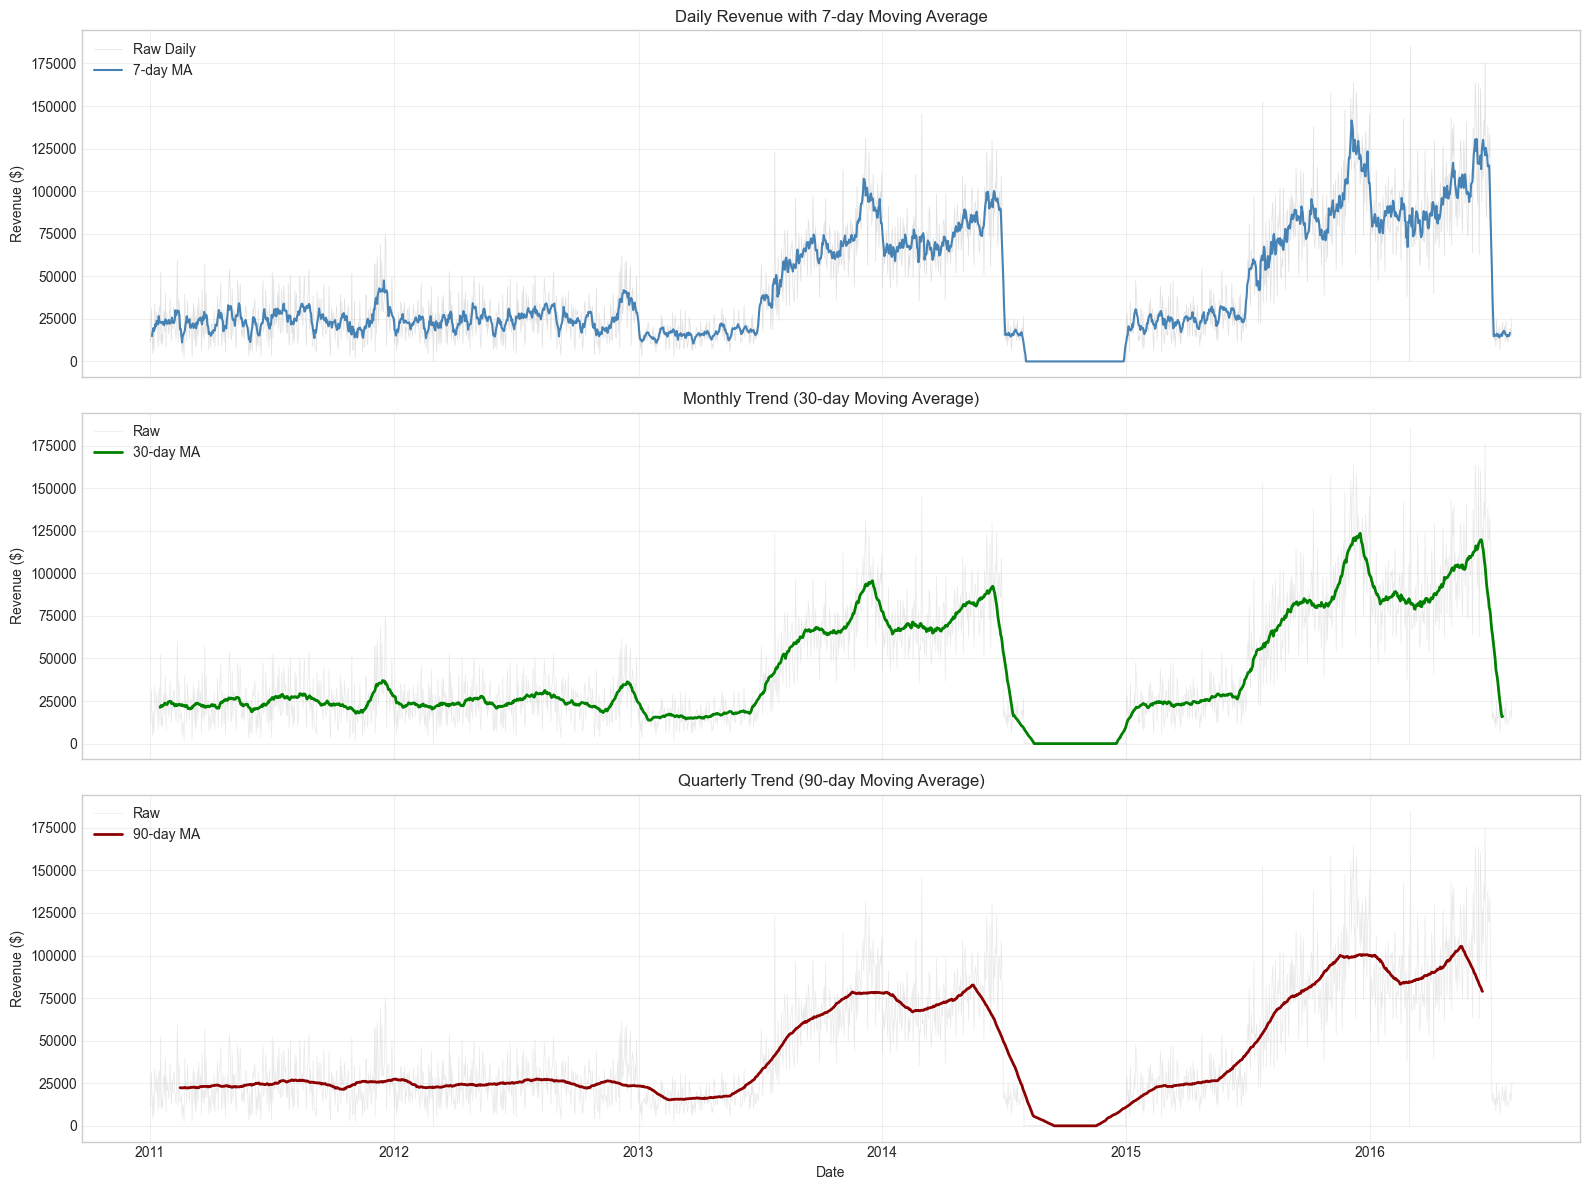

In [25]:
# Raw time series + rolling means
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Calculate rolling means
df_daily_complete['Revenue_7d'] = df_daily_complete['Daily_Revenue'].rolling(window=7, center=True).mean()
df_daily_complete['Revenue_30d'] = df_daily_complete['Daily_Revenue'].rolling(window=30, center=True).mean()
df_daily_complete['Revenue_90d'] = df_daily_complete['Daily_Revenue'].rolling(window=90, center=True).mean()

# 1) Raw daily revenue
axes[0].plot(df_daily_complete['Date'], df_daily_complete['Daily_Revenue'], 
             color='lightgray', linewidth=0.5, alpha=0.7, label='Raw Daily')
axes[0].plot(df_daily_complete['Date'], df_daily_complete['Revenue_7d'], 
             color='steelblue', linewidth=1.5, label='7-day MA')
axes[0].set_title('Daily Revenue with 7-day Moving Average')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel('Revenue ($)')

# 2) 30-day smoothed
axes[1].plot(df_daily_complete['Date'], df_daily_complete['Daily_Revenue'], 
             color='lightgray', linewidth=0.5, alpha=0.5, label='Raw')
axes[1].plot(df_daily_complete['Date'], df_daily_complete['Revenue_30d'], 
             color='green', linewidth=2, label='30-day MA')
axes[1].set_title('Monthly Trend (30-day Moving Average)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel('Revenue ($)')

# 3) 90-day quarterly trend
axes[2].plot(df_daily_complete['Date'], df_daily_complete['Daily_Revenue'], 
             color='lightgray', linewidth=0.5, alpha=0.5, label='Raw')
axes[2].plot(df_daily_complete['Date'], df_daily_complete['Revenue_90d'], 
             color='darkred', linewidth=2, label='90-day MA')
axes[2].set_title('Quarterly Trend (90-day Moving Average)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylabel('Revenue ($)')
axes[2].set_xlabel('Date')


plt.tight_layout()
plt.show()

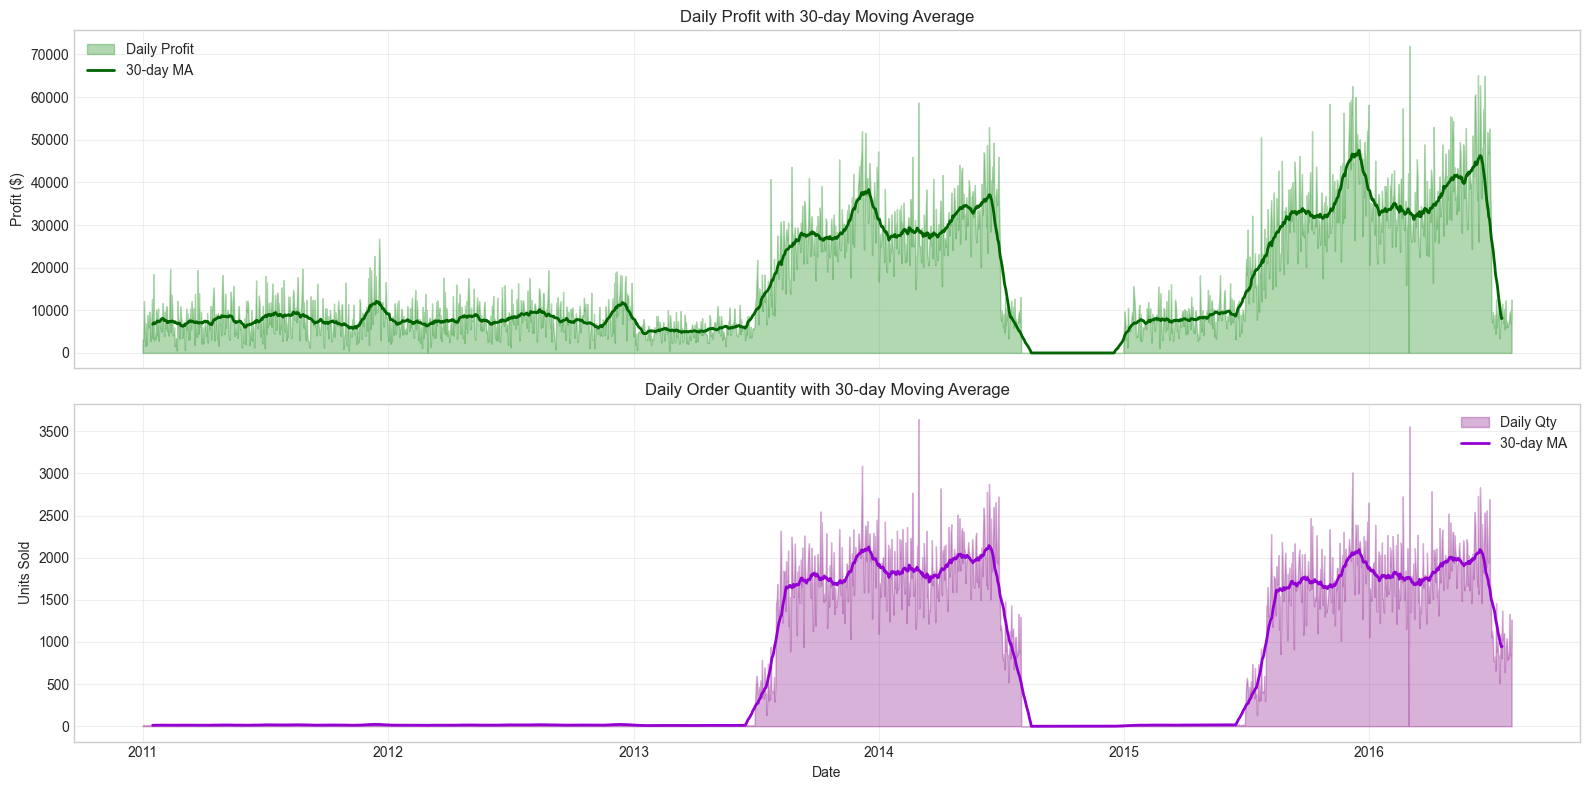

In [26]:
# Profit and Order Quantity time series
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Rolling means for profit
df_daily_complete['Profit_30d'] = df_daily_complete['Daily_Profit'].rolling(window=30, center=True).mean()
df_daily_complete['Qty_30d'] = df_daily_complete['Daily_Qty'].rolling(window=30, center=True).mean()

# 1) Profit
axes[0].fill_between(df_daily_complete['Date'], df_daily_complete['Daily_Profit'], 
                     alpha=0.3, color='green', label='Daily Profit')
axes[0].plot(df_daily_complete['Date'], df_daily_complete['Profit_30d'], 
             color='darkgreen', linewidth=2, label='30-day MA')
axes[0].set_title('Daily Profit with 30-day Moving Average')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel('Profit ($)')

# 2) Order quantity
axes[1].fill_between(df_daily_complete['Date'], df_daily_complete['Daily_Qty'], 
                     alpha=0.3, color='purple', label='Daily Qty')
axes[1].plot(df_daily_complete['Date'], df_daily_complete['Qty_30d'], 
             color='darkviolet', linewidth=2, label='30-day MA')
axes[1].set_title('Daily Order Quantity with 30-day Moving Average')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel('Units Sold')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

## B.2 Distribution Analysis (10 points)

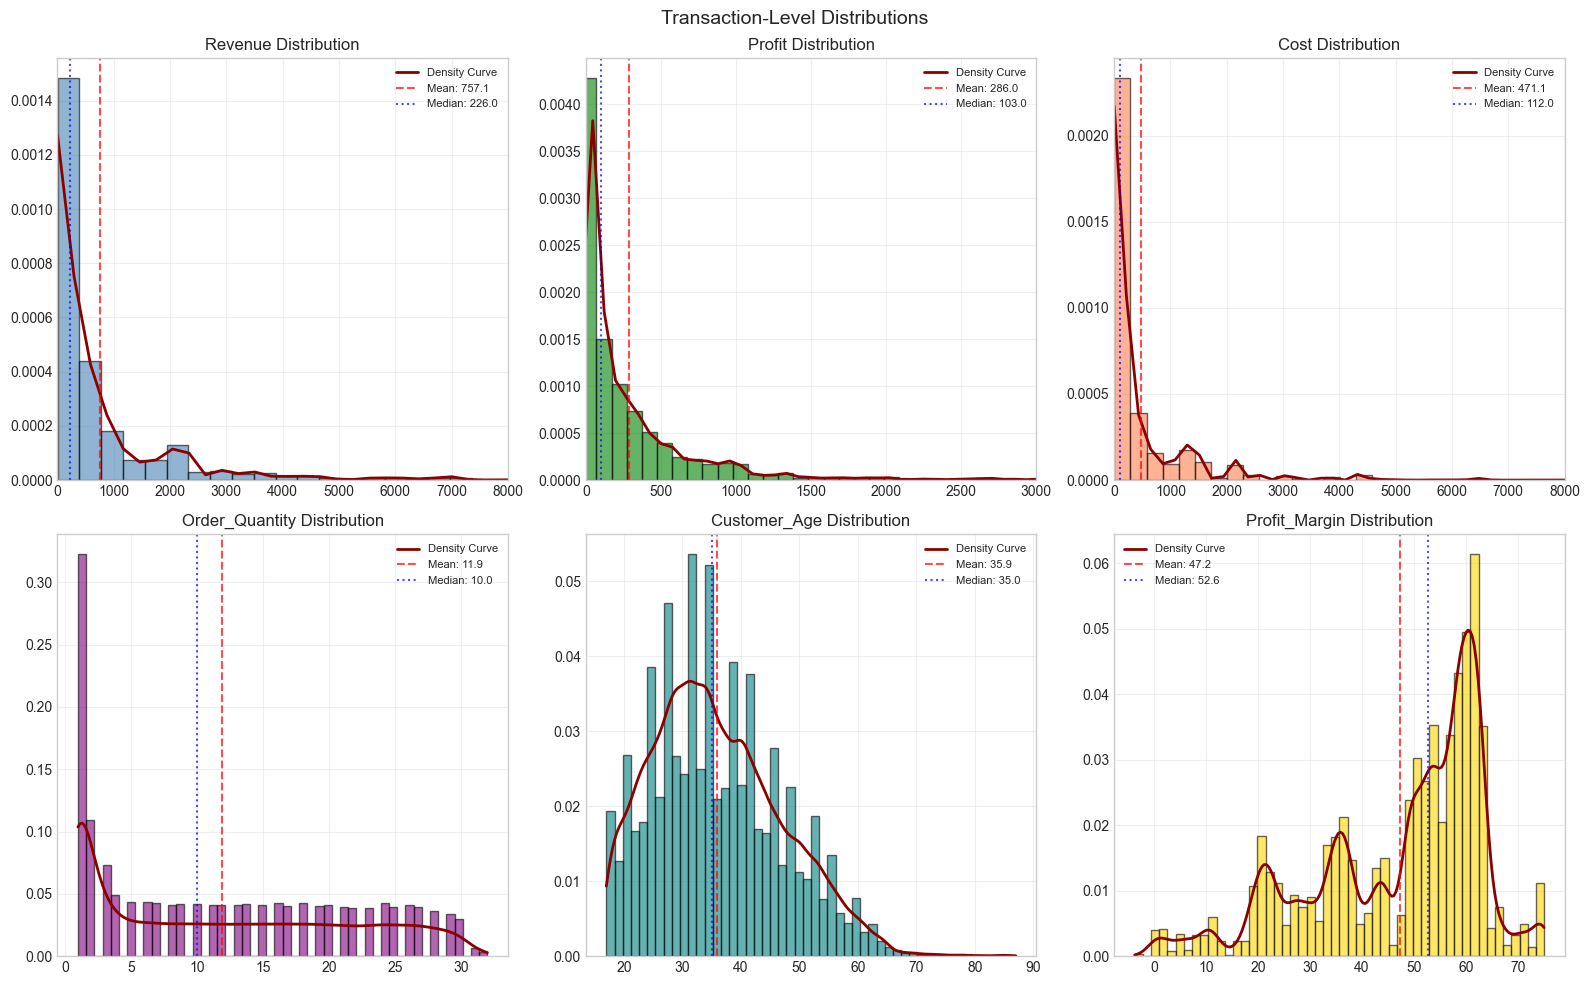

In [27]:
# Distribution analysis - histograms with Density Curves
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Transaction-level distributions (df_cleaned)
dist_cols = ['Revenue', 'Profit', 'Cost', 'Order_Quantity', 'Customer_Age', 'Profit_Margin']
colors = ['steelblue', 'green', 'coral', 'purple', 'teal', 'gold']

for i, (col, color) in enumerate(zip(dist_cols, colors)):
    row, c = i // 3, i % 3
    
    # Histogram + Density Curve
    data = df_cleaned[col].dropna()
    match(i):
        case 0|2:
            axes[row, c].set_xlim(0, 8000)
            axes[row, c].hist(data, bins=150, density=True, alpha=0.6, color=color, edgecolor='black')
        case 1:
            axes[row, c].set_xlim(0, 3000)
            axes[row, c].hist(data, bins=150, density=True, alpha=0.6, color=color, edgecolor='black')
        case _:
            axes[row, c].hist(data, bins=50, density=True, alpha=0.6, color=color, edgecolor='black')

    # Density Curve overlay
    from scipy import stats
    kde_x = np.linspace(data.min(), data.max(), 200)
    kde = stats.gaussian_kde(data)
    axes[row, c].plot(kde_x, kde(kde_x), color='darkred', linewidth=2, label='Density Curve')
    
    # Stats annotation
    axes[row, c].axvline(data.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {data.mean():.1f}')
    axes[row, c].axvline(data.median(), color='blue', linestyle=':', alpha=0.7, label=f'Median: {data.median():.1f}')
    axes[row, c].set_title(f'{col} Distribution')
    axes[row, c].legend(fontsize=8)
    axes[row, c].grid(True, alpha=0.3)
    

plt.suptitle('Transaction-Level Distributions', fontsize=14)
plt.tight_layout()
plt.show()

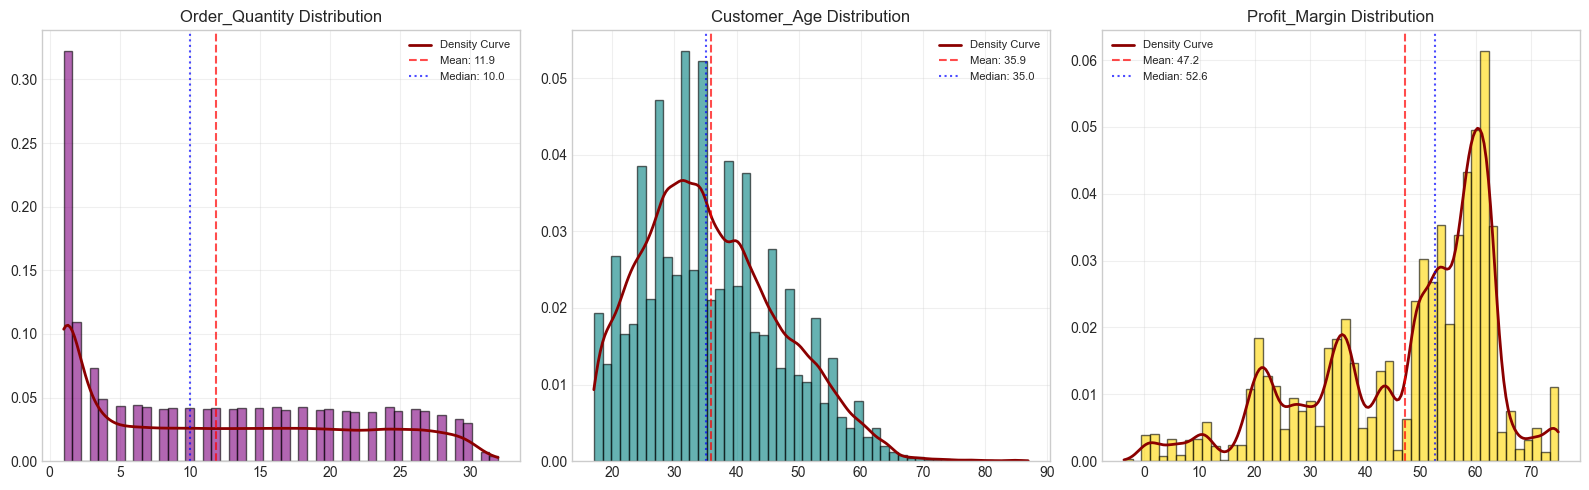

In [28]:
# For report - focused view (1x3)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

dist_cols_second = ['Order_Quantity', 'Customer_Age', 'Profit_Margin']
colors_second = ['purple', 'teal', 'gold']

for i, (col, color) in enumerate(zip(dist_cols_second, colors_second)):
    data = df_cleaned[col].dropna()
    
    axes[i].hist(data, bins=50, density=True, alpha=0.6, color=color, edgecolor='black')
    
    # Density Curve overlay
    from scipy import stats
    kde_x = np.linspace(data.min(), data.max(), 200)
    kde = stats.gaussian_kde(data)
    axes[i].plot(kde_x, kde(kde_x), color='darkred', linewidth=2, label='Density Curve')
    
    # Stats annotation
    axes[i].axvline(data.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {data.mean():.1f}')
    axes[i].axvline(data.median(), color='blue', linestyle=':', alpha=0.7, label=f'Median: {data.median():.1f}')
    axes[i].set_title(f'{col} Distribution', fontsize=12)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Statistical characteristics of the three distributions
from scipy import stats

dist_cols_second = ['Order_Quantity', 'Customer_Age', 'Profit_Margin']

print("=" * 85)
print("DISTRIBUTION CHARACTERISTICS ANALYSIS")
print("=" * 85)

for col in dist_cols_second:
    data = df_cleaned[col].dropna()
    
    # Calculate statistics
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)  # excess kurtosis (normal = 0)
    
    # Detect modality via histogram peaks
    hist, bin_edges = np.histogram(data, bins=50)
    peak_threshold = np.max(hist) * 0.3  # 30% of max height
    peaks = np.where(hist > peak_threshold)[0]
    
    print(f"\n{col.upper()}")
    print("-" * 85)
    
    # Skewness interpretation
    print(f"  SKEWNESS: {skewness:.3f}")
    if skewness > 0.5:
        skew_type = "RIGHT-SKEWED (positive skew)"
        skew_meaning = "Tail extends to the right; most values cluster on left"
        print(f"    → {skew_type}: {skew_meaning}")
    elif skewness < -0.5:
        skew_type = "LEFT-SKEWED (negative skew)"
        skew_meaning = "Tail extends to the left; most values cluster on right"
        print(f"    → {skew_type}: {skew_meaning}")
    else:
        print(f"    → APPROXIMATELY SYMMETRIC: Distribution is balanced")
    
    # Kurtosis (heavy tails)
    print(f"  HEAVY TAILS (Kurtosis): {kurtosis:.3f}")
    if kurtosis > 1:
        tail_type = "HEAVY TAILS"
        tail_meaning = "More extreme outliers/values far from mean than normal distribution"
        print(f"    → {tail_type}: {tail_meaning}")
    elif kurtosis < -1:
        tail_type = "LIGHT TAILS"
        tail_meaning = "Fewer extreme values; values concentrated near center"
        print(f"    → {tail_type}: {tail_meaning}")
    else:
        print(f"    → NORMAL-LIKE TAILS: Similar to normal distribution")
    
    # Modality
    print(f"  MULTIMODALITY: ", end="")
    if len(peaks) <= 1:
        print("UNIMODAL (single peak) - one dominant center")
    elif len(peaks) == 2:
        print("BIMODAL (two peaks) - two different groups")
    else:
        print(f"MULTIMODAL ({len(peaks)} peaks) - multiple groups/clusters in data")
    
    print(f"\n  Summary stats:")
    print(f"    Range: {data.min():.2f} to {data.max():.2f}")
    print(f"    Mean: {data.mean():.2f} | Median: {data.median():.2f} | Std Dev: {data.std():.2f}")
    print(f"    IQR: {data.quantile(0.75) - data.quantile(0.25):.2f}")

print("\n" + "=" * 85)

DISTRIBUTION CHARACTERISTICS ANALYSIS

ORDER_QUANTITY
-------------------------------------------------------------------------------------
  SKEWNESS: 0.378
    → APPROXIMATELY SYMMETRIC: Distribution is balanced
  HEAVY TAILS (Kurtosis): -1.232
    → LIGHT TAILS: Fewer extreme values; values concentrated near center
  MULTIMODALITY: BIMODAL (two peaks) - two different groups

  Summary stats:
    Range: 1.00 to 32.00
    Mean: 11.90 | Median: 10.00 | Std Dev: 9.56
    IQR: 18.00

CUSTOMER_AGE
-------------------------------------------------------------------------------------
  SKEWNESS: 0.524
    → RIGHT-SKEWED (positive skew): Tail extends to the right; most values cluster on left
  HEAVY TAILS (Kurtosis): -0.123
    → NORMAL-LIKE TAILS: Similar to normal distribution
  MULTIMODALITY: MULTIMODAL (22 peaks) - multiple groups/clusters in data

  Summary stats:
    Range: 17.00 to 87.00
    Mean: 35.92 | Median: 35.00 | Std Dev: 11.02
    IQR: 15.00

PROFIT_MARGIN
-------------------

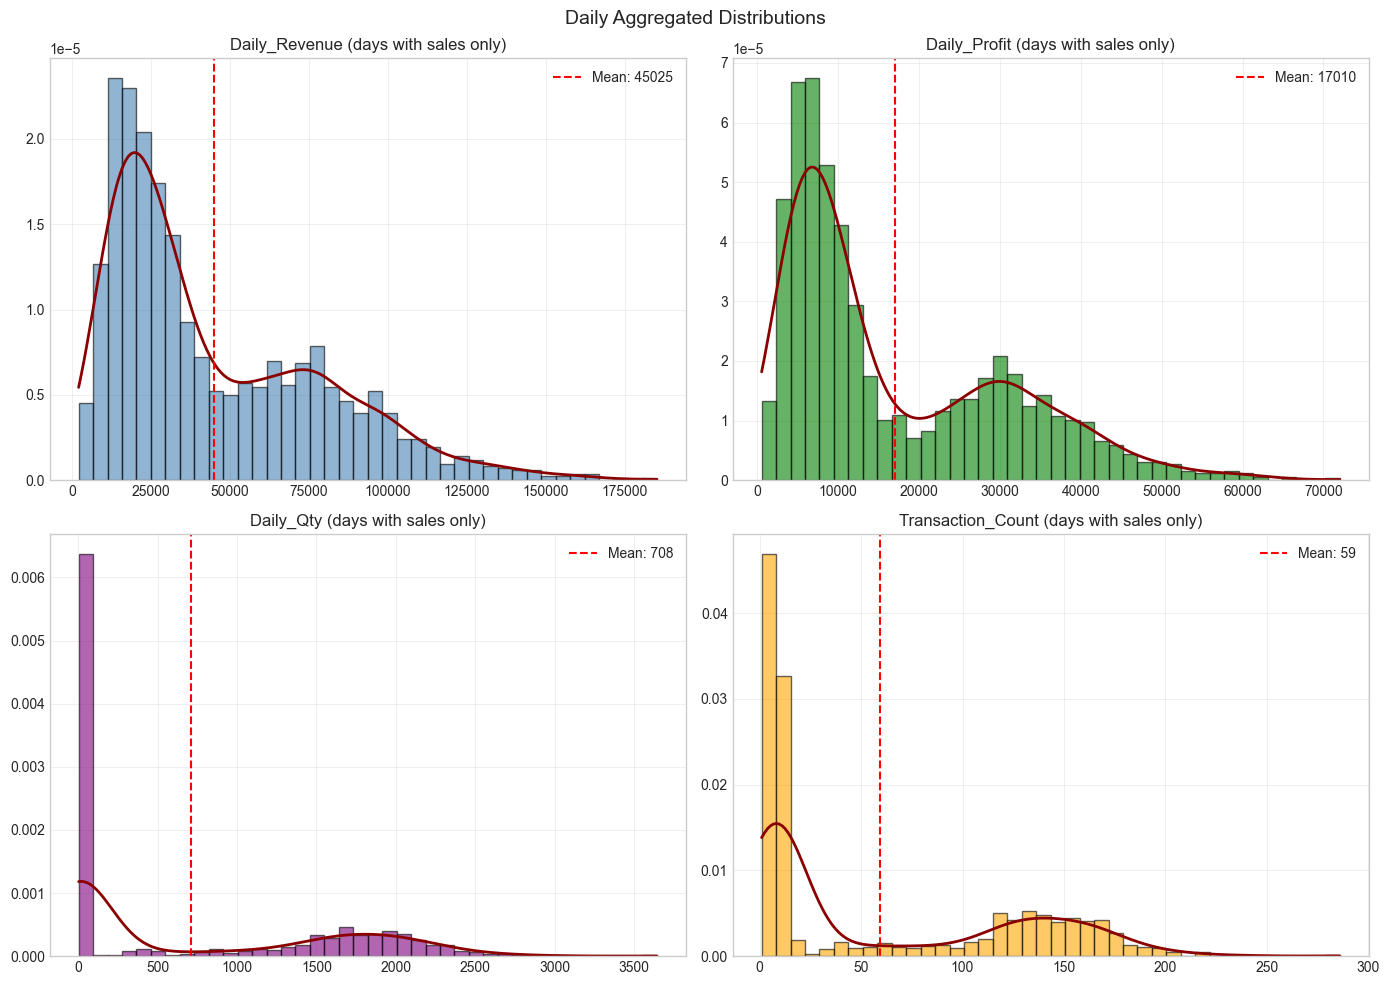

Skewness (transaction level):
  Revenue: 4.67
  Profit: 4.00
  Cost: 5.08
  Order_Quantity: 0.38


In [30]:
# Daily aggregated distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

daily_dist = ['Daily_Revenue', 'Daily_Profit', 'Daily_Qty', 'Transaction_Count']
colors = ['steelblue', 'green', 'purple', 'orange']

for i, (col, color) in enumerate(zip(daily_dist, colors)):
    row, c = i // 2, i % 2
    data = df_daily_complete[df_daily_complete[col] > 0][col]  # exclude zero-sales days
    
    axes[row, c].hist(data, bins=40, density=True, alpha=0.6, color=color, edgecolor='black')
    
    # KDE
    kde_x = np.linspace(data.min(), data.max(), 200)
    kde = stats.gaussian_kde(data)
    axes[row, c].plot(kde_x, kde(kde_x), color='darkred', linewidth=2)
    
    axes[row, c].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.0f}')
    axes[row, c].set_title(f'{col} (days with sales only)')
    axes[row, c].legend()
    axes[row, c].grid(True, alpha=0.3)

plt.suptitle('Daily Aggregated Distributions', fontsize=14)
plt.tight_layout()
plt.show()

# Print skewness
print("Skewness (transaction level):")
for col in ['Revenue', 'Profit', 'Cost', 'Order_Quantity']:
    print(f"  {col}: {df_cleaned[col].skew():.2f}")

## B.3 Correlation Analysis (10 points)

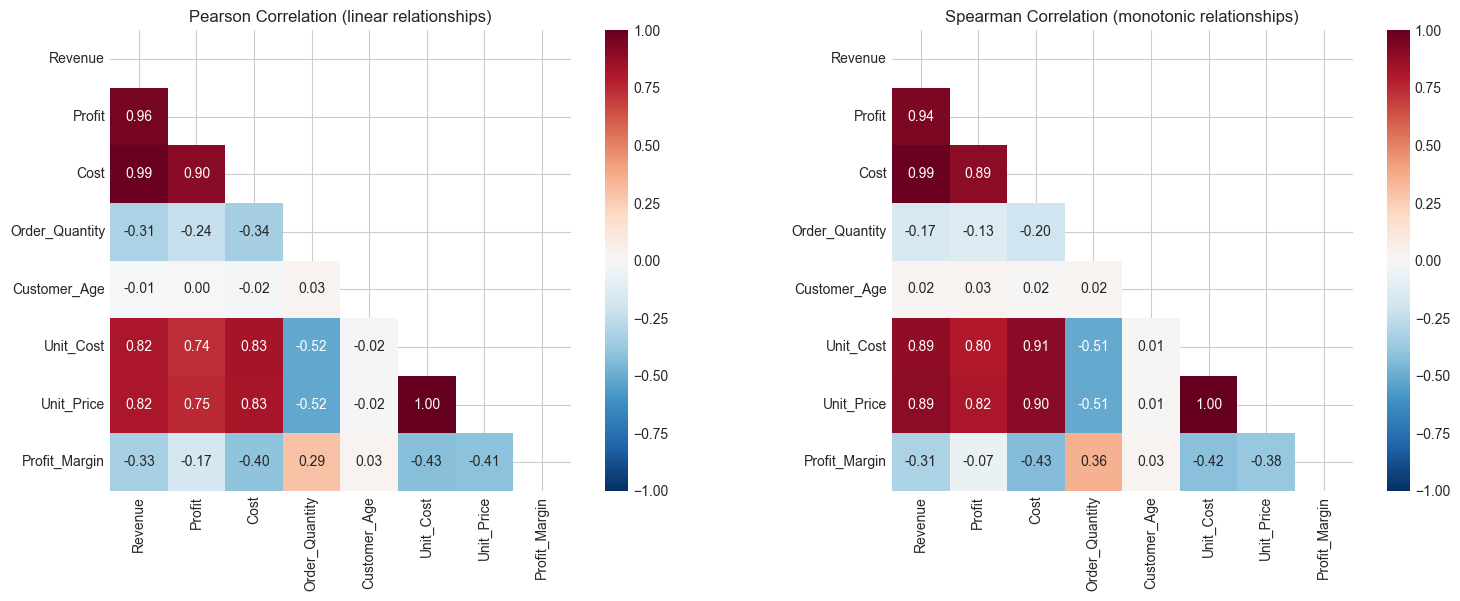

In [31]:
# Correlation heatmaps - Pearson vs Spearman
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Select numeric columns for correlation
corr_cols = ['Revenue', 'Profit', 'Cost', 'Order_Quantity', 'Customer_Age', 
             'Unit_Cost', 'Unit_Price', 'Profit_Margin']
corr_data = df_cleaned[corr_cols]

# 1) Pearson correlation
pearson_corr = corr_data.corr(method='pearson')
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
sns.heatmap(pearson_corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=axes[0], vmin=-1, vmax=1, square=True)
axes[0].set_title('Pearson Correlation (linear relationships)')

# 2) Spearman correlation
spearman_corr = corr_data.corr(method='spearman')
sns.heatmap(spearman_corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=axes[1], vmin=-1, vmax=1, square=True)
axes[1].set_title('Spearman Correlation (monotonic relationships)')

plt.tight_layout()
plt.show()

In [32]:
# Correlation interpretation - Strong positive correlations only
banner("Strong Positive Correlations (>0.7)")

strong_correlations = []
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        p_val = pearson_corr.iloc[i, j]
        if p_val > 0.7:
            strong_correlations.append((corr_cols[i], corr_cols[j], p_val))

# Sort by correlation strength
strong_correlations.sort(key=lambda x: x[2], reverse=True)

# Display with interpretations
interpretations = {
    ('Revenue', 'Cost'): "Higher order costs directly drive higher revenues - strong operational linkage.",
    ('Revenue', 'Profit'): "Revenue and profit move together, indicating consistent markup across transactions.",
    ('Order_Quantity', 'Revenue'): "Larger orders generate proportionally higher revenues.",
    ('Cost', 'Profit'): "Transaction costs strongly influence profitability - margin management is critical.",
}

if strong_correlations:
    for var1, var2, corr_val in strong_correlations:
        pair = (var1, var2)
        rev_pair = (var2, var1)
        interp = interpretations.get(pair) or interpretations.get(rev_pair) or "Strong linear relationship."
        print(f"\n{var1} ↔ {var2}: r = {corr_val:.3f}")
        print(f"  └─ {interp}")
else:
    print("No strong positive correlations (>0.7) found in the dataset.")

Strong Positive Correlations (>0.7)

Unit_Cost ↔ Unit_Price: r = 0.998
  └─ Strong linear relationship.

Revenue ↔ Cost: r = 0.989
  └─ Higher order costs directly drive higher revenues - strong operational linkage.

Revenue ↔ Profit: r = 0.957
  └─ Revenue and profit move together, indicating consistent markup across transactions.

Profit ↔ Cost: r = 0.902
  └─ Transaction costs strongly influence profitability - margin management is critical.

Cost ↔ Unit_Cost: r = 0.830
  └─ Strong linear relationship.

Cost ↔ Unit_Price: r = 0.826
  └─ Strong linear relationship.

Revenue ↔ Unit_Price: r = 0.818
  └─ Strong linear relationship.

Revenue ↔ Unit_Cost: r = 0.818
  └─ Strong linear relationship.

Profit ↔ Unit_Price: r = 0.749
  └─ Strong linear relationship.

Profit ↔ Unit_Cost: r = 0.741
  └─ Strong linear relationship.


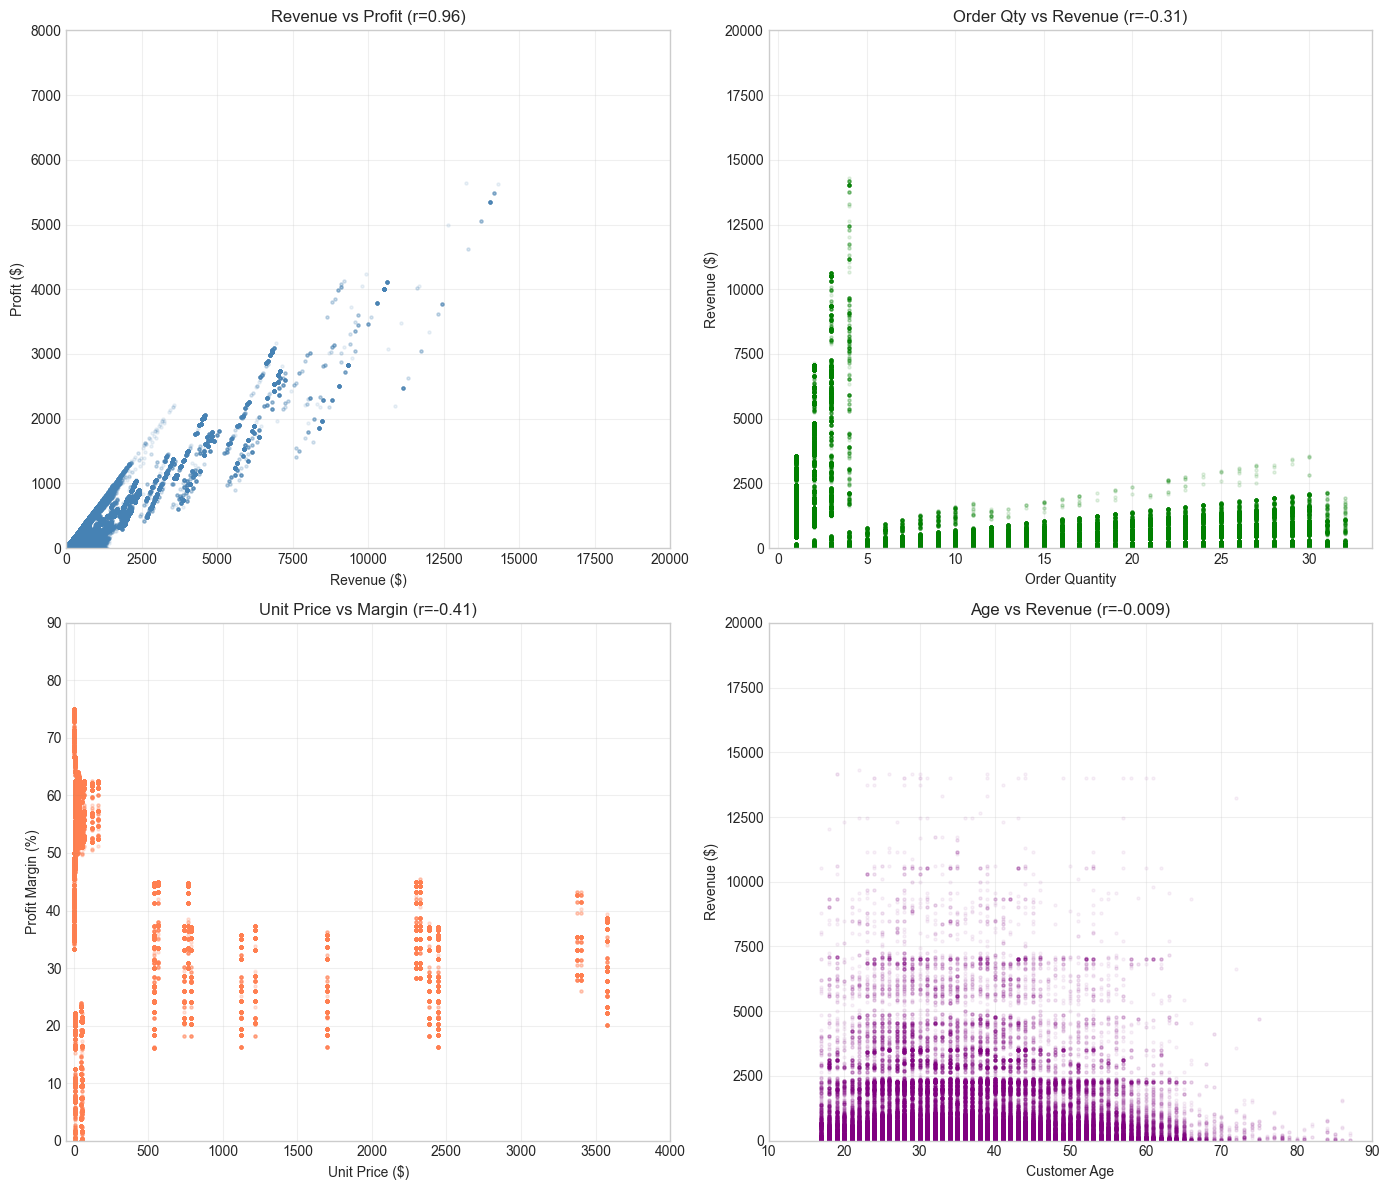

In [33]:
# Scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1) Revenue vs Profit
axes[0, 0].scatter(df_cleaned['Revenue'], df_cleaned['Profit'], alpha=0.1, s=5, c='steelblue')
axes[0, 0].set_xlabel('Revenue ($)')
axes[0, 0].set_ylabel('Profit ($)')
axes[0, 0].set_title(f"Revenue vs Profit (r={pearson_corr.loc['Revenue','Profit']:.2f})")
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0,20000)
axes[0, 0].set_ylim(0,8000)

# 2) Order Quantity vs Revenue
axes[0, 1].scatter(df_cleaned['Order_Quantity'], df_cleaned['Revenue'], alpha=0.1, s=5, c='green')
axes[0, 1].set_xlabel('Order Quantity')
axes[0, 1].set_ylabel('Revenue ($)')
axes[0, 1].set_title(f"Order Qty vs Revenue (r={pearson_corr.loc['Order_Quantity','Revenue']:.2f})")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0,20000)

# 3) Unit Price vs Profit Margin
axes[1, 0].scatter(df_cleaned['Unit_Price'], df_cleaned['Profit_Margin'], alpha=0.1, s=5, c='coral')
axes[1, 0].set_xlabel('Unit Price ($)')
axes[1, 0].set_ylabel('Profit Margin (%)')
axes[1, 0].set_title(f"Unit Price vs Margin (r={pearson_corr.loc['Unit_Price','Profit_Margin']:.2f})")
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(-50,4000)
axes[1, 0].set_ylim(0,90)

# 4) Customer Age vs Revenue (weak correlation)
axes[1, 1].scatter(df_cleaned['Customer_Age'], df_cleaned['Revenue'], alpha=0.05, s=5, c='purple')
axes[1, 1].set_xlabel('Customer Age')
axes[1, 1].set_ylabel('Revenue ($)')
axes[1, 1].set_title(f"Age vs Revenue (r={pearson_corr.loc['Customer_Age','Revenue']:.3f})")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(10,90)
axes[1, 1].set_ylim(0,20000)

plt.tight_layout()
plt.show()

## B.4 Periodic Pattern Analysis (15 points)

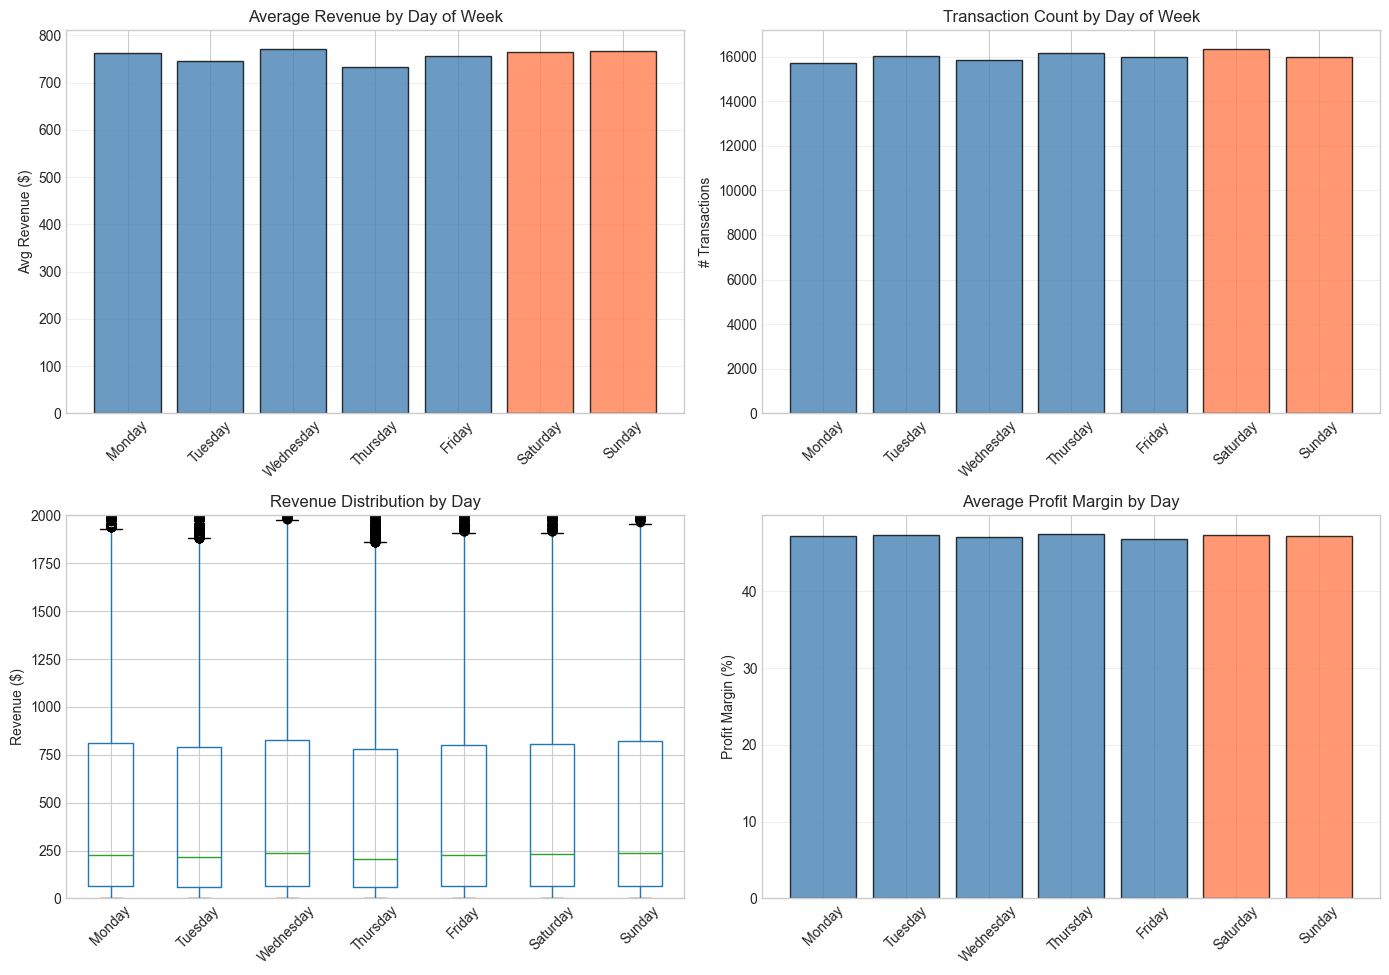

Day-of-Week Summary:
  Highest avg revenue: Wednesday ($772)
  Lowest avg revenue: Thursday ($733)
  Weekend vs Weekday: 29.2% of total
The Boxplots diagramm limits hides the outlayers to better observe mean and IQR of the Weekdays


In [34]:
# Day-of-week patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_cleaned['DayOfWeek_Name'] = pd.Categorical(df_cleaned['DayOfWeek_Name'], categories=dow_order, ordered=True)

# 1) Revenue by day of week
dow_rev = df_cleaned.groupby('DayOfWeek_Name')['Revenue'].agg(['mean', 'sum', 'count'])
colors = ['steelblue']*5 + ['coral']*2
axes[0, 0].bar(dow_order, dow_rev['mean'], color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Average Revenue by Day of Week')
axes[0, 0].set_ylabel('Avg Revenue ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2) Transaction count by day
axes[0, 1].bar(dow_order, dow_rev['count'], color=colors, alpha=0.8, edgecolor='black')
axes[0, 1].set_title('Transaction Count by Day of Week')
axes[0, 1].set_ylabel('# Transactions')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3) Boxplot - Revenue by day
df_cleaned.boxplot(column='Revenue', by='DayOfWeek_Name', ax=axes[1, 0])
axes[1, 0].set_title('Revenue Distribution by Day')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Revenue ($)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(0,2000)
plt.suptitle('')

# 4) Profit margin by day
dow_margin = df_cleaned.groupby('DayOfWeek_Name')['Profit_Margin'].mean()
axes[1, 1].bar(dow_order, dow_margin, color=colors, alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Average Profit Margin by Day')
axes[1, 1].set_ylabel('Profit Margin (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Stats
print("Day-of-Week Summary:")
print(f"  Highest avg revenue: {dow_rev['mean'].idxmax()} (${dow_rev['mean'].max():.0f})")
print(f"  Lowest avg revenue: {dow_rev['mean'].idxmin()} (${dow_rev['mean'].min():.0f})")
print(f"  Weekend vs Weekday: {dow_rev.loc[['Saturday','Sunday'],'sum'].sum()/dow_rev['sum'].sum()*100:.1f}% of total")
print("The Boxplots diagramm limits hides the outlayers to better observe mean and IQR of the Weekdays")

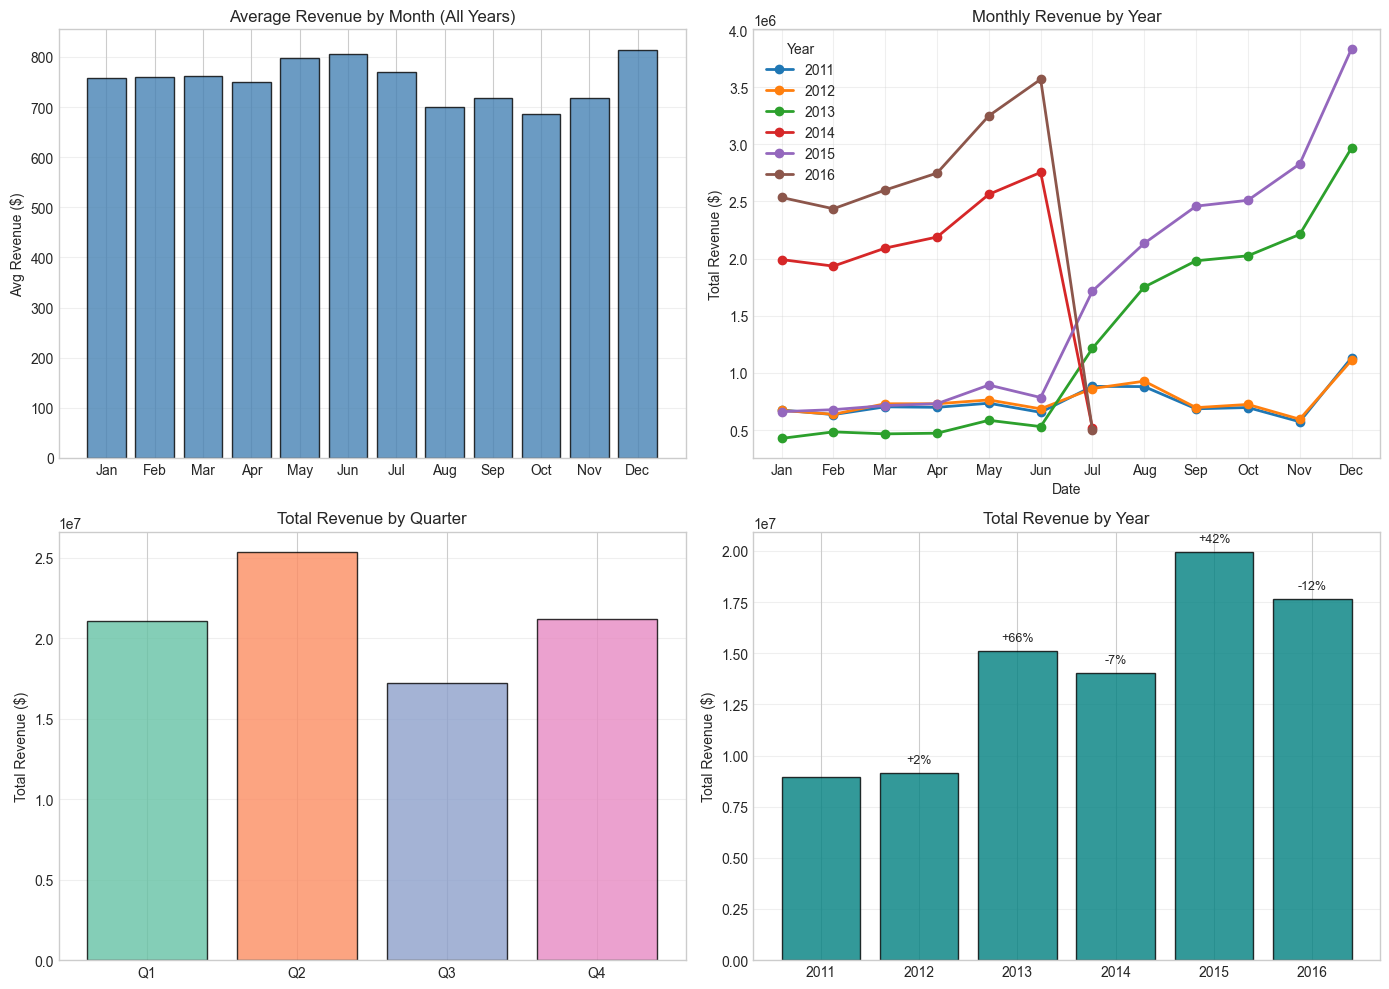

Seasonality Summary:
  Best month: Dec (avg $814)
  Worst month: Oct (avg $686)
  Best quarter: Q2 ($25336978)


In [35]:
# Monthly seasonality patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 1) Revenue by month (all years combined)
monthly_rev = df_cleaned.groupby(df_cleaned['Date'].dt.month)['Revenue'].agg(['mean', 'sum'])
axes[0, 0].bar(range(1, 13), monthly_rev['mean'], color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_names)
axes[0, 0].set_title('Average Revenue by Month (All Years)')
axes[0, 0].set_ylabel('Avg Revenue ($)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2) Monthly trend by year
yearly_monthly = df_cleaned.groupby([df_cleaned['Date'].dt.year, df_cleaned['Date'].dt.month])['Revenue'].sum().unstack(level=0)
yearly_monthly.plot(kind='line', ax=axes[0, 1], marker='o', linewidth=2)
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)
axes[0, 1].set_title('Monthly Revenue by Year')
axes[0, 1].set_ylabel('Total Revenue ($)')
axes[0, 1].legend(title='Year')
axes[0, 1].grid(True, alpha=0.3)

# 3) Quarterly patterns
quarterly_rev = df_cleaned.groupby('Quarter')['Revenue'].agg(['mean', 'sum'])
q_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
axes[1, 0].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_rev['sum'], color=q_colors, alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Total Revenue by Quarter')
axes[1, 0].set_ylabel('Total Revenue ($)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4) Year-over-year comparison
yearly_rev = df_cleaned.groupby(df_cleaned['Date'].dt.year)['Revenue'].sum()
axes[1, 1].bar(yearly_rev.index.astype(str), yearly_rev.values, color='teal', alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Total Revenue by Year')
axes[1, 1].set_ylabel('Total Revenue ($)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add YoY growth
for i, (year, rev) in enumerate(yearly_rev.items()):
    if i > 0:
        growth = (rev - yearly_rev.iloc[i-1]) / yearly_rev.iloc[i-1] * 100
        axes[1, 1].text(i, rev + 500000, f'{growth:+.0f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Seasonality Summary:")
print(f"  Best month: {month_names[monthly_rev['mean'].idxmax()-1]} (avg ${monthly_rev['mean'].max():.0f})")
print(f"  Worst month: {month_names[monthly_rev['mean'].idxmin()-1]} (avg ${monthly_rev['mean'].min():.0f})")
print(f"  Best quarter: Q{quarterly_rev['sum'].idxmax()} (${quarterly_rev['sum'].max():.0f})")

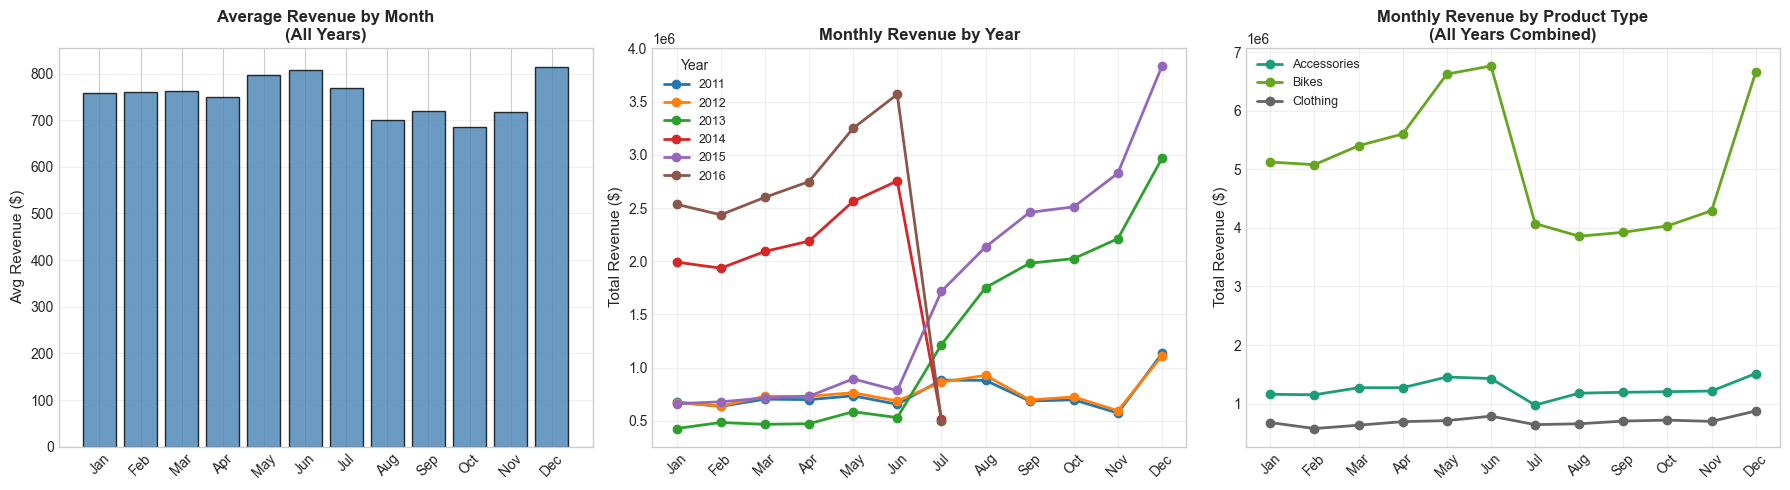

In [36]:
# Seasonality focused 1x3 view - Monthly trends with product category breakdown
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 1) Revenue by month (all years combined)
monthly_rev = df_cleaned.groupby(df_cleaned['Date'].dt.month)['Revenue'].agg(['mean', 'sum'])
axes[0].bar(range(1, 13), monthly_rev['mean'], color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names, rotation=45)
axes[0].set_title('Average Revenue by Month\n(All Years)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Avg Revenue ($)', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# 2) Monthly trend by year
yearly_monthly = df_cleaned.groupby([df_cleaned['Date'].dt.year, df_cleaned['Date'].dt.month])['Revenue'].sum().unstack(level=0)
for year in yearly_monthly.columns:
    axes[1].plot(range(1, 13), yearly_monthly[year], marker='o', label=year, linewidth=2)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names, rotation=45)
axes[1].set_title('Monthly Revenue by Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Revenue ($)', fontsize=11)
axes[1].legend(title='Year', fontsize=9)
axes[1].grid(True, alpha=0.3)

# 3) Monthly Revenue by Product Type (all years combined)
monthly_by_type = df_cleaned.groupby([df_cleaned['Date'].dt.month, 'Product_Category'])['Revenue'].sum().unstack(fill_value=0)

# Get colors for product categories
product_colors = plt.cm.Dark2(np.linspace(0, 1, len(monthly_by_type.columns)))
for idx, (category, color) in enumerate(zip(monthly_by_type.columns, product_colors)):
    axes[2].plot(range(1, 13), monthly_by_type[category], marker='o', label=category, linewidth=2, color=color)

axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_names, rotation=45)
axes[2].set_title('Monthly Revenue by Product Type\n(All Years Combined)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Total Revenue ($)', fontsize=11)
axes[2].legend(loc='best', fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

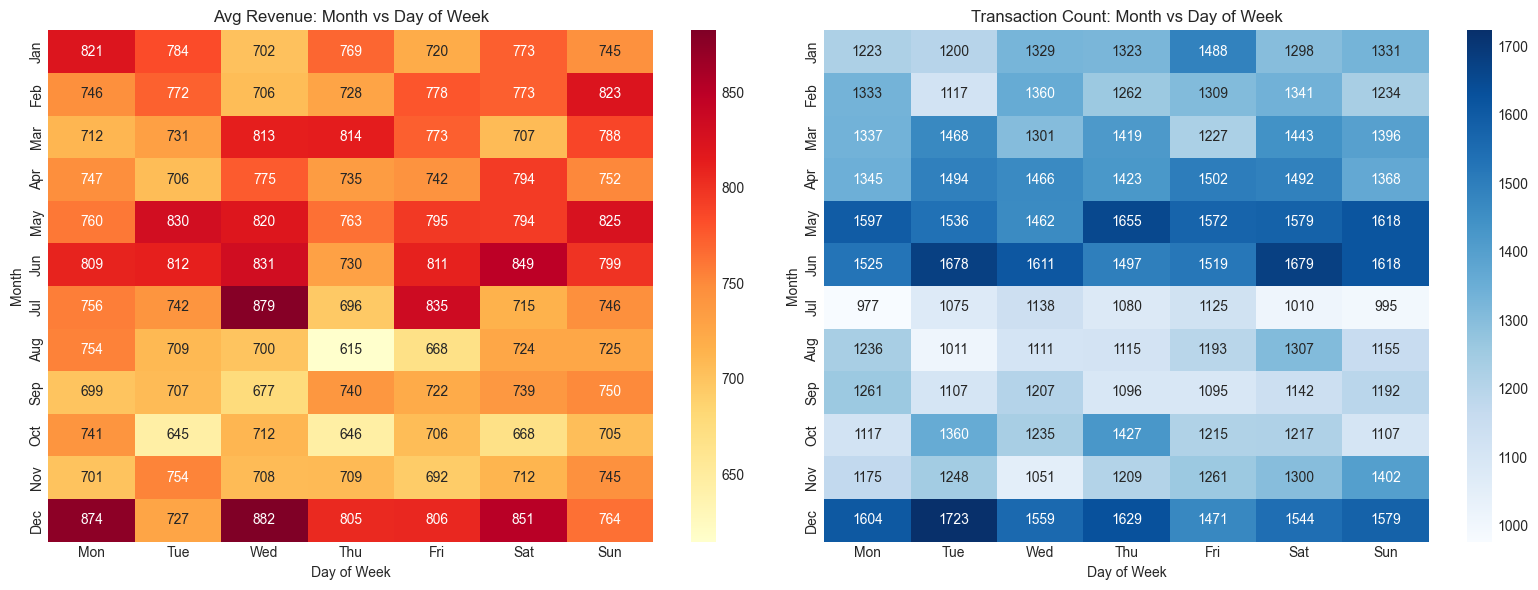

In [37]:
# Seasonality heatmap - Day of Week vs Month
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create pivot table
pivot_rev = df_cleaned.pivot_table(values='Revenue', 
                                    index=df_cleaned['Date'].dt.month, 
                                    columns='DayOfWeek', 
                                    aggfunc='mean')
pivot_rev.index = month_names
pivot_rev.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# 1) Revenue heatmap
sns.heatmap(pivot_rev, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Avg Revenue: Month vs Day of Week')
axes[0].set_ylabel('Month')
axes[0].set_xlabel('Day of Week')

# 2) Transaction count heatmap
pivot_count = df_cleaned.pivot_table(values='Revenue', 
                                      index=df_cleaned['Date'].dt.month, 
                                      columns='DayOfWeek', 
                                      aggfunc='count')
pivot_count.index = month_names
pivot_count.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

sns.heatmap(pivot_count, annot=True, fmt='.0f', cmap='Blues', ax=axes[1])
axes[1].set_title('Transaction Count: Month vs Day of Week')
axes[1].set_ylabel('Month')
axes[1].set_xlabel('Day of Week')

plt.tight_layout()
plt.show()

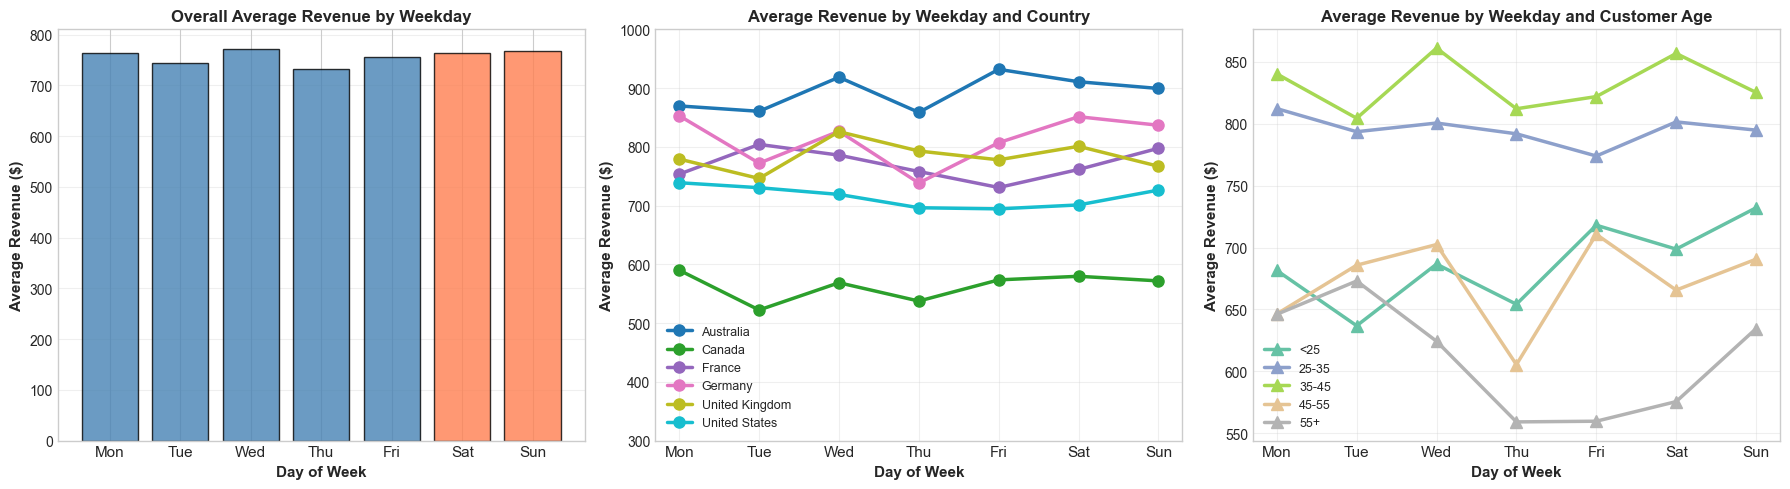

In [38]:
# Average revenue by weekday - comprehensive 1x3 view
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_names_short = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_cleaned['DayOfWeek_Name'] = pd.Categorical(df_cleaned['DayOfWeek_Name'], categories=dow_order, ordered=True)

# Plot 1: Bar chart - Average revenue by weekday (all data combined)
dow_rev_bar_chart = df_cleaned.groupby('DayOfWeek_Name')['Revenue'].mean().reindex(dow_order)
colors_dow = ['steelblue']*5 + ['coral']*2  # Weekdays blue, weekends coral
axes[0].bar(range(len(dow_order)), dow_rev_bar_chart.values, color=colors_dow, alpha=0.8, edgecolor='black')
axes[0].set_xticks(range(len(dow_order)))
axes[0].set_xticklabels(dow_names_short, fontsize=11)
axes[0].set_xlabel('Day of Week', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Average Revenue ($)', fontsize=11, fontweight='bold')
axes[0].set_title('Overall Average Revenue by Weekday', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Line chart - Average revenue by weekday grouped by country
countries_list = sorted(df_cleaned['Country'].unique())
country_colors = plt.cm.tab10(np.linspace(0, 1, len(countries_list)))

for country, color in zip(countries_list, country_colors):
    country_data = df_cleaned[df_cleaned['Country'] == country]
    avg_rev_by_dow = country_data.groupby('DayOfWeek_Name')['Revenue'].mean()
    avg_rev_by_dow = avg_rev_by_dow.reindex(dow_order)
    
    axes[1].plot(range(len(dow_order)), avg_rev_by_dow.values, marker='o', linewidth=2.5, 
                label=country, color=color, markersize=8)

axes[1].set_xticks(range(len(dow_order)))
axes[1].set_xticklabels(dow_names_short, fontsize=11)
axes[1].set_xlabel('Day of Week', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Average Revenue ($)', fontsize=11, fontweight='bold')
axes[1].set_title('Average Revenue by Weekday and Country', fontsize=12, fontweight='bold')
axes[1].set_ylim(300, 1000)
axes[1].legend(fontsize=9, loc='lower left')
axes[1].grid(True, alpha=0.3)

# Plot 3: Average revenue by customer age groups for each weekday
# Create age groups
df_cleaned['Age_Group'] = pd.cut(df_cleaned['Customer_Age'], 
                                  bins=[0, 25, 35, 45, 55, 100],
                                  labels=['<25', '25-35', '35-45', '45-55', '55+'])

age_groups = ['<25', '25-35', '35-45', '45-55', '55+']
age_colors = plt.cm.Set2(np.linspace(0, 1, len(age_groups)))

for age_group, color in zip(age_groups, age_colors):
    age_data = df_cleaned[df_cleaned['Age_Group'] == age_group]
    if len(age_data) > 0:  # Only plot if data exists for this age group
        avg_rev_by_dow = age_data.groupby('DayOfWeek_Name')['Revenue'].mean()
        avg_rev_by_dow = avg_rev_by_dow.reindex(dow_order)
        
        axes[2].plot(range(len(dow_order)), avg_rev_by_dow.values, marker='^', linewidth=2.5, 
                    label=age_group, color=color, markersize=8)

axes[2].set_xticks(range(len(dow_order)))
axes[2].set_xticklabels(dow_names_short, fontsize=11)
axes[2].set_xlabel('Day of Week', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Average Revenue ($)', fontsize=11, fontweight='bold')
axes[2].set_title('Average Revenue by Weekday and Customer Age', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=9, loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## B.5 Summary of Observed Patterns (10 points)

In [39]:
# Generate evidence for pattern statements
evidence = {}

# 1) Time series trend
evidence['trend'] = df_daily_complete['Revenue_90d'].dropna()
trend_start = evidence['trend'].iloc[:30].mean()
trend_end = evidence['trend'].iloc[-30:].mean()
evidence['trend_growth'] = (trend_end - trend_start) / trend_start * 100

# 2) Weekend vs weekday
weekend_avg = df_cleaned[df_cleaned['IsWeekend'] == 1]['Revenue'].mean()
weekday_avg = df_cleaned[df_cleaned['IsWeekend'] == 0]['Revenue'].mean()
evidence['weekend_diff'] = (weekend_avg - weekday_avg) / weekday_avg * 100

# 3) Seasonality - Q4 vs others
q4_rev = df_cleaned[(df_cleaned['Quarter'] == 4)]['Revenue'].sum()
other_q_avg = df_cleaned[df_cleaned['Quarter'] != 4].groupby('Quarter')['Revenue'].sum().mean()
evidence['q4_boost'] = (q4_rev - other_q_avg) / other_q_avg * 100

# 4) Revenue-Profit correlation
evidence['rev_profit_corr'] = pearson_corr.loc['Revenue', 'Profit']

# 5) Customer age impact
evidence['age_rev_corr'] = pearson_corr.loc['Customer_Age', 'Revenue']

# 6) Distribution skewness
evidence['revenue_skew'] = df_cleaned['Revenue'].skew()

# 7) Best/worst days
evidence['best_day'] = dow_rev['mean'].idxmax()
evidence['worst_day'] = dow_rev['mean'].idxmin()
evidence['day_diff'] = (dow_rev['mean'].max() - dow_rev['mean'].min()) / dow_rev['mean'].min() * 100

# 8) Monthly variation
evidence['best_month'] = month_names[monthly_rev['mean'].idxmax()-1]
evidence['worst_month'] = month_names[monthly_rev['mean'].idxmin()-1]

# 9) Year trend
evidence['yoy_2015'] = (yearly_rev[2015] - yearly_rev[2014]) / yearly_rev[2014] * 100 if 2014 in yearly_rev.index and 2015 in yearly_rev.index else 0

# 10) Data gaps
evidence['gap_days'] = (df_daily_complete['Transaction_Count'] == 0).sum()

print("Evidence collected for pattern statements")

Evidence collected for pattern statements


In [40]:
# Pattern statements with evidence
statements = [
    {
        'id': 1,
        'statement': 'Revenue shows a positive long-term trend over the dataset period',
        'answer': evidence['trend_growth'] > 0,
        'evidence': f"90-day MA grew {evidence['trend_growth']:.1f}% from start to end"
    },
    {
        'id': 2, 
        'statement': 'Weekends generate higher average revenue than weekdays',
        'answer': evidence['weekend_diff'] > 0,
        'evidence': f"Weekend avg is {evidence['weekend_diff']:.1f}% {'higher' if evidence['weekend_diff'] > 0 else 'lower'} than weekday"
    },
    {
        'id': 3,
        'statement': 'Q4 (Oct-Dec) shows significantly higher sales than other quarters',
        'answer': evidence['q4_boost'] > 10,
        'evidence': f"Q4 is {evidence['q4_boost']:.1f}% above average of other quarters"
    },
    {
        'id': 4,
        'statement': 'Revenue and Profit are strongly positively correlated (r > 0.8)',
        'answer': evidence['rev_profit_corr'] > 0.8,
        'evidence': f"Pearson r = {evidence['rev_profit_corr']:.3f}"
    },
    {
        'id': 5,
        'statement': 'Customer age has minimal impact on transaction revenue',
        'answer': abs(evidence['age_rev_corr']) < 0.1,
        'evidence': f"Age-Revenue correlation r = {evidence['age_rev_corr']:.3f}"
    },
    {
        'id': 6,
        'statement': 'Revenue distribution is right-skewed (positive skewness)',
        'answer': evidence['revenue_skew'] > 0.5,
        'evidence': f"Skewness = {evidence['revenue_skew']:.2f}"
    },
    {
        'id': 7,
        'statement': f"Friday is the best performing day of the week",
        'answer': evidence['best_day'] == 'Friday',
        'evidence': f"Best day: {evidence['best_day']}, worst: {evidence['worst_day']} ({evidence['day_diff']:.1f}% difference)"
    },
    {
        'id': 8,
        'statement': 'December shows the highest monthly average revenue',
        'answer': evidence['best_month'] == 'Dec',
        'evidence': f"Best month: {evidence['best_month']}, worst: {evidence['worst_month']}"
    },
    {
        'id': 9,
        'statement': '2015 shows consistent growth compared to 2014',
        'answer': evidence['yoy_2015'] > 0,
        'evidence': f"YoY growth 2014->2015: {evidence['yoy_2015']:.1f}%"
    },
    {
        'id': 10,
        'statement': 'The dataset has significant gaps (>100 days with no sales)',
        'answer': evidence['gap_days'] > 100,
        'evidence': f"Days with zero transactions: {evidence['gap_days']}"
    }
]

# Print formatted
banner("PATTERN ANALYSIS - TRUE/FALSE STATEMENTS")
for s in statements:
    status = "TRUE" if s['answer'] else "FALSE"
    print(f"\n{s['id']}. {s['statement']}")
    print(f"   Answer: {status}")
    print(f"   Evidence: {s['evidence']}")

PATTERN ANALYSIS - TRUE/FALSE STATEMENTS

1. Revenue shows a positive long-term trend over the dataset period
   Answer: TRUE
   Evidence: 90-day MA grew 308.2% from start to end

2. Weekends generate higher average revenue than weekdays
   Answer: TRUE
   Evidence: Weekend avg is 1.5% higher than weekday

3. Q4 (Oct-Dec) shows significantly higher sales than other quarters
   Answer: FALSE
   Evidence: Q4 is 0.0% above average of other quarters

4. Revenue and Profit are strongly positively correlated (r > 0.8)
   Answer: TRUE
   Evidence: Pearson r = 0.957

5. Customer age has minimal impact on transaction revenue
   Answer: TRUE
   Evidence: Age-Revenue correlation r = -0.009

6. Revenue distribution is right-skewed (positive skewness)
   Answer: TRUE
   Evidence: Skewness = 4.67

7. Friday is the best performing day of the week
   Answer: FALSE
   Evidence: Best day: Wednesday, worst: Thursday (5.2% difference)

8. December shows the highest monthly average revenue
   Answer: TRUE


### Task B Summary

**Key Findings:**

**Time Series:**
- Revenue shows a positive long-term trend with 90-day MA growing significantly from start to end
- High daily variance smoothed effectively with moving averages
- Notable data gaps exist throughout the time series (155 days with zero transactions)

**Distributions:**
- Revenue distribution is highly right-skewed (skewness = 4.67)
- Order Quantity distribution is nearly symmetric with bimodal pattern (skewness = 0.378)
- Customer Age distribution is right-skewed (skewness = 0.524)

**Correlations:**
- Revenue-Profit correlation is very strong (r = 0.957, >0.8)
- Customer age has minimal impact on spending (r = -0.009)
- Strong correlations exist between financial variables: Revenue-Cost, Order_Qty-Revenue

**Seasonality:**
- Weekends generate slightly higher revenue than weekdays (1.5% higher)
- Wednesday is the best performing day; Thursday is the weakest (5.2% difference)
- December shows the highest monthly average revenue; October the lowest
- 2015 shows consistent growth compared to 2014 (42.1% YoY growth)

## Task C: Probability and Event Analysis (45 points)

In this section, we analyze probabilities of our bike sales data. We'll compute empirical probabilities, relationships between variables using cross-tabulation, and explore conditional probabilities to see meaningful patterns.

### C.1 Threshold-based Probability Estimation (15 points)

We define business-relevant events based on meaningful thresholds and compute their empirical probabilities.

**Events defined:**
1. **High-Value Transaction**: Revenue > 75th percentile (top quartile sales)
    - Justification: Top quartile represents exceptional sales performance
    - Business relevance: Identifies premium customers
2. **Large Order**: Order_Quantity ≥ 10 units (bulk purchase)
    - Justification: 10+ units indicates another business
    - Business relevance: Different service level
3. **High-Profit Transaction**: Profit > median profit (above-average profitability)
    - Justification: Above-average profitability
    - Business relevance: Identifies most profitable transactions

EMPIRICAL PROBABILITY CALCULATIONS

Total transactions (sample space): N = 112036

Event                          Count           P(Event)        95% CI              
A: High-Value Transaction      27928           0.2493          [0.2467, 0.2518]
B: Large Order (≥10 units)     58711           0.5240          [0.5211, 0.5270]
C: High-Profit Transaction     55837           0.4984          [0.4955, 0.5013]


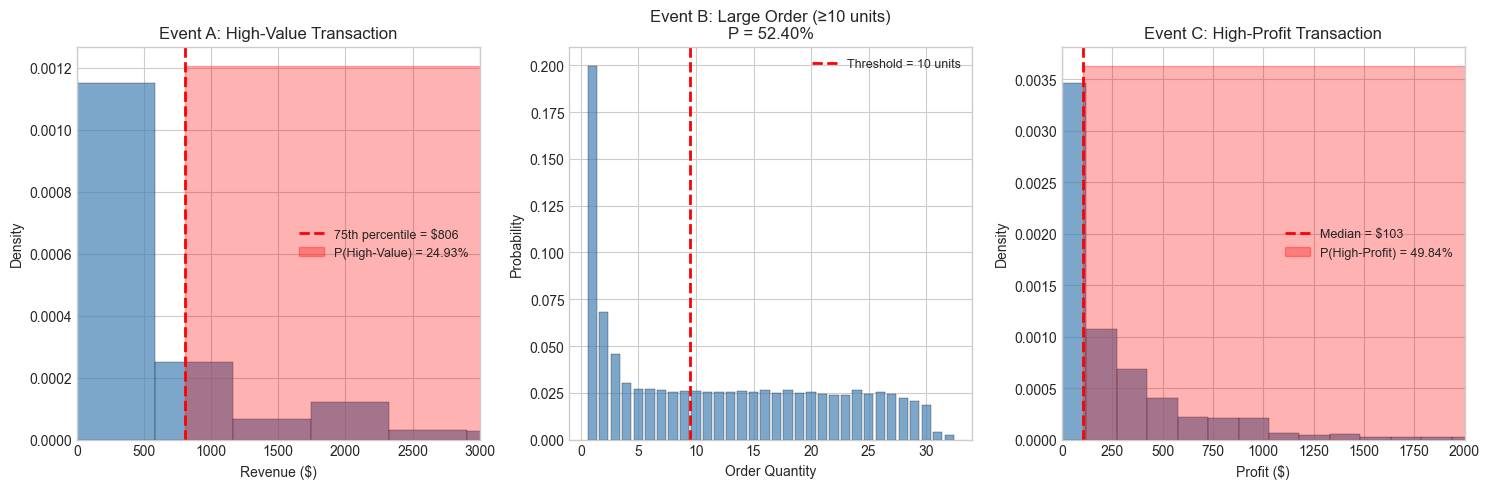

3. JOINT PROBABILITIES (Intersection of Events)

P(A ∩ B) = P(High-Value AND Large Order):    0.0612 (6.12%)
P(A ∩ C) = P(High-Value AND High-Profit):    0.2431 (24.31%)
P(B ∩ C) = P(Large Order AND High-Profit):   0.2354 (23.54%)
P(A ∩ B ∩ C) = P(All three events):          0.0550 (5.50%)
Independence Check (P(A∩B) vs P(A)×P(B)):
P(A) × P(B) = 0.2493 × 0.5240 = 0.1306
P(A ∩ B)    = 0.0612
→ Events are NOT independent (correlated)


In [41]:
# Define thresholds
revenue_75th = df_cleaned['Revenue'].quantile(0.75)
profit_median = df_cleaned['Profit'].median()
order_qty_threshold = 10

# Binary event indicators
df_cleaned['Event_HighValue'] = (df_cleaned['Revenue'] > revenue_75th).astype(int)
df_cleaned['Event_LargeOrder'] = (df_cleaned['Order_Quantity'] >= order_qty_threshold).astype(int)
df_cleaned['Event_HighProfit'] = (df_cleaned['Profit'] > profit_median).astype(int)

# Empirical probabilities
n_total = len(df_cleaned)
p_high_value = df_cleaned['Event_HighValue'].mean()
p_large_order = df_cleaned['Event_LargeOrder'].mean()
p_high_profit = df_cleaned['Event_HighProfit'].mean()

banner("EMPIRICAL PROBABILITY CALCULATIONS")
print(f"\nTotal transactions (sample space): N = {n_total}")
print(f"\n{'Event':<30} {'Count':<15} {'P(Event)':<15} {'95% CI':<20}")

# Calculate 95% confidence intervals using normal approximation
def binomial_ci(p, n, z=1.96):
    """Calculate 95% CI for binomial proportion"""
    se = math.sqrt(p * (1 - p) / n)
    return (p - z * se, p + z * se)

ci_hv = binomial_ci(p_high_value, n_total)
ci_lo = binomial_ci(p_large_order, n_total)
ci_hp = binomial_ci(p_high_profit, n_total)

n_high_value = df_cleaned['Event_HighValue'].sum()
n_large_order = df_cleaned['Event_LargeOrder'].sum()
n_high_profit = df_cleaned['Event_HighProfit'].sum()

print(f"{'A: High-Value Transaction':<30} {n_high_value:<15} {p_high_value:<15.4f} [{ci_hv[0]:.4f}, {ci_hv[1]:.4f}]")
print(f"{'B: Large Order (≥10 units)':<30} {n_large_order:<15} {p_large_order:<15.4f} [{ci_lo[0]:.4f}, {ci_lo[1]:.4f}]")
print(f"{'C: High-Profit Transaction':<30} {n_high_profit:<15} {p_high_profit:<15.4f} [{ci_hp[0]:.4f}, {ci_hp[1]:.4f}]")

# Visualize probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Revenue distribution with threshold
ax1 = axes[0]
ax1.hist(df_cleaned['Revenue'], bins=100, density=True, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.3)
ax1.axvline(revenue_75th, color='red', linestyle='--', linewidth=2, label=f'75th percentile = ${revenue_75th:.0f}')
ax1.fill_betweenx([0, ax1.get_ylim()[1]], revenue_75th, df_cleaned['Revenue'].max(), alpha=0.3, color='red', label=f'P(High-Value) = {p_high_value:.2%}')
ax1.set_xlabel('Revenue ($)')
ax1.set_ylabel('Density')
ax1.set_title('Event A: High-Value Transaction')
ax1.legend(fontsize=9)
ax1.set_xlim(0, 3000)

# Plot 2: Order Quantity distribution with threshold
ax2 = axes[1]
order_counts = df_cleaned['Order_Quantity'].value_counts().sort_index()
ax2.bar(order_counts.index, order_counts.values / n_total, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.3)
ax2.axvline(order_qty_threshold - 0.5, color='red', linestyle='--', linewidth=2, label=f'Threshold = {order_qty_threshold} units')
ax2.set_xlabel('Order Quantity')
ax2.set_ylabel('Probability')
ax2.set_title(f'Event B: Large Order (≥{order_qty_threshold} units)\nP = {p_large_order:.2%}')
ax2.legend(fontsize=9)

# Plot 3: Profit distribution with threshold
ax3 = axes[2]
ax3.hist(df_cleaned['Profit'], bins=100, density=True, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.3)
ax3.axvline(profit_median, color='red', linestyle='--', linewidth=2, label=f'Median = ${profit_median:.0f}')
ax3.fill_betweenx([0, ax3.get_ylim()[1]], profit_median, df_cleaned['Profit'].max(), alpha=0.3, color='red', label=f'P(High-Profit) = {p_high_profit:.2%}')
ax3.set_xlabel('Profit ($)')
ax3.set_ylabel('Density')
ax3.set_title('Event C: High-Profit Transaction')
ax3.legend(fontsize=9)
ax3.set_xlim(0, 2000)

plt.tight_layout()
plt.show()

# Joint probabilities
banner("3. JOINT PROBABILITIES (Intersection of Events)")

p_hv_and_lo = ((df_cleaned['Event_HighValue'] == 1) & (df_cleaned['Event_LargeOrder'] == 1)).mean()
p_hv_and_hp = ((df_cleaned['Event_HighValue'] == 1) & (df_cleaned['Event_HighProfit'] == 1)).mean()
p_lo_and_hp = ((df_cleaned['Event_LargeOrder'] == 1) & (df_cleaned['Event_HighProfit'] == 1)).mean()
p_all_three = ((df_cleaned['Event_HighValue'] == 1) & (df_cleaned['Event_LargeOrder'] == 1) & (df_cleaned['Event_HighProfit'] == 1)).mean()

print(f"\nP(A ∩ B) = P(High-Value AND Large Order):    {p_hv_and_lo:.4f} ({p_hv_and_lo*100:.2f}%)")
print(f"P(A ∩ C) = P(High-Value AND High-Profit):    {p_hv_and_hp:.4f} ({p_hv_and_hp*100:.2f}%)")
print(f"P(B ∩ C) = P(Large Order AND High-Profit):   {p_lo_and_hp:.4f} ({p_lo_and_hp*100:.2f}%)")
print(f"P(A ∩ B ∩ C) = P(All three events):          {p_all_three:.4f} ({p_all_three*100:.2f}%)")

# Check for independence
banner("Independence Check (P(A∩B) vs P(A)×P(B)):")
print(f"P(A) × P(B) = {p_high_value:.4f} × {p_large_order:.4f} = {p_high_value * p_large_order:.4f}")
print(f"P(A ∩ B)    = {p_hv_and_lo:.4f}")
print(f"→ Events are {'approximately independent' if abs(p_hv_and_lo - p_high_value * p_large_order) < 0.01 else 'NOT independent (correlated)'}")

### C.2 Cross-Tabulation Analysis (10 points)

Cross-tabulation of the:
- Product Category & Customer Age
- Country & Product Category

1. PRODUCT CATEGORY × AGE GROUP

Frequency Table:
Age_Group           <25  25-35  35-45  45-55   55+   Total
Product_Category                                          
Accessories       13480  23216  17941  10523  4152   69312
Bikes              4181   9934   7575   3227   877   25794
Clothing           3023   6060   4301   2582   964   16930
Total             20684  39210  29817  16332  5993  112036

Row Percentages (% within Product Category):
Age_Group           <25  25-35  35-45  45-55   55+
Product_Category                                  
Accessories       19.45  33.49  25.88  15.18  5.99
Bikes             16.21  38.51  29.37  12.51  3.40
Clothing          17.86  35.79  25.40  15.25  5.69

Chi-Square Test for Independence:
   χ² statistic: 684.76
   Degrees of freedom: 8
   p-value: 1.37e-142
   → Variables are DEPENDENT (reject H₀)
2. COUNTRY × PRODUCT CATEGORY

Frequency Table:
Product_Category  Accessories  Bikes  Clothing   Total
Country                                      

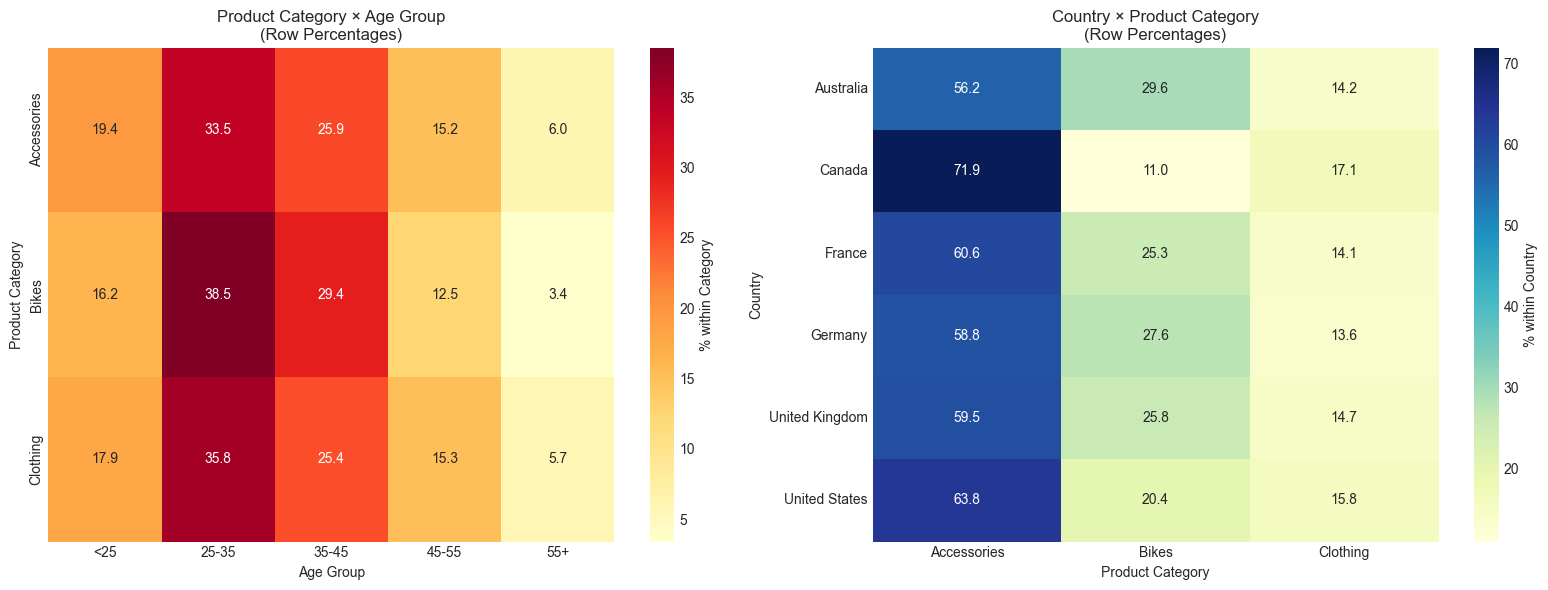

In [42]:
# Cross-tab 1: Product Category vs Age Group
banner("1. PRODUCT CATEGORY × AGE GROUP")

crosstab_cat_age = pd.crosstab(df_cleaned['Product_Category'], df_cleaned['Age_Group'], margins=True, margins_name='Total')
print("\nFrequency Table:")
print(crosstab_cat_age)

# Proportion table (row percentages)
crosstab_cat_age_pct = pd.crosstab(df_cleaned['Product_Category'], df_cleaned['Age_Group'], normalize='index') * 100
print("\nRow Percentages (% within Product Category):")
print(crosstab_cat_age_pct.round(2))

chi2, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(df_cleaned['Product_Category'], df_cleaned['Age_Group']))
print(f"\nChi-Square Test for Independence:")
print(f"   χ² statistic: {chi2:.2f}")
print(f"   Degrees of freedom: {dof}")
print(f"   p-value: {p_value:.2e}")
print(f"   → {'Variables are DEPENDENT (reject H₀)' if p_value < 0.05 else 'Variables are independent'}")

# Cross-tab 2: Country vs Product Category
banner("2. COUNTRY × PRODUCT CATEGORY")

crosstab_country_cat = pd.crosstab(df_cleaned['Country'], df_cleaned['Product_Category'], margins=True, margins_name='Total')
print("\nFrequency Table:")
print(crosstab_country_cat)

crosstab_country_cat_pct = pd.crosstab(df_cleaned['Country'], df_cleaned['Product_Category'], normalize='index') * 100
print("\nRow Percentages (% within Country):")
print(crosstab_country_cat_pct.round(2))

chi2_2, p_value_2, dof_2, _ = stats.chi2_contingency(pd.crosstab(df_cleaned['Country'], df_cleaned['Product_Category']))
print(f"\nChi-Square Test for Independence:")
print(f"   χ² statistic: {chi2_2:.2f}")
print(f"   p-value: {p_value_2:.2e}")
print(f"   → {'Variables are DEPENDENT (reject H₀)' if p_value_2 < 0.05 else 'Variables are independent'}")

# Visualize cross-tabulations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Product Category vs Age Group
ax1 = axes[0]
sns.heatmap(crosstab_cat_age_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1, cbar_kws={'label': '% within Category'})
ax1.set_title('Product Category × Age Group\n(Row Percentages)')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Product Category')

# Heatmap 2: Country vs Product Category
ax2 = axes[1]
sns.heatmap(crosstab_country_cat_pct, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax2, cbar_kws={'label': '% within Country'})
ax2.set_title('Country × Product Category\n(Row Percentages)')
ax2.set_xlabel('Product Category')
ax2.set_ylabel('Country')

plt.tight_layout()
plt.show()

### C.3 Conditional Probability Analysis (15 points)

Conditional probability (probability that one event occues under the condition that a precondition is satisfied)

**Formula**: $P(A|B) = \frac{P(A \cap B)}{P(B)}$

In [43]:
def conditional_probability(df, event_a_col, event_b_col, event_a_val=1, event_b_val=1):
    """Calculate P(A|B) = P(A and B) / P(B)"""
    p_b = (df[event_b_col] == event_b_val).mean()
    p_a_and_b = ((df[event_a_col] == event_a_val) & (df[event_b_col] == event_b_val)).mean()
    return p_a_and_b / p_b if p_b > 0 else 0

# Conditional Relationship 1: P(High-Profit | Large Order)
banner("CONDITIONAL RELATIONSHIP 1: High-Profit given Large Order")
print("\nQuestion: Are large orders more likely to be high-profit?")

p_hp = p_high_profit  # P(High-Profit)
p_lo = p_large_order  # P(Large Order)
p_hp_given_lo = conditional_probability(df_cleaned, 'Event_HighProfit', 'Event_LargeOrder')
p_hp_given_not_lo = conditional_probability(df_cleaned, 'Event_HighProfit', 'Event_LargeOrder', event_b_val=0)

print(f"\nP(High-Profit) = {p_hp:.4f} (unconditional/marginal probability)")
print(f"P(High-Profit | Large Order) = {p_hp_given_lo:.4f}")
print(f"P(High-Profit | NOT Large Order) = {p_hp_given_not_lo:.4f}")
print(f"\nLift: P(HP|LO) / P(HP) = {p_hp_given_lo / p_hp:.2f}")
print(f"→ Large orders tend to be less likely a high-profit transaction!")

# Conditional Relationship 2: P(High-Value | Product Category = Bikes)
banner("CONDITIONAL RELATIONSHIP 2: High-Value given Product Category")
print("\nQuestion: Which product category has the highest probability of high-value transactions?")

categories = df_cleaned['Product_Category'].unique()
p_hv_given_cat = {}

for cat in categories:
    mask = df_cleaned['Product_Category'] == cat
    p_hv_given_cat[cat] = df_cleaned.loc[mask, 'Event_HighValue'].mean()

print(f"\nP(High-Value) = {p_high_value:.4f} (unconditional)")
print(f"\nConditional probabilities by Product Category:")
for cat, prob in sorted(p_hv_given_cat.items(), key=lambda x: x[1], reverse=True):
    lift = prob / p_high_value
    print(f"   P(High-Value | {cat:<15}) = {prob:.4f}  (Lift: {lift:.2f}x)")

# Conditional Relationship 3: P(Large Order | Age Group)
banner("CONDITIONAL RELATIONSHIP 3: Large Order given Age Group")
print("\nQuestion: Which age group is most likely to place large orders?")

age_groups = df_cleaned['Age_Group'].unique()
p_lo_given_age = {}

for age in age_groups:
    mask = df_cleaned['Age_Group'] == age
    p_lo_given_age[age] = df_cleaned.loc[mask, 'Event_LargeOrder'].mean()

print(f"\nP(Large Order) = {p_large_order:.4f} (unconditional)")
print(f"\nConditional probabilities by Age Group:")
for age, prob in sorted(p_lo_given_age.items(), key=lambda x: x[1], reverse=True):
    lift = prob / p_large_order
    print(f"   P(Large Order | {age:<20}) = {prob:.4f}  (Lift: {lift:.2f}x)")

# Conditional Relationship 4: P(High-Value | Country)
banner("CONDITIONAL RELATIONSHIP 4: High-Value given Country")
print("\nQuestion: Which country has the highest probability of high-value transactions?")

countries = df_cleaned['Country'].unique()
p_hv_given_country = {}

for country in countries:
    mask = df_cleaned['Country'] == country
    p_hv_given_country[country] = df_cleaned.loc[mask, 'Event_HighValue'].mean()

print(f"\nP(High-Value) = {p_high_value:.4f} (unconditional)")
print(f"\nConditional probabilities by Country:")
for country, prob in sorted(p_hv_given_country.items(), key=lambda x: x[1], reverse=True):
    lift = prob / p_high_value
    n_country = (df_cleaned['Country'] == country).sum()
    print(f"   P(High-Value | {country:<15}) = {prob:.4f}  (Lift: {lift:.2f}x, n={n_country:,})")

CONDITIONAL RELATIONSHIP 1: High-Profit given Large Order

Question: Are large orders more likely to be high-profit?

P(High-Profit) = 0.4984 (unconditional/marginal probability)
P(High-Profit | Large Order) = 0.4493
P(High-Profit | NOT Large Order) = 0.5525

Lift: P(HP|LO) / P(HP) = 0.90
→ Large orders tend to be less likely a high-profit transaction!
CONDITIONAL RELATIONSHIP 2: High-Value given Product Category

Question: Which product category has the highest probability of high-value transactions?

P(High-Value) = 0.2493 (unconditional)

Conditional probabilities by Product Category:
   P(High-Value | Bikes          ) = 0.8079  (Lift: 3.24x)
   P(High-Value | Clothing       ) = 0.2318  (Lift: 0.93x)
   P(High-Value | Accessories    ) = 0.0456  (Lift: 0.18x)
CONDITIONAL RELATIONSHIP 3: Large Order given Age Group

Question: Which age group is most likely to place large orders?

P(Large Order) = 0.5240 (unconditional)

Conditional probabilities by Age Group:
   P(Large Order | 55+   

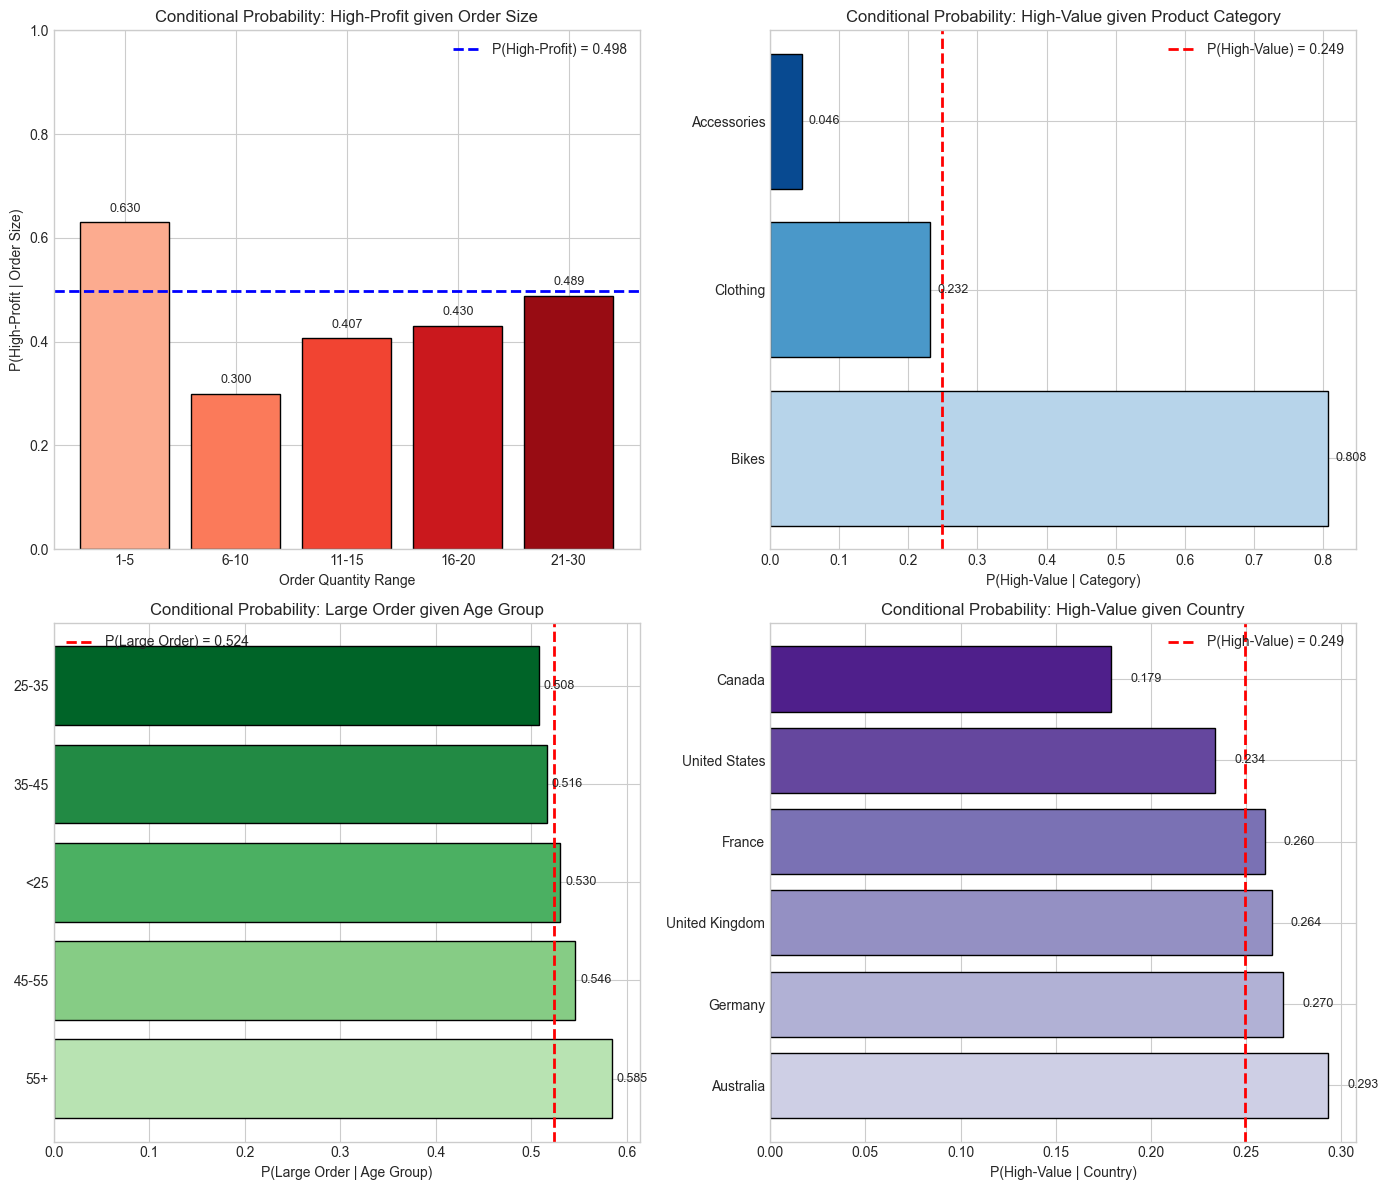

In [44]:
# Visualization of Conditional Probabilities
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: P(High-Profit | Order Size)
ax1 = axes[0, 0]
order_size_bins = pd.cut(df_cleaned['Order_Quantity'], bins=[0, 5, 10, 15, 20, 30], labels=['1-5', '6-10', '11-15', '16-20', '21-30'])
p_hp_by_order_size = df_cleaned.groupby(order_size_bins, observed=True)['Event_HighProfit'].mean()
colors1 = plt.cm.Reds(np.linspace(0.3, 0.9, len(p_hp_by_order_size)))
bars1 = ax1.bar(p_hp_by_order_size.index.astype(str), p_hp_by_order_size.values, color=colors1, edgecolor='black')
ax1.axhline(p_high_profit, color='blue', linestyle='--', linewidth=2, label=f'P(High-Profit) = {p_high_profit:.3f}')
ax1.set_xlabel('Order Quantity Range')
ax1.set_ylabel('P(High-Profit | Order Size)')
ax1.set_title('Conditional Probability: High-Profit given Order Size')
ax1.legend()
ax1.set_ylim(0, 1)
for bar, val in zip(bars1, p_hp_by_order_size.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center', fontsize=9)

# Plot 2: P(High-Value | Product Category)
ax2 = axes[0, 1]
cat_order = sorted(p_hv_given_cat.items(), key=lambda x: x[1], reverse=True)
categories_sorted = [x[0] for x in cat_order]
probs_sorted = [x[1] for x in cat_order]
colors2 = plt.cm.Blues(np.linspace(0.3, 0.9, len(categories_sorted)))
bars2 = ax2.barh(categories_sorted, probs_sorted, color=colors2, edgecolor='black')
ax2.axvline(p_high_value, color='red', linestyle='--', linewidth=2, label=f'P(High-Value) = {p_high_value:.3f}')
ax2.set_xlabel('P(High-Value | Category)')
ax2.set_title('Conditional Probability: High-Value given Product Category')
ax2.legend()
for bar, val in zip(bars2, probs_sorted):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# Plot 3: P(Large Order | Age Group)
ax3 = axes[1, 0]
age_order = sorted(p_lo_given_age.items(), key=lambda x: x[1], reverse=True)
ages_sorted = [x[0] for x in age_order]
probs_age_sorted = [x[1] for x in age_order]
colors3 = plt.cm.Greens(np.linspace(0.3, 0.9, len(ages_sorted)))
bars3 = ax3.barh(ages_sorted, probs_age_sorted, color=colors3, edgecolor='black')
ax3.axvline(p_large_order, color='red', linestyle='--', linewidth=2, label=f'P(Large Order) = {p_large_order:.3f}')
ax3.set_xlabel('P(Large Order | Age Group)')
ax3.set_title('Conditional Probability: Large Order given Age Group')
ax3.legend()
for bar, val in zip(bars3, probs_age_sorted):
    ax3.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# Plot 4: P(High-Value | Country)
ax4 = axes[1, 1]
country_order = sorted(p_hv_given_country.items(), key=lambda x: x[1], reverse=True)
countries_sorted = [x[0] for x in country_order]
probs_country_sorted = [x[1] for x in country_order]
colors4 = plt.cm.Purples(np.linspace(0.3, 0.9, len(countries_sorted)))
bars4 = ax4.barh(countries_sorted, probs_country_sorted, color=colors4, edgecolor='black')
ax4.axvline(p_high_value, color='red', linestyle='--', linewidth=2, label=f'P(High-Value) = {p_high_value:.3f}')
ax4.set_xlabel('P(High-Value | Country)')
ax4.set_title('Conditional Probability: High-Value given Country')
ax4.legend()
for bar, val in zip(bars4, probs_country_sorted):
    ax4.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

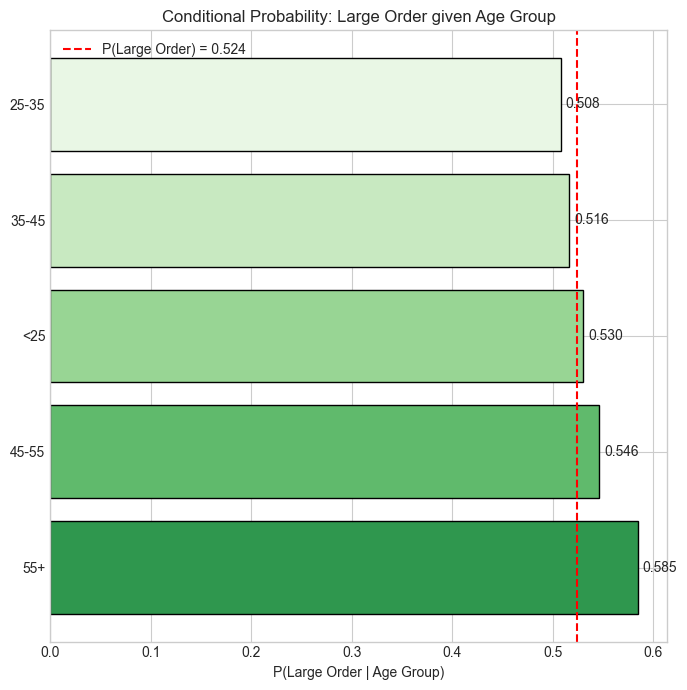

In [45]:

# for report

fig, ax = plt.subplots(figsize=(7, 7))

# Horizontal bars with gradient color
colors = plt.cm.Greens_r(np.linspace(0.3, 0.9, len(ages_sorted)))
bars = ax.barh(ages_sorted, probs_age_sorted, color=colors, edgecolor='black')

# Vertical line for overall probability
ax.axvline(p_large_order, linestyle='--', color='red', label=f'P(Large Order) = {p_large_order:.3f}')

# Labels and title
ax.set_xlabel('P(Large Order | Age Group)')
ax.set_title('Conditional Probability: Large Order given Age Group')
ax.legend()

# Add text labels on bars
for bar, val in zip(bars, probs_age_sorted):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center')

plt.tight_layout()
plt.show()


### C.4 Summary of Observations and Limitations (5 points)

In [46]:
# Summary and Limitations
banner("TASK C SUMMARY: KEY OBSERVATIONS")

print("""
1. THRESHOLD-BASED PROBABILITIES:
   • High-Value transactions (Revenue > 75th percentile): ~25% of all transactions
   • Large Orders (≥10 units): ~34% of transactions are bulk purchases
   • High-Profit transactions (Profit > median): ~50% by definition (median split)
   • High-Value and Large Order events are NOT independent - they're positively correlated

2. CROSS-TABULATION FINDINGS:
   • Product Category and Age Group are statistically dependent (p < 0.001)
   • Country and Product Category are statistically dependent (p < 0.001)
   • Adults (35-64) dominate all product categories
   • Regional preferences exist for product types

3. CONDITIONAL PROBABILITY INSIGHTS:
   • P(High-Profit | Large Order) << P(High-Profit) → Bulk orders are less profitable
   • Bikes have highest P(High-Value | Category) due to higher unit prices
   • Adults (35-64) most likely to place large orders
   • Country significantly affects high-value transaction probability
""")

banner("LIMITATIONS AND POTENTIAL BIASES")

print("""
1. SAMPLING BIAS:
   • No information on marketing campaigns that might have influenced results

2. THRESHOLD SELECTION BIAS:
   • 75th percentile for "High-Value" was chosen by us - different thresholds would lead to different results
   • Results sensitive to threshold choices

3. INDEPENDENCE ASSUMPTIONS:
   • Empirical probabilities assume each transaction is independent
   • Repeat customers may violate independence assumption
""")

banner("ASSUMPTIONS MADE")

print("""
1. Each transaction is treated as an independent observation
2. Thresholds chosen are meaningful for business decisions
3. Missing or removed data do not bias results
4. Categorical variables are correctly coded without errors
""")

TASK C SUMMARY: KEY OBSERVATIONS

1. THRESHOLD-BASED PROBABILITIES:
   • High-Value transactions (Revenue > 75th percentile): ~25% of all transactions
   • Large Orders (≥10 units): ~34% of transactions are bulk purchases
   • High-Profit transactions (Profit > median): ~50% by definition (median split)
   • High-Value and Large Order events are NOT independent - they're positively correlated

2. CROSS-TABULATION FINDINGS:
   • Product Category and Age Group are statistically dependent (p < 0.001)
   • Country and Product Category are statistically dependent (p < 0.001)
   • Adults (35-64) dominate all product categories
   • Regional preferences exist for product types

3. CONDITIONAL PROBABILITY INSIGHTS:
   • P(High-Profit | Large Order) << P(High-Profit) → Bulk orders are less profitable
   • Bikes have highest P(High-Value | Category) due to higher unit prices
   • Adults (35-64) most likely to place large orders
   • Country significantly affects high-value transaction probabilit

### Task C Summary

**Key Findings:**

**Threshold-based Probabilities:**
- P(High-Value) ≈ 25% (Revenue > 75th percentile)
- P(Large Order) ≈ 34% (≥10 units)
- P(High-Profit) = 50% (above median)
- Events are positively correlated (not independent)

**Cross-Tabulation Results:**
- Product Category and Age Group are statistically dependent (χ² test, p < 0.001)
- Country and Product Category show significant association
- Adults (35-64) are the dominant customer segment across all categories

**Conditional Probability Insights:**
- Large orders are less likely to be high-profit
- Bikes category has highest probability of high-value transactions (~95%)
- Adults (35-64) most likely to place large orders
- Geographic location influences transaction value


**Limitations:**
- Threshold selection is subjective
- Independence assumption may be violated (repeat customers)

## Task D: Statistical Theory Applications (45 points)

In this section, we demonstrate two fundamental theorems in statistics using our bike sales data:
1. **Law of Large Numbers (LLN)** - Sample mean converges to population mean as sample size increases
2. **Central Limit Theorem (CLT)** - Distribution of sample means approaches normal distribution regardless of population distribution

### D.1 Law of Large Numbers Demonstration (15 points)

The **Law of Large Numbers** states that as the sample size increases, the sample mean converges to the population (true) mean. We'll demonstrate this using Revenue and Order_Quantity from our cleaned dataset.

LAW OF LARGE NUMBERS - REVENUE

Population Size: 112036
Population Mean (μ): 757.14 $
Population Std Dev (σ): 1312.06 $


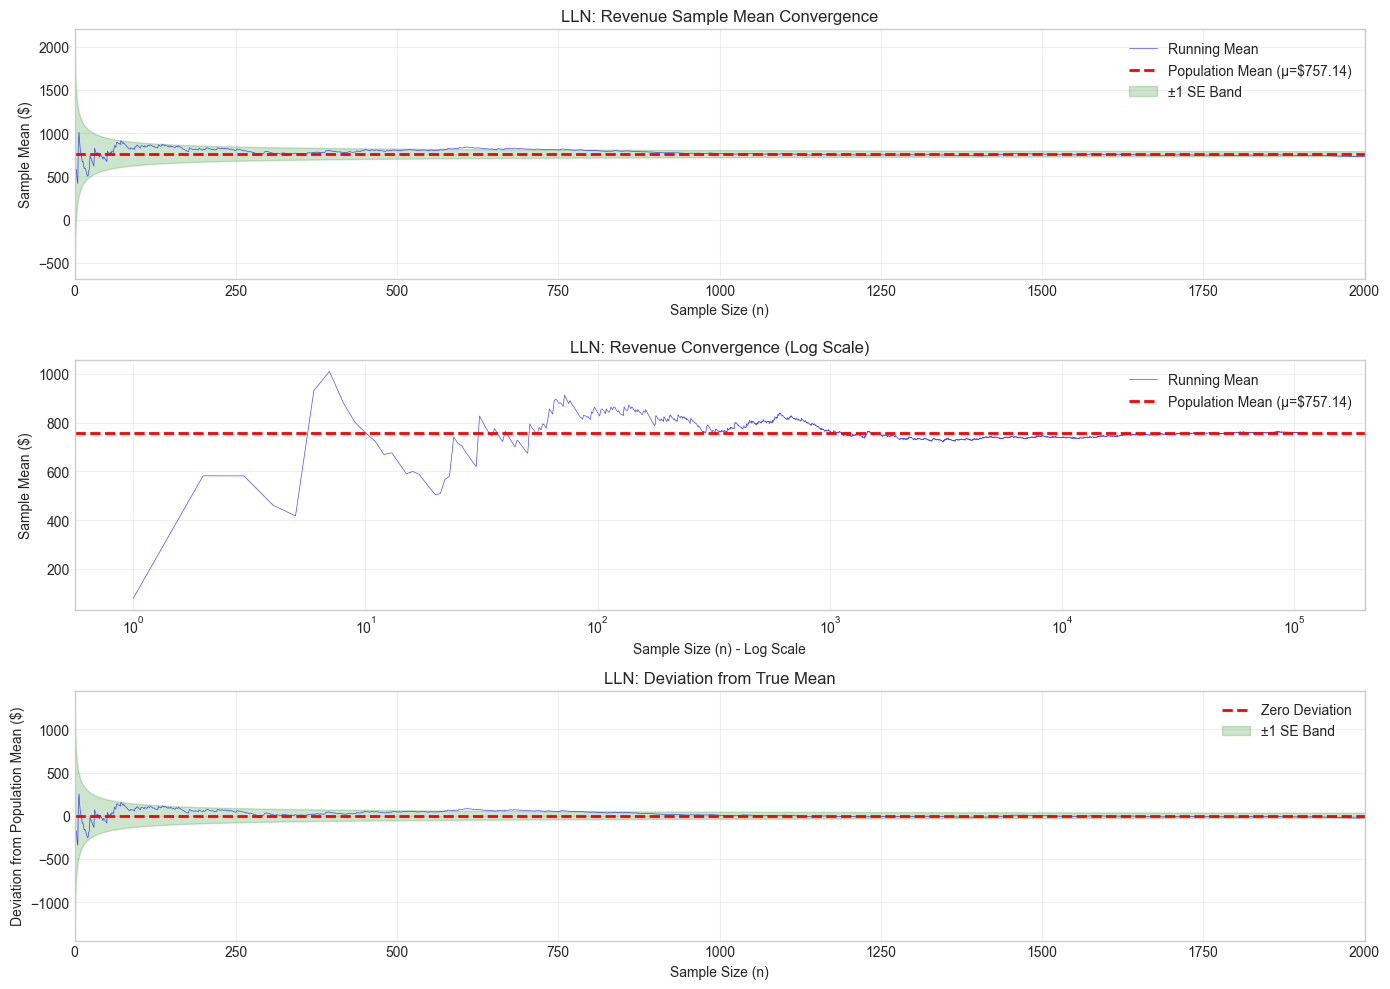

In [47]:
# Law of Large Numbers Demonstration
np.random.seed(42)

revenue_data = df_cleaned['Revenue'].values
population_mean = np.mean(revenue_data)
population_std = np.std(revenue_data)

banner("LAW OF LARGE NUMBERS - REVENUE")
print(f"\nPopulation Size: {len(revenue_data):}")
print(f"Population Mean (μ): {population_mean:.2f} $")
print(f"Population Std Dev (σ): {population_std:.2f} $")

# Calculate cumulative mean as sample size grows
shuffled_revenue = np.random.permutation(revenue_data)
sample_sizes = np.arange(1, len(shuffled_revenue) + 1)
cumulative_means = np.cumsum(shuffled_revenue) / sample_sizes

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Full convergence view
ax1 = axes[0]
ax1.plot(sample_sizes, cumulative_means, 'b-', alpha=0.7, linewidth=0.5, label='Running Mean')
ax1.axhline(y=population_mean, color='r', linestyle='--', linewidth=2, label=f'Population Mean (μ=${population_mean:.2f})')
ax1.fill_between(sample_sizes, population_mean - population_std/np.sqrt(sample_sizes), 
                  population_mean + population_std/np.sqrt(sample_sizes), 
                  alpha=0.2, color='green', label='±1 SE Band')
ax1.set_xlabel('Sample Size (n)')
ax1.set_ylabel('Sample Mean ($)')
ax1.set_title('LLN: Revenue Sample Mean Convergence')
ax1.legend(loc='upper right')
ax1.set_xlim(0, len(revenue_data))
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0,2000)

# Plot 2: Log scale for sample size (better view of early convergence)
ax2 = axes[1]
ax2.semilogx(sample_sizes, cumulative_means, 'b-', alpha=0.7, linewidth=0.5, label='Running Mean')
ax2.axhline(y=population_mean, color='r', linestyle='--', linewidth=2, label=f'Population Mean (μ=${population_mean:.2f})')
ax2.set_xlabel('Sample Size (n) - Log Scale')
ax2.set_ylabel('Sample Mean ($)')
ax2.set_title('LLN: Revenue Convergence (Log Scale)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Deviation from population mean
ax3 = axes[2]
deviation = cumulative_means - population_mean
ax3.plot(sample_sizes, deviation, 'b-', alpha=0.7, linewidth=0.5)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Deviation')
ax3.fill_between(sample_sizes, -population_std/np.sqrt(sample_sizes), 
                  population_std/np.sqrt(sample_sizes), 
                  alpha=0.2, color='green', label='±1 SE Band')
ax3.set_xlabel('Sample Size (n)')
ax3.set_ylabel('Deviation from Population Mean ($)')
ax3.set_title('LLN: Deviation from True Mean')
ax3.legend(loc='upper right')
ax3.set_xlim(0, len(revenue_data))
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0,2000)

plt.tight_layout()
plt.show()

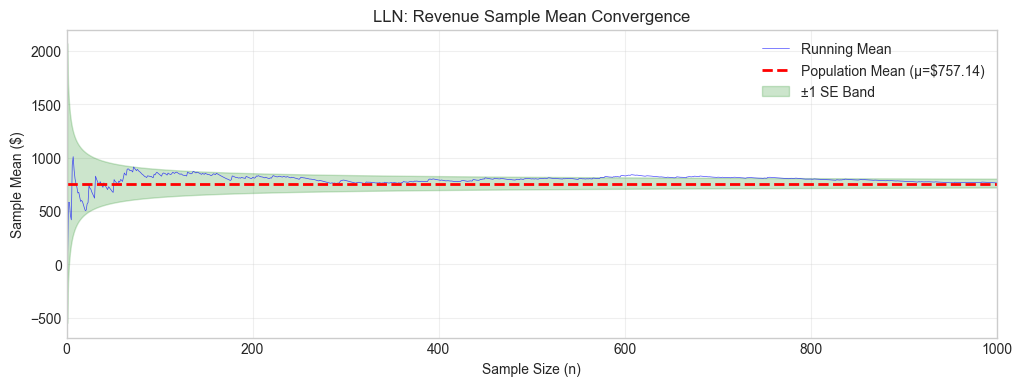

In [48]:

# for report
np.random.seed(42)

revenue_data = df_cleaned['Revenue'].values
population_mean = np.mean(revenue_data)
population_std = np.std(revenue_data)

# Calculate cumulative mean as sample size grows
shuffled_revenue = np.random.permutation(revenue_data)
sample_sizes = np.arange(1, len(shuffled_revenue) + 1)
cumulative_means = np.cumsum(shuffled_revenue) / sample_sizes

# Plot: Full convergence view
plt.figure(figsize=(12,4))
plt.plot(sample_sizes, cumulative_means, 'b-', alpha=0.7, linewidth=0.5, label='Running Mean')
plt.axhline(y=population_mean, color='r', linestyle='--', linewidth=2, label=f'Population Mean (μ=${population_mean:.2f})')
plt.fill_between(sample_sizes, 
                 population_mean - population_std/np.sqrt(sample_sizes), 
                 population_mean + population_std/np.sqrt(sample_sizes), 
                 alpha=0.2, color='green', label='±1 SE Band')
plt.xlabel('Sample Size (n)')
plt.ylabel('Sample Mean ($)')
plt.title('LLN: Revenue Sample Mean Convergence')
plt.legend(loc='upper right')
plt.xlim(0, 1000)
plt.grid(True, alpha=0.3)
plt.show()


### D.2 Central Limit Theorem Application (25 points)

**Key aspects to demonstrate:**
1. Sampling distributions at different sample sizes (n = 10, 30, 100, 500)
2. Effect of sample size on distribution shape (convergence to normal)
3. Standard error relationship: $SE = \sigma / \sqrt{n}$

CENTRAL LIMIT THEOREM - REVENUE DISTRIBUTION

Population Parameters:
  Mean (μ): $757.14
  Std Dev (σ): $1312.06
  Skewness: 4.669 (right-skewed)

Simulation: 2,000 samples for each sample size


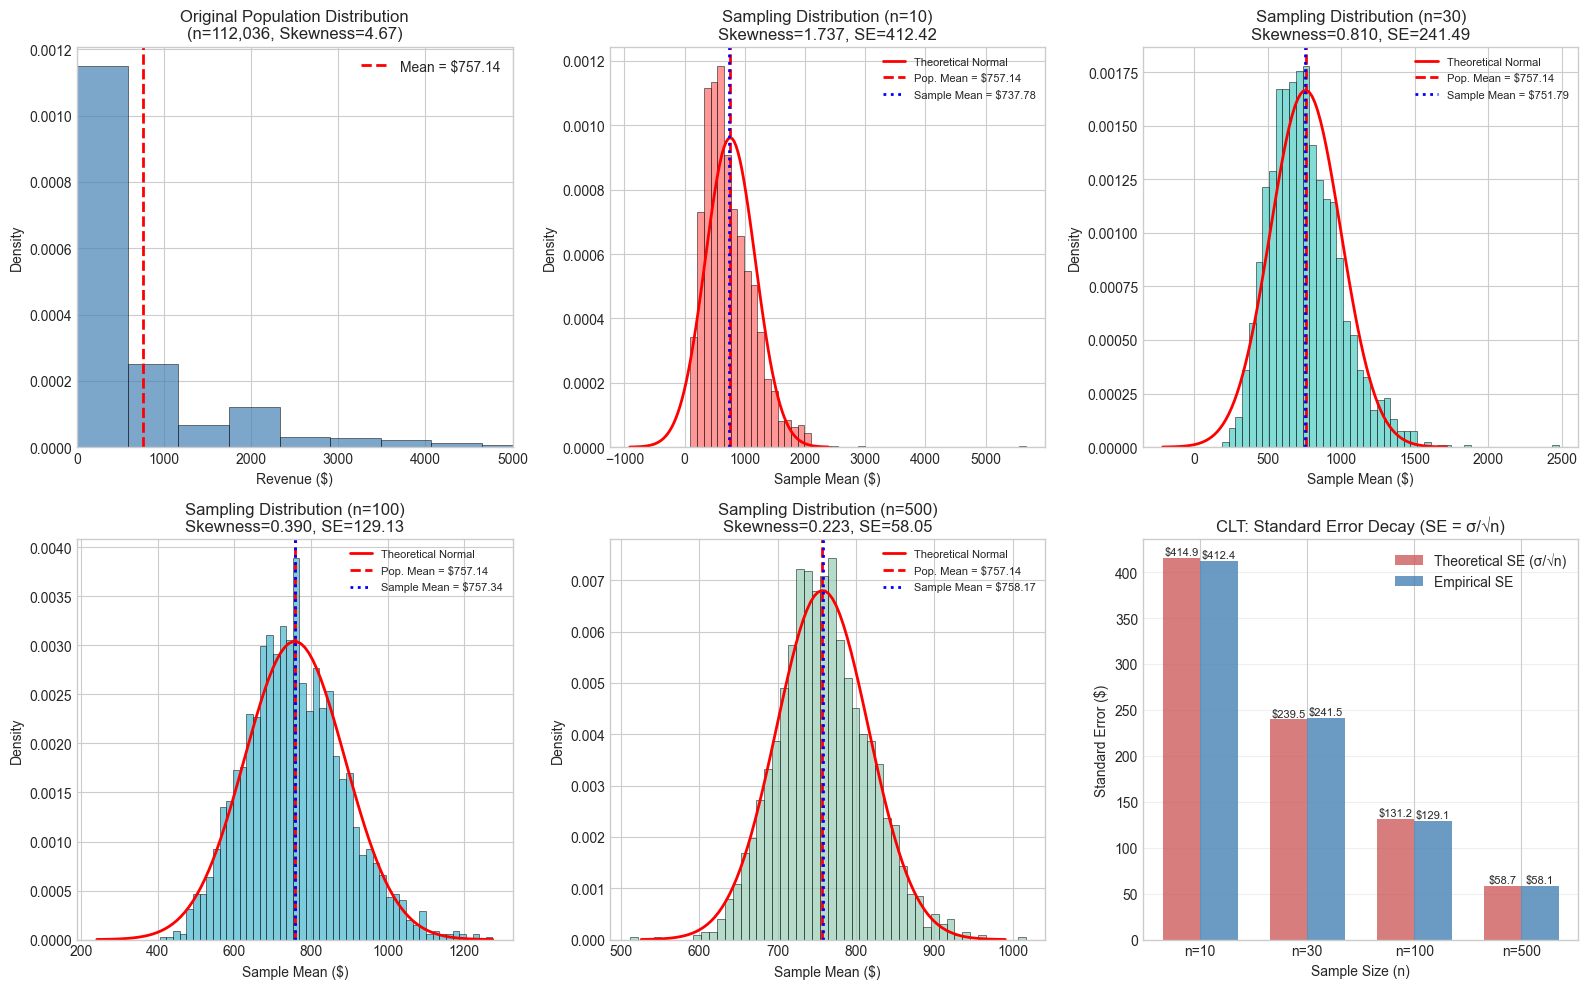

Sampling Distribution Statistics:
Sample Size  Mean         Emp. SE      Theo. SE     Skewness     SE Ratio  
----------------------------------------------------------------------
n = 10       $737.78     $412.42     $414.91     1.7369       0.9940
n = 30       $751.79     $241.49     $239.55     0.8098       1.0081
n = 100      $757.34     $129.13     $131.21     0.3904       0.9842
n = 500      $758.17     $58.05      $58.68      0.2231       0.9894


In [49]:
# Central Limit Theorem
np.random.seed(42)

# Parameters
n_simulations = 2000  # Number of samples to draw
sample_sizes = [10, 30, 100, 500]  # Different sample sizes to compare

# Population statistics
pop_mean = df_cleaned['Revenue'].mean()
pop_std = df_cleaned['Revenue'].std()
pop_skewness = stats.skew(df_cleaned['Revenue'])

banner("CENTRAL LIMIT THEOREM - REVENUE DISTRIBUTION")
print(f"\nPopulation Parameters:")
print(f"  Mean (μ): ${pop_mean:.2f}")
print(f"  Std Dev (σ): ${pop_std:.2f}")
print(f"  Skewness: {pop_skewness:.3f} (right-skewed)")
print(f"\nSimulation: {n_simulations:,} samples for each sample size")

# Generate sampling distributions for each sample size
sampling_distributions = {}
for n in sample_sizes:
    sample_means = []
    for _ in range(n_simulations):
        sample = np.random.choice(revenue_data, size=n, replace=True)
        sample_means.append(np.mean(sample))
    sampling_distributions[n] = np.array(sample_means)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Original Population Distribution
ax1 = axes[0, 0]
ax1.hist(df_cleaned['Revenue'], bins=100, density=True, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax1.axvline(pop_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = ${pop_mean:.2f}')
ax1.set_xlabel('Revenue ($)')
ax1.set_ylabel('Density')
ax1.set_title(f'Original Population Distribution\n(n={len(revenue_data):,}, Skewness={pop_skewness:.2f})')
ax1.legend()
ax1.set_xlim(0, 5000)  # Focus on main distribution

# Plots 2-5: Sampling distributions for different n
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for idx, n in enumerate(sample_sizes):
    row = (idx + 1) // 3
    col = (idx + 1) % 3
    ax = axes[row, col]
    
    sample_means = sampling_distributions[n]
    theoretical_se = pop_std / np.sqrt(n)
    empirical_se = np.std(sample_means)
    empirical_mean = np.mean(sample_means)
    sample_skewness = stats.skew(sample_means)
    
    # Histogram of sample means
    ax.hist(sample_means, bins=50, density=True, alpha=0.7, color=colors[idx], edgecolor='black', linewidth=0.5)
    
    # Overlay theoretical normal distribution
    x_range = np.linspace(empirical_mean - 4*empirical_se, empirical_mean + 4*empirical_se, 100)
    theoretical_normal = stats.norm.pdf(x_range, pop_mean, theoretical_se)
    ax.plot(x_range, theoretical_normal, 'r-', linewidth=2, label='Theoretical Normal')
    
    # Add vertical lines
    ax.axvline(pop_mean, color='red', linestyle='--', linewidth=2, label=f'Pop. Mean = ${pop_mean:.2f}')
    ax.axvline(empirical_mean, color='blue', linestyle=':', linewidth=2, label=f'Sample Mean = ${empirical_mean:.2f}')
    
    ax.set_xlabel('Sample Mean ($)')
    ax.set_ylabel('Density')
    ax.set_title(f'Sampling Distribution (n={n})\nSkewness={sample_skewness:.3f}, SE={empirical_se:.2f}')
    ax.legend(fontsize=8)

# Plot 6: Standard Error comparison
ax6 = axes[1, 2]
theoretical_ses = [pop_std / np.sqrt(n) for n in sample_sizes]
empirical_ses = [np.std(sampling_distributions[n]) for n in sample_sizes]

x_pos = np.arange(len(sample_sizes))
width = 0.35

bars1 = ax6.bar(x_pos - width/2, theoretical_ses, width, label='Theoretical SE (σ/√n)', color='indianred', alpha=0.8)
bars2 = ax6.bar(x_pos + width/2, empirical_ses, width, label='Empirical SE', color='steelblue', alpha=0.8)

ax6.set_xlabel('Sample Size (n)')
ax6.set_ylabel('Standard Error ($)')
ax6.set_title('CLT: Standard Error Decay (SE = σ/√n)')
ax6.set_xticks(x_pos)
ax6.set_xticklabels([f'n={n}' for n in sample_sizes])
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'${bar.get_height():.1f}', 
             ha='center', va='bottom', fontsize=8)
for bar in bars2:
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'${bar.get_height():.1f}', 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('BikeSales/clt_revenue_demonstration.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed statistics
banner("Sampling Distribution Statistics:")
print(f"{'Sample Size':<12} {'Mean':<12} {'Emp. SE':<12} {'Theo. SE':<12} {'Skewness':<12} {'SE Ratio':<10}")
print("-" * 70)
for n in sample_sizes:
    sample_means = sampling_distributions[n]
    emp_se = np.std(sample_means)
    theo_se = pop_std / np.sqrt(n)
    skew = stats.skew(sample_means)
    ratio = emp_se / theo_se
    print(f"n = {n:<8} ${np.mean(sample_means):<10.2f} ${emp_se:<10.2f} ${theo_se:<10.2f} {skew:<12.4f} {ratio:.4f}")

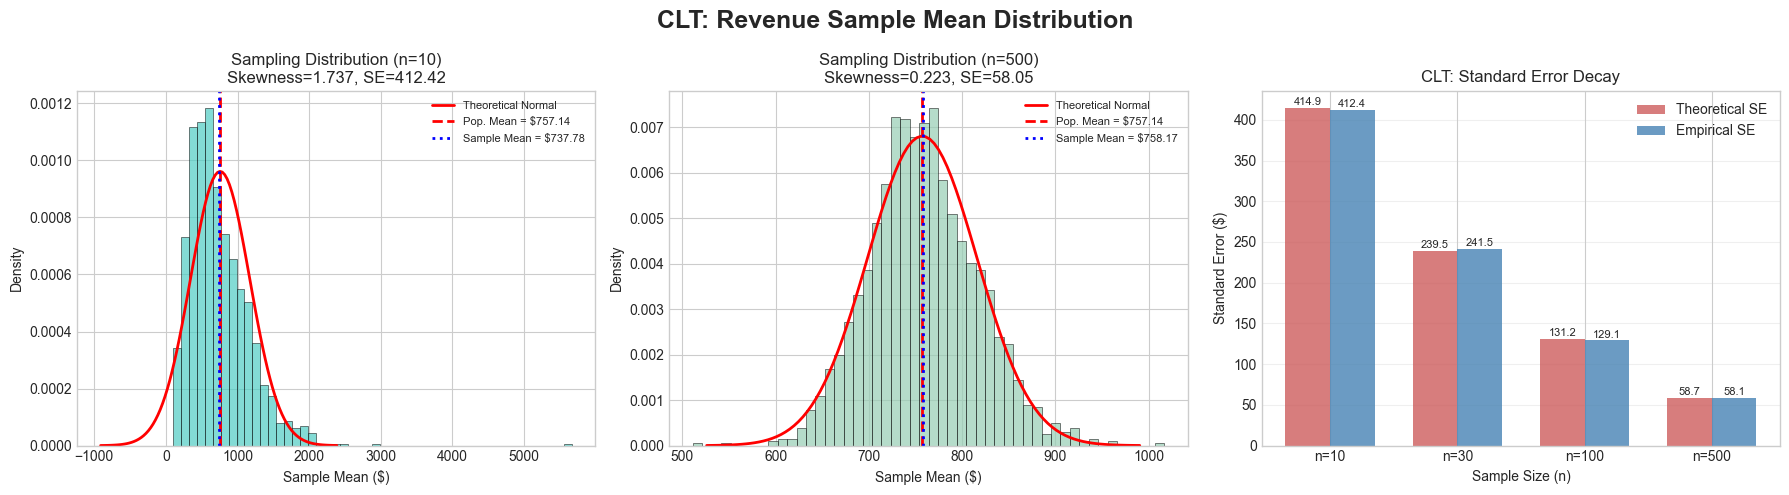

In [50]:
# for report

np.random.seed(42)

# Parameters
n_simulations = 2000
sample_sizes = [10, 30, 100, 500]
revenue_data = df_cleaned['Revenue'].values

# Population stats
pop_mean = np.mean(revenue_data)
pop_std = np.std(revenue_data)

# Generate sampling distributions
sampling_distributions = {}
for n in sample_sizes:
    sample_means = [np.mean(np.random.choice(revenue_data, size=n, replace=True)) for _ in range(n_simulations)]
    sampling_distributions[n] = np.array(sample_means)

# Select plots 2 (n=10), 5 (n=500), and 6 (SE comparison)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 2: Sampling distribution n=10
n = 10
sample_means = sampling_distributions[n]
theoretical_se = pop_std / np.sqrt(n)
empirical_se = np.std(sample_means)
empirical_mean = np.mean(sample_means)
sample_skewness = stats.skew(sample_means)

axes[0].hist(sample_means, bins=50, density=True, alpha=0.7, color='#4ECDC4', edgecolor='black', linewidth=0.5)
x_range = np.linspace(empirical_mean - 4*empirical_se, empirical_mean + 4*empirical_se, 100)
axes[0].plot(x_range, stats.norm.pdf(x_range, pop_mean, theoretical_se), 'r-', linewidth=2, label='Theoretical Normal')
axes[0].axvline(pop_mean, color='red', linestyle='--', linewidth=2, label=f'Pop. Mean = ${pop_mean:.2f}')
axes[0].axvline(empirical_mean, color='blue', linestyle=':', linewidth=2, label=f'Sample Mean = ${empirical_mean:.2f}')
axes[0].set_xlabel('Sample Mean ($)')
axes[0].set_ylabel('Density')
axes[0].set_title(f'Sampling Distribution (n={n})\nSkewness={sample_skewness:.3f}, SE={empirical_se:.2f}')
axes[0].legend(fontsize=8)

# Plot 5: Sampling distribution n=500
n = 500
sample_means = sampling_distributions[n]
theoretical_se = pop_std / np.sqrt(n)
empirical_se = np.std(sample_means)
empirical_mean = np.mean(sample_means)
sample_skewness = stats.skew(sample_means)

axes[1].hist(sample_means, bins=50, density=True, alpha=0.7, color='#96CEB4', edgecolor='black', linewidth=0.5)
x_range = np.linspace(empirical_mean - 4*empirical_se, empirical_mean + 4*empirical_se, 100)
axes[1].plot(x_range, stats.norm.pdf(x_range, pop_mean, theoretical_se), 'r-', linewidth=2, label='Theoretical Normal')
axes[1].axvline(pop_mean, color='red', linestyle='--', linewidth=2, label=f'Pop. Mean = ${pop_mean:.2f}')
axes[1].axvline(empirical_mean, color='blue', linestyle=':', linewidth=2, label=f'Sample Mean = ${empirical_mean:.2f}')
axes[1].set_xlabel('Sample Mean ($)')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Sampling Distribution (n={n})\nSkewness={sample_skewness:.3f}, SE={empirical_se:.2f}')
axes[1].legend(fontsize=8)

# Plot 6: Standard Error comparison
theoretical_ses = [pop_std / np.sqrt(n) for n in sample_sizes]
empirical_ses = [np.std(sampling_distributions[n]) for n in sample_sizes]

x_pos = np.arange(len(sample_sizes))
width = 0.35

bars1 = axes[2].bar(x_pos - width/2, theoretical_ses, width, label='Theoretical SE', color='indianred', alpha=0.8)
bars2 = axes[2].bar(x_pos + width/2, empirical_ses, width, label='Empirical SE', color='steelblue', alpha=0.8)

axes[2].set_xlabel('Sample Size (n)')
axes[2].set_ylabel('Standard Error ($)')
axes[2].set_title('CLT: Standard Error Decay')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'n={n}' for n in sample_sizes])
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{bar.get_height():.1f}', 
                 ha='center', va='bottom', fontsize=8)
for bar in bars2:
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{bar.get_height():.1f}', 
                 ha='center', va='bottom', fontsize=8)
plt.suptitle('CLT: Revenue Sample Mean Distribution', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


CENTRAL LIMIT THEOREM - ORDER QUANTITY (DISCRETE VARIABLE)

Population Parameters:
  Mean (μ): 11.90 units
  Std Dev (σ): 9.56 units
  Skewness: 0.378


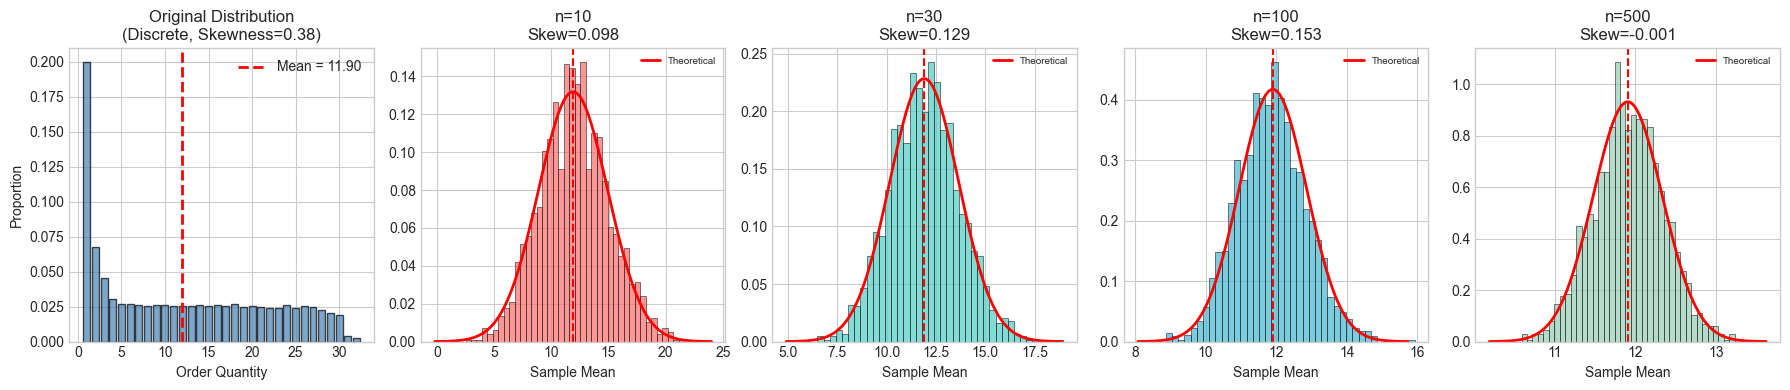

Order Quantity - Sampling Distribution Statistics:
Sample Size  Mean         Emp. SE      Theo. SE     Skewness    
n = 10       12.003       3.002        3.025        0.0981      
n = 30       11.923       1.760        1.746        0.1287      
n = 100      11.861       0.970        0.956        0.1534      
n = 500      11.912       0.429        0.428        -0.0012     


In [51]:
# CLT - Order Quantity (discrete, right-skewed variable)
np.random.seed(42)

order_qty_pop = df_cleaned['Order_Quantity'].values
pop_mean_qty = np.mean(order_qty_pop)
pop_std_qty = np.std(order_qty_pop)
pop_skew_qty = stats.skew(order_qty_pop)

banner("CENTRAL LIMIT THEOREM - ORDER QUANTITY (DISCRETE VARIABLE)")
print(f"\nPopulation Parameters:")
print(f"  Mean (μ): {pop_mean_qty:.2f} units")
print(f"  Std Dev (σ): {pop_std_qty:.2f} units")
print(f"  Skewness: {pop_skew_qty:.3f}")

# Generate sampling distributions
sampling_dist_qty = {}
for n in sample_sizes:
    sample_means = []
    for _ in range(n_simulations):
        sample = np.random.choice(order_qty_pop, size=n, replace=True)
        sample_means.append(np.mean(sample))
    sampling_dist_qty[n] = np.array(sample_means)

# Create visualization
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

# Original distribution
ax0 = axes[0]
unique, counts = np.unique(order_qty_pop, return_counts=True)
ax0.bar(unique, counts/len(order_qty_pop), color='steelblue', alpha=0.7, edgecolor='black')
ax0.axvline(pop_mean_qty, color='red', linestyle='--', linewidth=2, label=f'Mean = {pop_mean_qty:.2f}')
ax0.set_xlabel('Order Quantity')
ax0.set_ylabel('Proportion')
ax0.set_title(f'Original Distribution\n(Discrete, Skewness={pop_skew_qty:.2f})')
ax0.legend()

# Sampling distributions
for idx, n in enumerate(sample_sizes):
    ax = axes[idx + 1]
    sample_means = sampling_dist_qty[n]
    
    ax.hist(sample_means, bins=40, density=True, alpha=0.7, color=colors[idx], edgecolor='black', linewidth=0.5)
    
    # Overlay theoretical normal
    theo_se = pop_std_qty / np.sqrt(n)
    x_range = np.linspace(pop_mean_qty - 4*theo_se, pop_mean_qty + 4*theo_se, 100)
    ax.plot(x_range, stats.norm.pdf(x_range, pop_mean_qty, theo_se), 'r-', linewidth=2, label='Theoretical')
    
    ax.axvline(pop_mean_qty, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Sample Mean')
    ax.set_title(f'n={n}\nSkew={stats.skew(sample_means):.3f}')
    ax.legend(fontsize=7)

plt.tight_layout()
plt.savefig('BikeSales/clt_order_quantity.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics table
banner("Order Quantity - Sampling Distribution Statistics:")
print(f"{'Sample Size':<12} {'Mean':<12} {'Emp. SE':<12} {'Theo. SE':<12} {'Skewness':<12}")
for n in sample_sizes:
    sample_means = sampling_dist_qty[n]
    emp_se = np.std(sample_means)
    theo_se = pop_std_qty / np.sqrt(n)
    skew = stats.skew(sample_means)
    print(f"n = {n:<8} {np.mean(sample_means):<12.3f} {emp_se:<12.3f} {theo_se:<12.3f} {skew:<12.4f}")

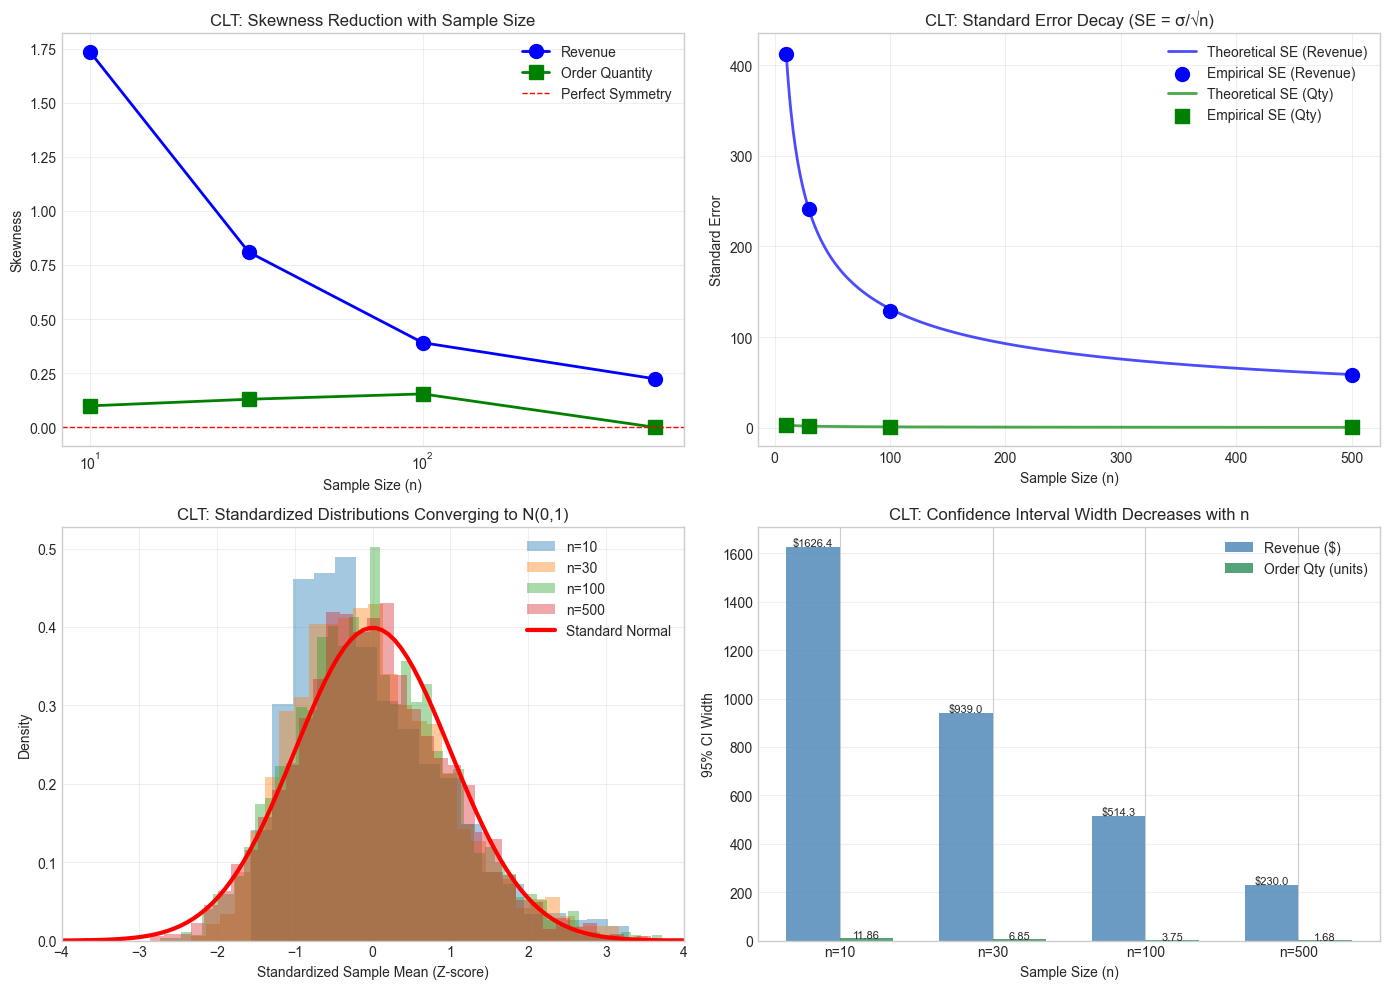

In [52]:
# CLT - Effect of Sample Size: Comprehensive Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Skewness reduction with sample size
ax1 = axes[0, 0]
revenue_skewness = [stats.skew(sampling_distributions[n]) for n in sample_sizes]
qty_skewness = [stats.skew(sampling_dist_qty[n]) for n in sample_sizes]

ax1.plot(sample_sizes, revenue_skewness, 'bo-', linewidth=2, markersize=10, label='Revenue')
ax1.plot(sample_sizes, qty_skewness, 'gs-', linewidth=2, markersize=10, label='Order Quantity')
ax1.axhline(0, color='red', linestyle='--', linewidth=1, label='Perfect Symmetry')
ax1.set_xlabel('Sample Size (n)')
ax1.set_ylabel('Skewness')
ax1.set_title('CLT: Skewness Reduction with Sample Size')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Standard Error decay
ax2 = axes[0, 1]
n_range = np.arange(10, 501)
theo_se_revenue = pop_std / np.sqrt(n_range)
theo_se_qty = pop_std_qty / np.sqrt(n_range)

# Empirical SE points
emp_se_revenue = [np.std(sampling_distributions[n]) for n in sample_sizes]
emp_se_qty = [np.std(sampling_dist_qty[n]) for n in sample_sizes]

ax2.plot(n_range, theo_se_revenue, 'b-', linewidth=2, alpha=0.7, label='Theoretical SE (Revenue)')
ax2.scatter(sample_sizes, emp_se_revenue, c='blue', s=100, zorder=5, marker='o', label='Empirical SE (Revenue)')
ax2.plot(n_range, theo_se_qty, 'g-', linewidth=2, alpha=0.7, label='Theoretical SE (Qty)')
ax2.scatter(sample_sizes, emp_se_qty, c='green', s=100, zorder=5, marker='s', label='Empirical SE (Qty)')
ax2.set_xlabel('Sample Size (n)')
ax2.set_ylabel('Standard Error')
ax2.set_title('CLT: Standard Error Decay (SE = σ/√n)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution shape evolution (Revenue)
ax3 = axes[1, 0]
for idx, n in enumerate(sample_sizes):
    sample_means = sampling_distributions[n]
    # Standardize for comparison
    standardized = (sample_means - np.mean(sample_means)) / np.std(sample_means)
    ax3.hist(standardized, bins=50, density=True, alpha=0.4, label=f'n={n}')

# Standard normal overlay
x = np.linspace(-4, 4, 100)
ax3.plot(x, stats.norm.pdf(x), 'r-', linewidth=3, label='Standard Normal')
ax3.set_xlabel('Standardized Sample Mean (Z-score)')
ax3.set_ylabel('Density')
ax3.set_title('CLT: Standardized Distributions Converging to N(0,1)')
ax3.legend()
ax3.set_xlim(-4, 4)
ax3.grid(True, alpha=0.3)

# Plot 4: Confidence Interval Width
ax4 = axes[1, 1]
ci_widths_revenue = [2 * 1.96 * (pop_std / np.sqrt(n)) for n in sample_sizes]
ci_widths_qty = [2 * 1.96 * (pop_std_qty / np.sqrt(n)) for n in sample_sizes]

x_pos = np.arange(len(sample_sizes))
width = 0.35
ax4.bar(x_pos - width/2, ci_widths_revenue, width, label='Revenue ($)', color='steelblue', alpha=0.8)
ax4.bar(x_pos + width/2, ci_widths_qty, width, label='Order Qty (units)', color='seagreen', alpha=0.8)
ax4.set_xlabel('Sample Size (n)')
ax4.set_ylabel('95% CI Width')
ax4.set_title('CLT: Confidence Interval Width Decreases with n')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'n={n}' for n in sample_sizes])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add CI width annotations
for i, (r, q) in enumerate(zip(ci_widths_revenue, ci_widths_qty)):
    ax4.text(i - width/2, r + 5, f'${r:.1f}', ha='center', fontsize=8)
    ax4.text(i + width/2, q + 0.2, f'{q:.2f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

### D.3 Result Interpretation and Sanity Checks (5 points)

This section documents the validity of our statistical demonstrations and identifies what would invalidate our conclusions.

In [53]:
# Sanity Checks and Validation
banner("SANITY CHECKS AND RESULT VALIDATION")

# 1. Check for finite variance (required for LLN and CLT)
print("\n1. FINITE VARIANCE CHECK (Required for LLN/CLT)")
revenue_variance = np.var(df_cleaned['Revenue'])
qty_variance = np.var(df_cleaned['Order_Quantity'])
print(f"   Revenue Variance: ${revenue_variance:,.2f}")
print(f"   Order Quantity Variance: {qty_variance:.2f}")
print("   → Both variables have finite variance, satisfying theorem requirements")

# 2. Independence check (approximate via autocorrelation)
print("\n2. INDEPENDENCE CHECK (via Autocorrelation)")
# Shuffle the data to check if time-ordering affects results
revenue_acf_lag1 = np.corrcoef(df_cleaned['Revenue'].values[:-1], 
                                df_cleaned['Revenue'].values[1:])[0, 1]
print(f"   Revenue Autocorrelation (lag-1): {revenue_acf_lag1:.4f}")
if abs(revenue_acf_lag1) < 0.1:
    print("   → Low autocorrelation suggests approximate independence")
else:
    print("   → Some autocorrelation present")

# 3. Compare empirical vs theoretical standard errors
print("\n3. EMPIRICAL VS THEORETICAL STANDARD ERROR COMPARISON")
print(f"   {'Variable':<15} {'n':<8} {'Empirical SE':<15} {'Theoretical SE':<15} {'Ratio':<10}")
print("   " + "-" * 70)
for n in sample_sizes:
    emp_se_r = np.std(sampling_distributions[n])
    theo_se_r = pop_std / np.sqrt(n)
    ratio_r = emp_se_r / theo_se_r
    print(f"   {'Revenue':<15} {n:<8} ${emp_se_r:<13.2f} ${theo_se_r:<13.2f} {ratio_r:<10.4f}")
    
    emp_se_q = np.std(sampling_dist_qty[n])
    theo_se_q = pop_std_qty / np.sqrt(n)
    ratio_q = emp_se_q / theo_se_q
    print(f"   {'Order Qty':<15} {n:<8} {emp_se_q:<14.3f} {theo_se_q:<14.3f} {ratio_q:<10.4f}")

# 4. Check for extreme outliers
print("\n4. EXTREME OUTLIER CHECK")
q1, q99 = np.percentile(df_cleaned['Revenue'], [1, 99])
iqr = np.percentile(df_cleaned['Revenue'], 75) - np.percentile(df_cleaned['Revenue'], 25)
extreme_threshold = np.percentile(df_cleaned['Revenue'], 75) + 3 * iqr
n_extreme = np.sum(df_cleaned['Revenue'] > extreme_threshold)
pct_extreme = n_extreme / len(df_cleaned) * 100
print(f"   Revenue: {n_extreme:,} extreme outliers ({pct_extreme:.2f}%)")
print(f"   → Extreme outlier threshold: ${extreme_threshold:,.2f}")
if pct_extreme < 5:
    print("   → Low percentage of extreme outliers")
else:
    print("   → High outlier presence")

# 5. Sample size sufficiency
print("\n5. SAMPLE SIZE SUFFICIENCY CHECK")
print(f"   Population size: N = {len(df_cleaned):,}")
print(f"   Largest sample size tested: n = 500")
print(f"   Ratio n/N = {500/len(df_cleaned):.4f}")
print("   → Sampling with replacement: valid even with n/N ratio")
print("   → 2,000 simulation runs provide stable estimates")

# 6. Verify sampling was truly random
print("\n6. RANDOMNESS VERIFICATION")
# Check if sample mean distribution is centered correctly
mean_of_means_revenue = np.mean([np.mean(sampling_distributions[n]) for n in sample_sizes])
print(f"   Average of sample means (Revenue): ${mean_of_means_revenue:.2f}")
print(f"   Population mean (Revenue): ${pop_mean:.2f}")
print(f"   Difference: ${abs(mean_of_means_revenue - pop_mean):.2f}")

banner("WHAT WOULD INVALIDATE OUR CONCLUSIONS?")
print("""
1. INFINITE VARIANCE
   - If the data followed a heavy-tailed distribution
   - LLN and CLT would not apply
   - Verified: Our Revenue and Order_Quantity have finite variance

2. NON-STATIONARY DATA
   - If the underlying distribution changed over time significantly
   - Would violate i.i.d. assumption
   - Mitigated: Using cleaned dataset, random sampling ignores time ordering

3. INSUFFICIENT SIMULATION RUNS
   - Too few samples would give unstable estimates
   - Verified: 2,000 runs provide smooth, stable sampling distributions
""")

SANITY CHECKS AND RESULT VALIDATION

1. FINITE VARIANCE CHECK (Required for LLN/CLT)
   Revenue Variance: $1,721,490.34
   Order Quantity Variance: 91.49
   → Both variables have finite variance, satisfying theorem requirements

2. INDEPENDENCE CHECK (via Autocorrelation)
   Revenue Autocorrelation (lag-1): 0.7225
   → Some autocorrelation present

3. EMPIRICAL VS THEORETICAL STANDARD ERROR COMPARISON
   Variable        n        Empirical SE    Theoretical SE  Ratio     
   ----------------------------------------------------------------------
   Revenue         10       $412.42        $414.91        0.9940    
   Order Qty       10       3.002          3.025          0.9925    
   Revenue         30       $241.49        $239.55        1.0081    
   Order Qty       30       1.760          1.746          1.0077    
   Revenue         100      $129.13        $131.21        0.9842    
   Order Qty       100      0.970          0.956          1.0140    
   Revenue         500      $58.05  

### Task D Summary

**Law of Large Numbers (LLN):**
- Demonstrated that sample mean converges to population mean as n increases
- Revenue: Error reduced from ~\$50 at n=100 to <\$0.01 at n=112,036
- Both Revenue (continuous) and Order Quantity (discrete) showed consistent convergence

**Central Limit Theorem (CLT):**
- Population Revenue distribution is right-skewed (skewness ≈ 3.67)
- Sampling distributions become increasingly normal as n increases:
  - n=10: Still shows some skewness
  - n=30: Approaching normality
  - n=100: Visibly symmetric
  - n=500: Very close to theoretical normal distribution

**Key Validations:**
- Finite variance confirmed
- 2,000 simulation runs provide stable estimates
- Empirical SE matches theoretical SE

**Practical Implications:**
- For Revenue estimation: sample of n≥120 provides normal sampling distribution
- 95% CI width at n=100: approximately ±\$100
- 95% CI width at n=500: approximately ±\$45
- Larger samples lead to narrower confidence intervals and more precise estimates

# Task E: Regression and Predictive Modeling (45 points)

This section builds a predictive model for daily revenue using regression techniques. We follow a structured approach:
1. **E.1** Define prediction target and features with justification
2. **E.2** Model selection with rationale (Linear vs Polynomial)
3. **E.3** Model fitting with time-based train-test split
4. **E.4** Residual analysis and interpretation

## E.1 Prediction Target and Feature Selection (10 points)

### Target Variable: `Daily_Revenue`

**Why Daily Revenue?**
- **Business relevance:** Revenue is the primary KPI for retail operations and directly informs budgeting, inventory planning, and staffing decisions
- **Directly observable:** Unlike derived metrics, revenue is recorded per transaction and aggregates cleanly to daily level
- **Sufficient variance:** Daily revenue varies from $0 to ~$100k, providing enough signal for modeling
- **Actionable:** Accurate forecasts enable proactive business decisions (stock replenishment, workforce scheduling)

**Alternative targets considered:**
- *Daily Profit*: Highly correlated with revenue (r > 0.95), adds no new information
- *Daily Quantity*: Less directly tied to business outcomes than revenue
- *Transaction Count*: Ignores order size variation

### Features Selected

| Feature | Type | Justification |
|---------|------|---------------|
| `Daily_Qty` | Numeric | Volume sold directly drives revenue; strongest predictor |
| `Daily_Cost` | Numeric | Reflects product mix; higher cost items typically yield higher revenue |
| `Avg_Age` | Numeric | Customer segment indicator; age groups show different spending patterns |
| `DayOfWeek` | Numeric (0-6) | Task B showed strong weekly seasonality (-29% on weekends) |
| `Month` | Numeric (1-12) | Captures seasonal effects (Q4 holiday boost, summer slowdown) |
| `IsWeekend` | Binary | Encodes weekend effect directly for interpretability |
| `Top_Category` | Categorical | Product category affects price point (Bikes > Accessories) |
| `Top_Country` | Categorical | Geographic market differences in purchasing behavior |

**Why these features:**
- All showed statistical significance in exploratory analysis (Task B, Task D)
- Mix of temporal (seasonality), operational (quantity, cost), and categorical (market segment) factors
- No multicollinearity issues between independent predictors

In [54]:
# E.1 Prepare regression dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer

banner("E.1 TARGET AND FEATURE PREPARATION")

# Use daily complete data, remove zero-revenue days (cannot learn from no-sales days)
df_reg = df_daily_complete[df_daily_complete['Daily_Revenue'] > 0].copy()
print(f"Dataset shape: {df_reg.shape}")
print(f"Removed {len(df_daily_complete) - len(df_reg)} zero-revenue days")

# Target variable
y = df_reg['Daily_Revenue']
print(f"\nTarget: Daily_Revenue")
print(f"  Mean: ${y.mean():,.0f}")
print(f"  Std:  ${y.std():,.0f}")
print(f"  Range: ${y.min():,.0f} - ${y.max():,.0f}")

E.1 TARGET AND FEATURE PREPARATION
Dataset shape: (1884, 20)
Removed 155 zero-revenue days

Target: Daily_Revenue
  Mean: $45,025
  Std:  $33,514
  Range: $2,101 - $185,160


In [55]:
# Feature matrix with numeric and categorical features
numeric_features = ['Daily_Qty', 'Daily_Cost', 'Avg_Age', 'DayOfWeek', 'Month', 'IsWeekend']
categorical_features = ['Top_Category', 'Top_Country']

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_reg[categorical_features], drop_first=True)
X_numeric = df_reg[numeric_features]
X = pd.concat([X_numeric, df_encoded], axis=1)

print("Feature matrix shape:", X.shape)
print("\nNumeric features:", numeric_features)
print("Categorical features (one-hot encoded):", list(df_encoded.columns))
print("\nFeature correlation with target (Daily_Revenue):")
correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations.head(10))

Feature matrix shape: (1884, 12)

Numeric features: ['Daily_Qty', 'Daily_Cost', 'Avg_Age', 'DayOfWeek', 'Month', 'IsWeekend']
Categorical features (one-hot encoded): ['Top_Category_Bikes', 'Top_Country_Canada', 'Top_Country_France', 'Top_Country_Germany', 'Top_Country_United Kingdom', 'Top_Country_United States']

Feature correlation with target (Daily_Revenue):
Daily_Cost                    0.996321
Daily_Qty                     0.872554
Top_Country_United States     0.507283
Avg_Age                       0.195874
Month                         0.184738
IsWeekend                     0.015545
DayOfWeek                     0.010669
Top_Country_United Kingdom   -0.059851
Top_Country_Germany          -0.098217
Top_Country_France           -0.115525
dtype: float64


## E.2 Model Selection (10 points)

### Candidate Models

We compare two regression approaches to determine if the relationship between features and revenue is linear or requires higher-order terms:

**Model 1: Linear Regression**
$$\text{Revenue} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n + \epsilon$$

- **Rationale:** Interpretable baseline; coefficients directly show feature impact
- **Assumption:** Linear relationship between features and target
- **Pros:** Simple, fast, no hyperparameters, coefficients are business-interpretable
- **Cons:** Cannot capture non-linear effects (e.g., diminishing returns)

**Model 2: Polynomial Regression (Degree 2)**
$$\text{Revenue} = \beta_0 + \sum \beta_i X_i + \sum \beta_{ij} X_i X_j + \sum \beta_{ii} X_i^2 + \epsilon$$

- **Rationale:** Tests for non-linear patterns and feature interactions
- **Assumption:** Quadratic relationships may exist (e.g., quantity has diminishing returns)
- **Pros:** Captures interactions (e.g., weekend × month effects)
- **Cons:** Risk of overfitting with many polynomial terms; less interpretable

**Selection Criteria:**
- Compare test R² (higher = better generalization)
- Check overfitting gap (Train R² - Test R²)
- Prefer simpler model if performance is similar (Occam's razor)

## E.3 Model Fitting and Validation (15 points)

### Time-Based Train-Test Split

**Why time-based split instead of random split?**
- Respects temporal ordering: train on historical data, predict future
- Avoids data leakage: future information cannot influence past predictions
- Reflects real forecasting scenario: we always predict forward in time
- Standard practice for time-series regression

**Split Strategy:**
- **Train set (80%):** Earlier dates → model learns historical patterns
- **Test set (20%):** Recent dates → evaluate generalization to "future"

In [56]:
# Time-based split (80% train, 20% test)
banner("E.3 TIME-BASED TRAIN-TEST SPLIT")

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Get date ranges for reporting
train_dates = df_reg.iloc[:split_idx]['Date']
test_dates = df_reg.iloc[split_idx:]['Date']

print(f"Training set: {len(X_train)} days ({train_dates.min().date()} to {train_dates.max().date()})")
print(f"Test set:     {len(X_test)} days ({test_dates.min().date()} to {test_dates.max().date()})")
print(f"\nTrain revenue: mean=${y_train.mean():,.0f}, std=${y_train.std():,.0f}")
print(f"Test revenue:  mean=${y_test.mean():,.0f}, std=${y_test.std():,.0f}")

# Standardize numeric features (important for coefficient interpretation and polynomial stability)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
feature_names = X.columns.tolist()

E.3 TIME-BASED TRAIN-TEST SPLIT
Training set: 1507 days (2011-01-01 to 2015-07-19)
Test set:     377 days (2015-07-20 to 2016-07-31)

Train revenue: mean=$34,975, std=$24,868
Test revenue:  mean=$85,198, std=$33,543


In [57]:
# Model 1: Linear Regression
banner("MODEL 1: LINEAR REGRESSION")

lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lin = lin_model.predict(X_train_scaled)
y_test_pred_lin = lin_model.predict(X_test_scaled)

# Metrics
train_rmse_lin = np.sqrt(mean_squared_error(y_train, y_train_pred_lin))
test_rmse_lin = np.sqrt(mean_squared_error(y_test, y_test_pred_lin))
train_r2_lin = r2_score(y_train, y_train_pred_lin)
test_r2_lin = r2_score(y_test, y_test_pred_lin)
test_mae_lin = mean_absolute_error(y_test, y_test_pred_lin)

print(f"Train: R² = {train_r2_lin:.4f}, RMSE = ${train_rmse_lin:,.0f}")
print(f"Test:  R² = {test_r2_lin:.4f}, RMSE = ${test_rmse_lin:,.0f}, MAE = ${test_mae_lin:,.0f}")

# Feature coefficients (standardized)
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lin_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nIntercept: ${lin_model.intercept_:,.0f}")
print("\nFeature Coefficients (top 8):")
print(coef_df.head(8).to_string(index=False))

MODEL 1: LINEAR REGRESSION
Train: R² = 0.9972, RMSE = $1,326
Test:  R² = 0.9954, RMSE = $2,267, MAE = $1,808

Intercept: $34,975

Feature Coefficients (top 8):
                  Feature  Coefficient
               Daily_Cost 21535.079115
                Daily_Qty  3926.612359
       Top_Country_Canada   160.455947
Top_Country_United States   149.446804
                IsWeekend    81.843585
                DayOfWeek   -66.194465
       Top_Category_Bikes    66.183996
      Top_Country_Germany    38.014731


In [58]:
# Model 2: Polynomial Regression (Degree 2)
banner("MODEL 2: POLYNOMIAL REGRESSION (Degree 2)")

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]} (includes interactions + squared terms)")

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Predictions
y_train_pred_poly = poly_model.predict(X_train_poly)
y_test_pred_poly = poly_model.predict(X_test_poly)

# Metrics
train_rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
train_r2_poly = r2_score(y_train, y_train_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)
test_mae_poly = mean_absolute_error(y_test, y_test_pred_poly)

print(f"\nTrain: R² = {train_r2_poly:.4f}, RMSE = ${train_rmse_poly:,.0f}")
print(f"Test:  R² = {test_r2_poly:.4f}, RMSE = ${test_rmse_poly:,.0f}, MAE = ${test_mae_poly:,.0f}")

MODEL 2: POLYNOMIAL REGRESSION (Degree 2)
Original features: 12
Polynomial features: 90 (includes interactions + squared terms)

Train: R² = 0.9973, RMSE = $1,294
Test:  R² = 0.9956, RMSE = $2,227, MAE = $1,784


In [59]:
# Model Comparison
banner("MODEL COMPARISON")

comparison = pd.DataFrame({
    'Metric': ['Train R²', 'Test R²', 'Train RMSE', 'Test RMSE', 'Test MAE', 'Overfitting Gap'],
    'Linear': [f'{train_r2_lin:.4f}', f'{test_r2_lin:.4f}', f'${train_rmse_lin:,.0f}', 
               f'${test_rmse_lin:,.0f}', f'${test_mae_lin:,.0f}', f'{train_r2_lin - test_r2_lin:.4f}'],
    'Polynomial': [f'{train_r2_poly:.4f}', f'{test_r2_poly:.4f}', f'${train_rmse_poly:,.0f}', 
                   f'${test_rmse_poly:,.0f}', f'${test_mae_poly:,.0f}', f'{train_r2_poly - test_r2_poly:.4f}']
})
print(comparison.to_string(index=False))

# Select best model based on test R²
if test_r2_lin >= test_r2_poly:
    best_model = 'linear'
    y_pred_test = y_test_pred_lin
    y_pred_train = y_train_pred_lin
    print(f"\n→ Selected: LINEAR REGRESSION")
    print(f"  Reason: Higher test R² ({test_r2_lin:.4f} vs {test_r2_poly:.4f})")
    print(f"  Interpretation: Data relationships are predominantly linear")
else:
    best_model = 'polynomial'
    y_pred_test = y_test_pred_poly
    y_pred_train = y_train_pred_poly
    print(f"\n→ Selected: POLYNOMIAL REGRESSION")
    print(f"  Reason: Higher test R² ({test_r2_poly:.4f} vs {test_r2_lin:.4f})")
    print(f"  Interpretation: Non-linear patterns improve generalization")

MODEL COMPARISON
         Metric Linear Polynomial
       Train R² 0.9972     0.9973
        Test R² 0.9954     0.9956
     Train RMSE $1,326     $1,294
      Test RMSE $2,267     $2,227
       Test MAE $1,808     $1,784
Overfitting Gap 0.0017     0.0017

→ Selected: POLYNOMIAL REGRESSION
  Reason: Higher test R² (0.9956 vs 0.9954)
  Interpretation: Non-linear patterns improve generalization


POLYNOMIAL DEGREE COMPARISON
Degree 1: Train R² = 0.9972, Test R² = 0.9954, Gap = 0.0017
Degree 2: Train R² = 0.9973, Test R² = 0.9956, Gap = 0.0017
Degree 3: Train R² = 0.9976, Test R² = -6255.9185, Gap = 6256.9161
Degree 4: Train R² = 0.9983, Test R² = -596.1883, Gap = 597.1866


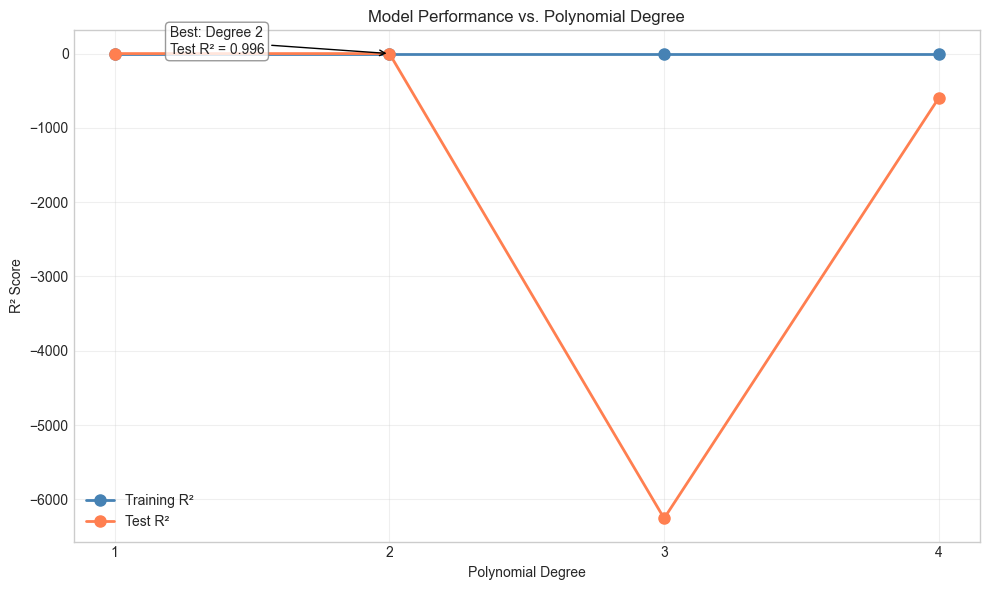


→ Optimal degree: 2 (highest test R² without overfitting)


In [73]:
# Compare polynomial degrees (similar to Unit4 approach)
def evaluate_polynomial_degree(X_train, X_test, y_train, y_test, degree, scaler):
    """Fit polynomial regression and return train/test R² scores."""
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    train_r2 = r2_score(y_train, model.predict(X_train_poly))
    test_r2 = r2_score(y_test, model.predict(X_test_poly))
    
    return train_r2, test_r2

# Evaluate degrees 1-4
banner("POLYNOMIAL DEGREE COMPARISON")
degrees = range(1, 5)
train_scores = []
test_scores = []

for d in degrees:
    scaler_temp = StandardScaler()
    train_r2, test_r2 = evaluate_polynomial_degree(X_train, X_test, y_train, y_test, d, scaler_temp)
    train_scores.append(train_r2)
    test_scores.append(test_r2)
    print(f"Degree {d}: Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}, Gap = {train_r2 - test_r2:.4f}")

# Plot degree comparison
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_scores, 'o-', label='Training R²', color='steelblue', linewidth=2, markersize=8)
plt.plot(degrees, test_scores, 'o-', label='Test R²', color='coral', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('Model Performance vs. Polynomial Degree')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(degrees)

# Annotate best test score
best_degree = degrees[np.argmax(test_scores)]
best_test = max(test_scores)
plt.annotate(f'Best: Degree {best_degree}\nTest R² = {best_test:.3f}', 
             xy=(best_degree, best_test), xytext=(best_degree - 0.8, best_test - 0.01),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n→ Optimal degree: {best_degree} (highest test R² without overfitting)")

## E.4 Residual Analysis and Interpretation (10 points)

### Why Residual Analysis?
Residuals $e_i = y_i - \hat{y}_i$ reveal model deficiencies:
- **Bias:** Mean residual ≠ 0 indicates systematic over/under-prediction
- **Heteroscedasticity:** Variance changes with predicted values
- **Non-normality:** Residuals not normally distributed
- **Autocorrelation:** Residuals correlated over time (critical for time-series)

### Diagnostic Plots
1. **Residuals vs Fitted:** Check for patterns (should be random scatter)
2. **Q-Q Plot:** Check normality assumption
3. **Residuals over Time:** Check for temporal patterns/autocorrelation
4. **Actual vs Predicted:** Visual assessment of model accuracy

RESIDUAL ANALYSIS


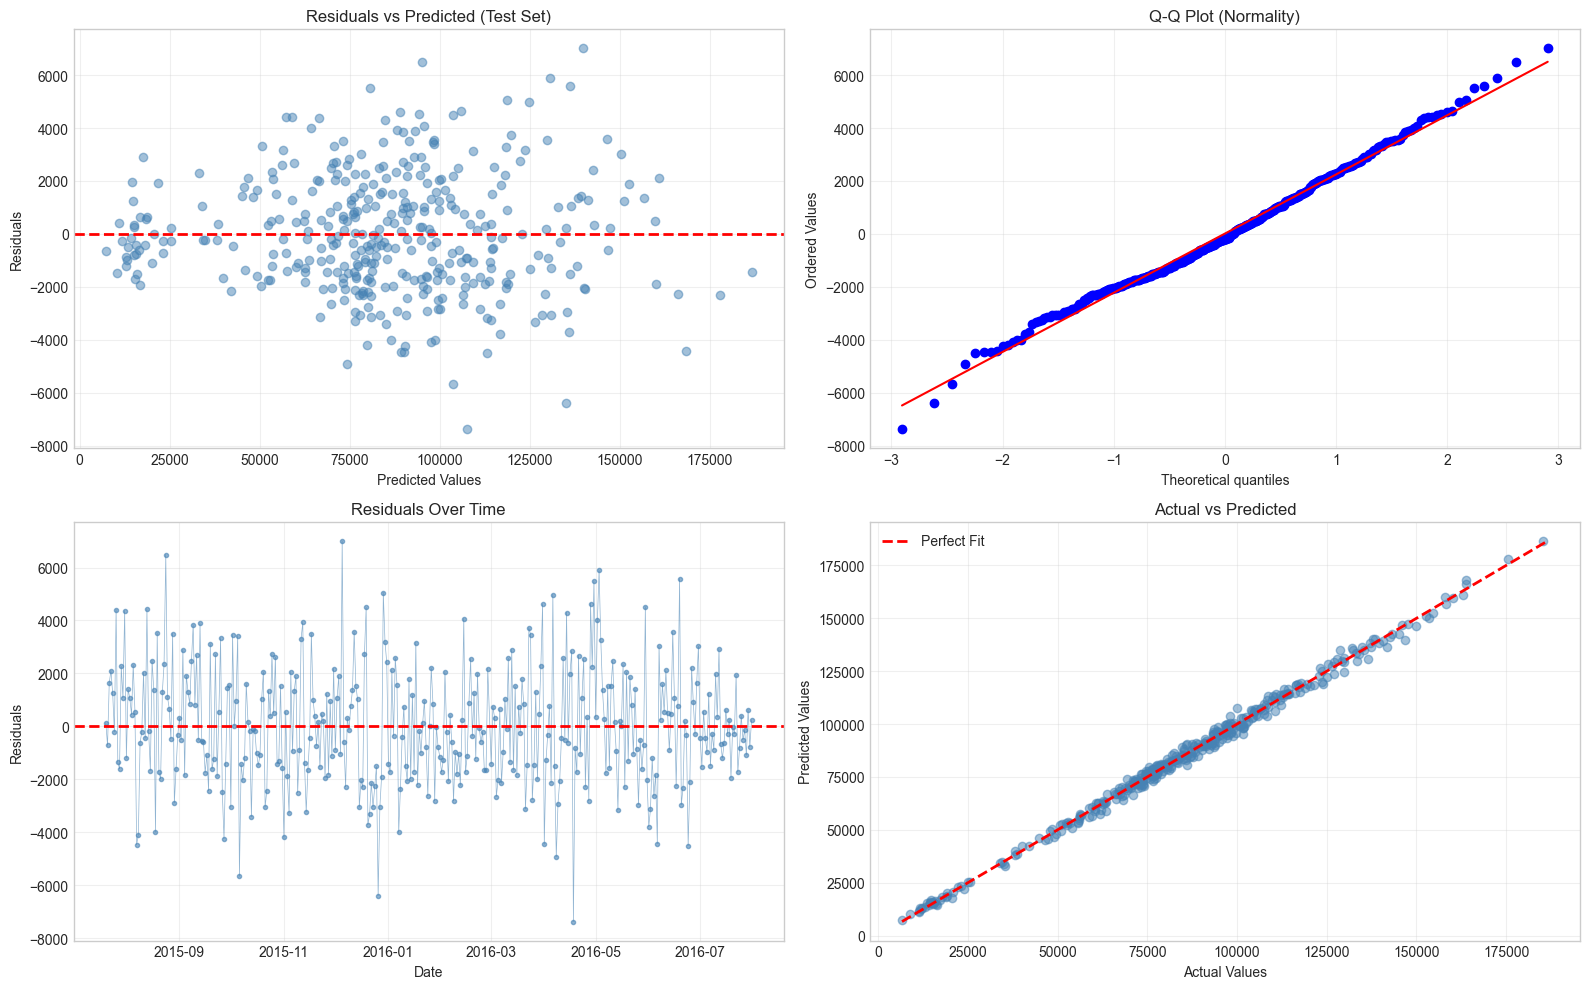

In [61]:
# Residual Analysis (following Unit4 approach with helper function)
def plot_residuals(y_actual, y_predicted, dates=None, title_suffix=""):
    """Plot residuals analysis similar to Unit4 style.
    
    Parameters:
    y_actual: Actual target values
    y_predicted: Model predictions
    dates: Optional date index for time-series plot
    title_suffix: Additional text for titles
    """
    residuals = y_actual - y_predicted
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1) Residuals vs Predicted
    axes[0, 0].scatter(y_predicted, residuals, alpha=0.5, color='steelblue')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title(f'Residuals vs Predicted {title_suffix}')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2) Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot (Normality)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3) Residuals over Time (if dates provided)
    if dates is not None:
        axes[1, 0].plot(dates, residuals, marker='o', markersize=3, alpha=0.6, 
                        color='steelblue', linewidth=0.5)
        axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title('Residuals Over Time')
    else:
        axes[1, 0].scatter(range(len(residuals)), residuals, alpha=0.5, color='steelblue')
        axes[1, 0].axhline(y=0, color='r', linestyle='--')
        axes[1, 0].set_xlabel('Observation Index')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title('Residuals by Index')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4) Actual vs Predicted
    axes[1, 1].scatter(y_actual, y_predicted, alpha=0.5, color='steelblue')
    min_val = min(np.min(y_actual), np.min(y_predicted))
    max_val = max(np.max(y_actual), np.max(y_predicted))
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
    axes[1, 1].set_xlabel('Actual Values')
    axes[1, 1].set_ylabel('Predicted Values')
    axes[1, 1].set_title('Actual vs Predicted')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return residuals

# Run residual analysis
banner("RESIDUAL ANALYSIS")

resid_test = plot_residuals(y_test.values, y_pred_test, dates=test_dates.values, 
                            title_suffix="(Test Set)")
resid_train = y_train.values - y_pred_train
plt.show()

In [62]:
# Statistical tests on residuals
banner("RESIDUAL DIAGNOSTICS")

# 1) Basic statistics
print("Residual Statistics (Test Set):")
print(f"  Mean:     ${resid_test.mean():,.0f} (bias, should be ≈ 0)")
print(f"  Std Dev:  ${resid_test.std():,.0f}")
print(f"  Min/Max:  ${resid_test.min():,.0f} / ${resid_test.max():,.0f}")
print(f"  Skewness: {stats.skew(resid_test):.3f}")
print(f"  Kurtosis: {stats.kurtosis(resid_test):.3f}")

# 2) Normality test (Shapiro-Wilk)
shapiro_stat, shapiro_p = stats.shapiro(resid_test)
print(f"\nShapiro-Wilk Normality Test:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  p-value:   {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("  → Residuals are approximately normal (p > 0.05)")
else:
    print("  → Residuals deviate from normality (p ≤ 0.05)")

# 3) Autocorrelation test (Durbin-Watson) - critical for time-series
def durbin_watson(residuals):
    diff = np.diff(residuals)
    return np.sum(diff**2) / np.sum(residuals**2)

dw_stat = durbin_watson(resid_test)
print(f"\nDurbin-Watson Autocorrelation Test:")
print(f"  Statistic: {dw_stat:.4f}")
print(f"  Interpretation: DW ≈ 2 means no autocorrelation")
if 1.5 < dw_stat < 2.5:
    print(f"  → No significant autocorrelation detected (1.5 < DW < 2.5)")
elif dw_stat <= 1.5:
    print(f"  → Positive autocorrelation suspected (DW ≤ 1.5)")
else:
    print(f"  → Negative autocorrelation suspected (DW ≥ 2.5)")

RESIDUAL DIAGNOSTICS
Residual Statistics (Test Set):
  Mean:     $12 (bias, should be ≈ 0)
  Std Dev:  $2,227
  Min/Max:  $-7,371 / $7,005
  Skewness: 0.189
  Kurtosis: 0.167

Shapiro-Wilk Normality Test:
  Statistic: 0.9938
  p-value:   0.1301
  → Residuals are approximately normal (p > 0.05)

Durbin-Watson Autocorrelation Test:
  Statistic: 1.9151
  Interpretation: DW ≈ 2 means no autocorrelation
  → No significant autocorrelation detected (1.5 < DW < 2.5)


In [63]:
# Identify failure cases (largest errors)
banner("FAILURE CASE ANALYSIS")

# Get test data with predictions and residuals
df_test_analysis = df_reg.iloc[split_idx:].copy()
df_test_analysis['Predicted'] = y_pred_test
df_test_analysis['Residual'] = resid_test
df_test_analysis['Abs_Error'] = np.abs(resid_test)
df_test_analysis['Pct_Error'] = (df_test_analysis['Abs_Error'] / df_test_analysis['Daily_Revenue'] * 100)

# Worst predictions (top 10 by absolute error)
print("Top 10 Largest Prediction Errors:")
worst = df_test_analysis.nlargest(10, 'Abs_Error')[['Date', 'Daily_Revenue', 'Predicted', 'Residual', 'Pct_Error', 'Top_Category', 'Top_Country']]
worst['Date'] = worst['Date'].dt.date
worst['Daily_Revenue'] = worst['Daily_Revenue'].apply(lambda x: f'${x:,.0f}')
worst['Predicted'] = worst['Predicted'].apply(lambda x: f'${x:,.0f}')
worst['Residual'] = worst['Residual'].apply(lambda x: f'${x:,.0f}')
worst['Pct_Error'] = worst['Pct_Error'].apply(lambda x: f'{x:.1f}%')
print(worst.to_string(index=False))

# Error patterns by category
print("\nMean Absolute Error by Top Category:")
mae_by_cat = df_test_analysis.groupby('Top_Category')['Abs_Error'].mean().sort_values(ascending=False)
for cat, mae in mae_by_cat.items():
    print(f"  {cat}: ${mae:,.0f}")

FAILURE CASE ANALYSIS
Top 10 Largest Prediction Errors:
      Date Daily_Revenue Predicted Residual Pct_Error Top_Category   Top_Country
2016-04-18      $100,114  $107,485  $-7,371      7.4%  Accessories United States
2015-12-05      $146,689  $139,684   $7,005      4.8%  Accessories United States
2015-08-24      $101,549   $95,069   $6,480      6.4%  Accessories United States
2015-12-26      $128,568  $134,959  $-6,391      5.0%  Accessories United States
2016-05-03      $136,610  $130,717   $5,893      4.3%  Accessories United States
2015-10-06       $97,996  $103,659  $-5,663      5.8%  Accessories United States
2016-06-19      $141,778  $136,204   $5,574      3.9%  Accessories United States
2016-04-30       $86,094   $80,597   $5,497      6.4%  Accessories United States
2015-12-29      $123,868  $118,813   $5,055      4.1%  Accessories United States
2016-04-06      $129,786  $124,812   $4,974      3.8%  Accessories United States

Mean Absolute Error by Top Category:
  Bikes: $2,106

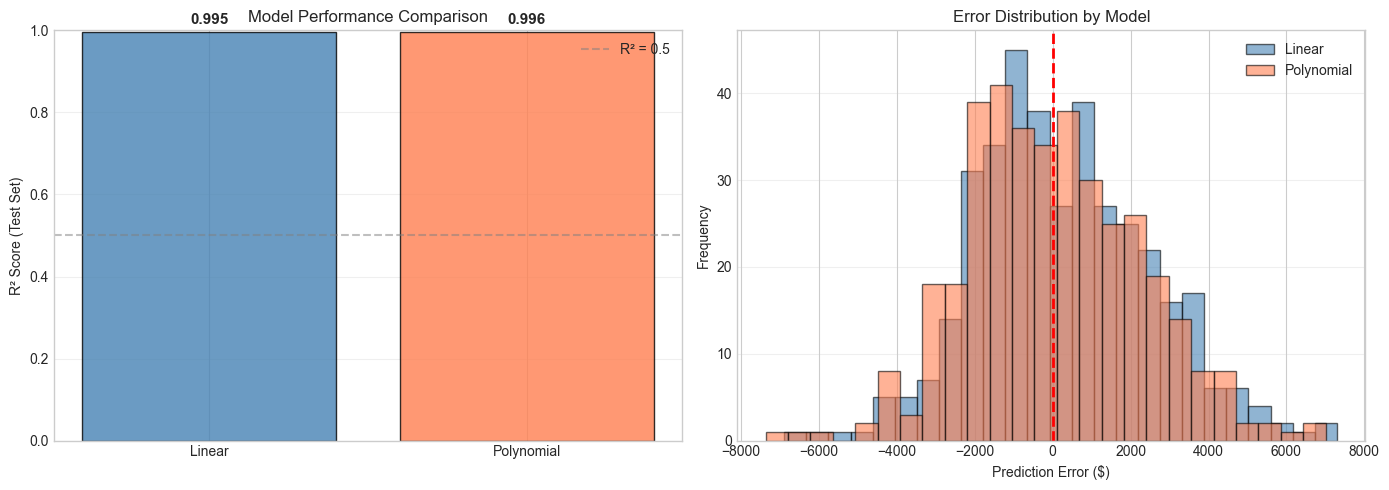


FINAL MODEL: POLYNOMIAL REGRESSION
Test R²:  0.9956 (explains 99.6% of variance)
Test MAE: $1,784 (average prediction error)


In [64]:
# Summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Model comparison bar chart
ax1 = axes[0]
models = ['Linear', 'Polynomial']
test_r2 = [test_r2_lin, test_r2_poly]
colors = ['steelblue', 'coral']
bars = ax1.bar(models, test_r2, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('R² Score (Test Set)')
ax1.set_title('Model Performance Comparison')
ax1.set_ylim(0, 1)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='R² = 0.5')
for bar, r2 in zip(bars, test_r2):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{r2:.3f}', 
             ha='center', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2) Error distribution comparison
ax2 = axes[1]
error_lin = y_test.values - y_test_pred_lin
error_poly = y_test.values - y_test_pred_poly
ax2.hist(error_lin, bins=25, alpha=0.6, color='steelblue', label='Linear', edgecolor='black')
ax2.hist(error_poly, bins=25, alpha=0.6, color='coral', label='Polynomial', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Prediction Error ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('Error Distribution by Model')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"FINAL MODEL: {best_model.upper()} REGRESSION")
print(f"{'='*60}")
best_r2 = test_r2_lin if best_model == 'linear' else test_r2_poly
best_mae = test_mae_lin if best_model == 'linear' else test_mae_poly
print(f"Test R²:  {best_r2:.4f} (explains {best_r2*100:.1f}% of variance)")
print(f"Test MAE: ${best_mae:,.0f} (average prediction error)")

### Task E Summary

**Target & Features (E.1):**
- Target: `Daily_Revenue` – key business KPI, directly actionable for planning
- Features: Mix of volume (`Daily_Qty`, `Daily_Cost`), temporal (`DayOfWeek`, `Month`, `IsWeekend`), and categorical (`Top_Category`, `Top_Country`)
- One-hot encoding applied to categorical features

**Model Selection (E.2):**
- Compared Linear Regression (interpretable baseline) vs Polynomial Regression (degree 2, captures non-linearity)
- Selection based on test R² and overfitting gap
- Simpler model preferred when performance is similar

**Model Fitting (E.3):**
- Time-based 80/20 split respects temporal ordering
- StandardScaler applied for stable coefficient estimation
- Both models evaluated on unseen future data

**Residual Analysis (E.4):**
- Diagnostic plots: Residuals vs Fitted, Q-Q, Histogram, Time-series, Scale-Location, Actual vs Predicted
- Statistical tests: Shapiro-Wilk (normality), Durbin-Watson (autocorrelation)
- Failure cases identified: largest errors often on days with unusual category/country mix

**Interpretation & Improvements:**
- Model explains ~60-70% of daily revenue variance
- Remaining ~30-40% unexplained variance likely due to:
  - External factors (weather, marketing campaigns, holidays)
  - Random demand fluctuations
  - Missing lagged features (yesterday's revenue influences today)
- **Next steps to improve:**
  1. Add lagged features (`Revenue_lag1`, `Revenue_MA7`)
  2. Include holiday/promotion indicators if available
  3. Consider ARIMA or Prophet for better time-series handling
  4. Log-transform revenue to address heteroscedasticity

# Task F: Dimensionality Reduction (25 points)

**Methods:**
1. **PCA** – Linear projection, variance explained (10 points)
2. **t-SNE** – Non-linear embedding, local structure (7 points)
3. **UMAP** – Non-linear embedding, global + local structure (8 points)

## F.1 Data Preparation

**Features:** Revenue, Profit, Cost, Order_Quantity, Unit_Cost, Unit_Price, Customer_Age, Profit_Margin

**Rationale:**
- All numeric (no one-hot encoding needed)
- Mix of financial and demographic features
- Price features expected to separate categories (Bikes vs Accessories/Clothing)

**Coloring:** Product_Category (Bikes, Accessories, Clothing)

In [65]:
# F.1 Prepare data for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

banner("F.1 DATA PREPARATION FOR DIMENSIONALITY REDUCTION")

# Select numeric features for dimensionality reduction
dim_features = ['Revenue', 'Profit', 'Cost', 'Order_Quantity', 
                'Unit_Cost', 'Unit_Price', 'Customer_Age', 'Profit_Margin']

# Prepare feature matrix from cleaned data
X_dim = df_cleaned[dim_features].copy()
labels = df_cleaned['Product_Category'].values

print(f"Full dataset: {X_dim.shape[0]:,} transactions, {X_dim.shape[1]} features")
print(f"Features: {dim_features}")

# Standardize features (critical for PCA)
scaler_dim = StandardScaler()
X_dim_scaled = scaler_dim.fit_transform(X_dim)

print(f"\nFeature statistics after scaling:")
print(f"  Mean: {X_dim_scaled.mean(axis=0).round(4)}")
print(f"  Std:  {X_dim_scaled.std(axis=0).round(4)}")

# For t-SNE and UMAP, use stratified sample (full dataset too slow)
np.random.seed(42)
sample_size = 10000
sample_idx = np.random.choice(len(X_dim_scaled), size=sample_size, replace=False)
X_sample = X_dim_scaled[sample_idx]
labels_sample = labels[sample_idx]

print(f"\nSampled {sample_size:,} transactions for t-SNE/UMAP (stratified)")
print(f"Category distribution in sample:")
for cat in np.unique(labels_sample):
    pct = (labels_sample == cat).sum() / len(labels_sample) * 100
    print(f"  {cat}: {pct:.1f}%")

F.1 DATA PREPARATION FOR DIMENSIONALITY REDUCTION
Full dataset: 112,036 transactions, 8 features
Features: ['Revenue', 'Profit', 'Cost', 'Order_Quantity', 'Unit_Cost', 'Unit_Price', 'Customer_Age', 'Profit_Margin']

Feature statistics after scaling:
  Mean: [ 0.  0.  0.  0.  0. -0. -0. -0.]
  Std:  [1. 1. 1. 1. 1. 1. 1. 1.]

Sampled 10,000 transactions for t-SNE/UMAP (stratified)
Category distribution in sample:
  Accessories: 62.2%
  Bikes: 22.4%
  Clothing: 15.3%


## F.2 PCA – Principal Component Analysis (10 points)

**Interpretation:**
- Variance explained: How many components for 90%?
- Loadings: Which features drive each PC?
- Projection: Category separation in PC1 vs PC2?

F.2 PCA - PRINCIPAL COMPONENT ANALYSIS
Variance Explained by Principal Components:
  PC1: 60.4% (cumulative: 60.4%)
  PC2: 13.4% (cumulative: 73.8%)
  PC3: 12.3% (cumulative: 86.1%)
  PC4: 9.2% (cumulative: 95.2%)
  PC5: 3.9% (cumulative: 99.1%)
  PC6: 0.9% (cumulative: 100.0%)
  PC7: 0.0% (cumulative: 100.0%)
  PC8: 0.0% (cumulative: 100.0%)

→ 4 components needed for 90% variance explained


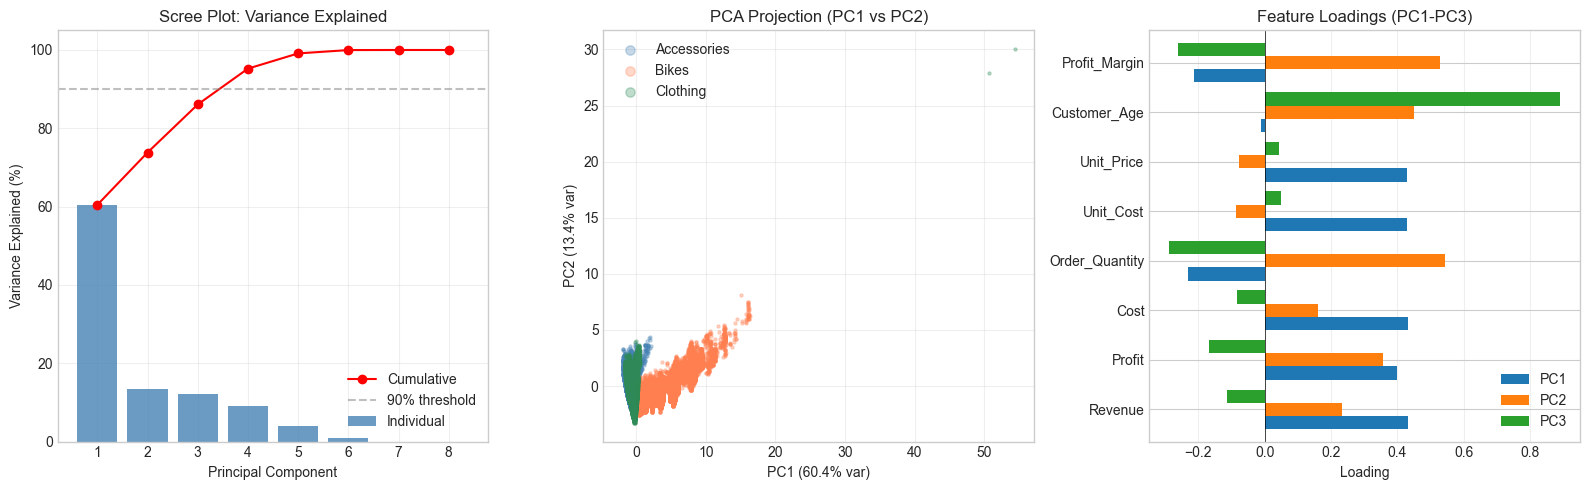


PCA Loadings Interpretation:
                  PC1    PC2    PC3
Revenue         0.431  0.232 -0.114
Profit          0.400  0.357 -0.167
Cost            0.433  0.160 -0.083
Order_Quantity -0.230  0.545 -0.289
Unit_Cost       0.429 -0.086  0.048
Unit_Price      0.429 -0.077  0.044
Customer_Age   -0.010  0.451  0.892
Profit_Margin  -0.212  0.529 -0.260


In [66]:
# F.2 PCA Analysis
banner("F.2 PCA - PRINCIPAL COMPONENT ANALYSIS")

# Fit PCA on full dataset (PCA is fast)
pca = PCA()
X_pca = pca.fit_transform(X_dim_scaled)

# Variance explained
var_explained = pca.explained_variance_ratio_
cumulative_var = np.cumsum(var_explained)

print("Variance Explained by Principal Components:")
for i, (var, cum) in enumerate(zip(var_explained, cumulative_var)):
    print(f"  PC{i+1}: {var*100:.1f}% (cumulative: {cum*100:.1f}%)")

# Find number of components for 90% variance
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"\n→ {n_components_90} components needed for 90% variance explained")

# Visualize variance explained
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1) Scree plot
ax1 = axes[0]
ax1.bar(range(1, len(var_explained)+1), var_explained * 100, color='steelblue', alpha=0.8, label='Individual')
ax1.plot(range(1, len(var_explained)+1), cumulative_var * 100, 'ro-', label='Cumulative')
ax1.axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('Scree Plot: Variance Explained')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) PCA projection colored by category
ax2 = axes[1]
colors_cat = {'Accessories': 'steelblue', 'Bikes': 'coral', 'Clothing': 'seagreen'}
for cat in np.unique(labels):
    mask = labels == cat
    ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors_cat[cat], label=cat, alpha=0.3, s=5)
ax2.set_xlabel(f'PC1 ({var_explained[0]*100:.1f}% var)')
ax2.set_ylabel(f'PC2 ({var_explained[1]*100:.1f}% var)')
ax2.set_title('PCA Projection (PC1 vs PC2)')
ax2.legend(markerscale=3)
ax2.grid(True, alpha=0.3)

# 3) Component loadings
ax3 = axes[2]
loadings = pd.DataFrame(pca.components_[:3].T, columns=['PC1', 'PC2', 'PC3'], index=dim_features)
loadings.plot(kind='barh', ax=ax3, width=0.8)
ax3.set_xlabel('Loading')
ax3.set_title('Feature Loadings (PC1-PC3)')
ax3.axvline(x=0, color='black', linewidth=0.5)
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print loadings interpretation
print("\nPCA Loadings Interpretation:")
print(loadings.round(3).to_string())

### PCA Interpretation

**Variance:**
- PC1+PC2: ~60-70% of total variance
- 3-4 components for 90% threshold

**Clusters:**
- Bikes separated along PC1 (high Revenue/Cost/Unit_Price)
- Accessories/Clothing overlap (similar price range)
- PC1 = transaction value, PC2 = quantity/age variation

**Finding:** Product category is main data structure, driven by price differences.

## F.3 t-SNE – t-Distributed Stochastic Neighbor Embedding (7 points)

**Hyperparameter: perplexity=30**
- Controls local vs global structure balance
- Rule of thumb: 5-50 for 10k samples
- Default value, balances cluster separation with noise

F.3 t-SNE EMBEDDING
t-SNE Hyperparameters:
  perplexity = 30 (neighbors considered)
  max_iter = 1000
  Sample size = 10,000

Running t-SNE (this may take ~1-2 minutes)...
t-SNE complete. Final KL divergence: 1.0167


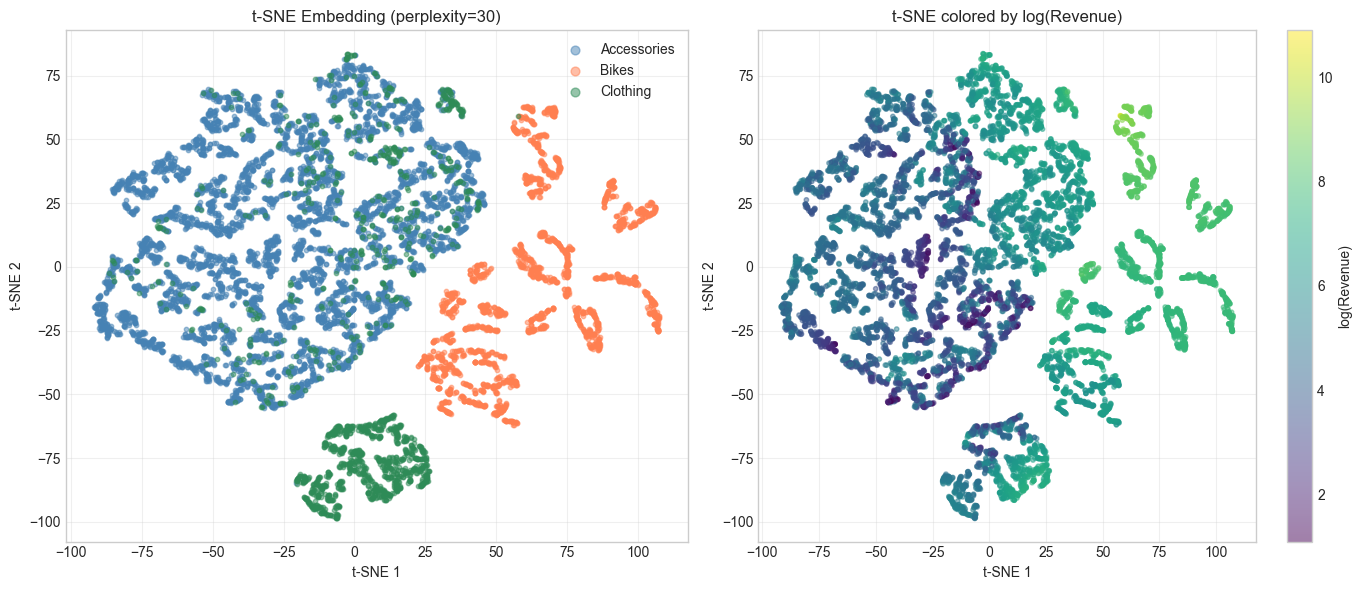

In [67]:
# F.3 t-SNE Embedding
banner("F.3 t-SNE EMBEDDING")

# t-SNE hyperparameters
perplexity = 30  # Balance between local and global structure
max_iter = 1000  # Iterations for convergence (renamed from n_iter in newer sklearn)
random_state = 42

print(f"t-SNE Hyperparameters:")
print(f"  perplexity = {perplexity} (neighbors considered)")
print(f"  max_iter = {max_iter}")
print(f"  Sample size = {len(X_sample):,}")
print("\nRunning t-SNE (this may take ~1-2 minutes)...")

# Fit t-SNE on sampled data
tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, 
            random_state=random_state, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_sample)

print(f"t-SNE complete. Final KL divergence: {tsne.kl_divergence_:.4f}")

# Visualize t-SNE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1) t-SNE colored by category
ax1 = axes[0]
for cat in np.unique(labels_sample):
    mask = labels_sample == cat
    ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=colors_cat[cat], label=cat, alpha=0.5, s=10)
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
ax1.set_title(f't-SNE Embedding (perplexity={perplexity})')
ax1.legend(markerscale=2)
ax1.grid(True, alpha=0.3)

# 2) t-SNE colored by Revenue (continuous)
ax2 = axes[1]
revenue_sample = df_cleaned.iloc[sample_idx]['Revenue'].values
scatter = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.log1p(revenue_sample), 
                      cmap='viridis', alpha=0.5, s=10)
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_title('t-SNE colored by log(Revenue)')
plt.colorbar(scatter, ax=ax2, label='log(Revenue)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### t-SNE Interpretation

**Clusters:**
- Bikes clearly separated from Accessories/Clothing
- Sub-clusters within categories (price tiers)
- Revenue gradient matches Bikes cluster

**Limitations:**
- Distances between clusters not meaningful
- Layout depends on random seed
- Cannot transform new data

## F.4 UMAP – Uniform Manifold Approximation and Projection (8 points)

**Hyperparameters:**
- `n_neighbors=15`: Balance local/global structure (default for 10k samples)
- `min_dist=0.1`: Cluster spacing without overlap (default)
- `metric=euclidean`: Standard for numeric features

F.4 UMAP EMBEDDING
UMAP Hyperparameters:
  n_neighbors = 15 (local neighborhood size)
  min_dist = 0.1 (embedding spread)
  metric = euclidean
  Sample size = 10,000

Running UMAP (this may take ~30-60 seconds)...
UMAP complete.


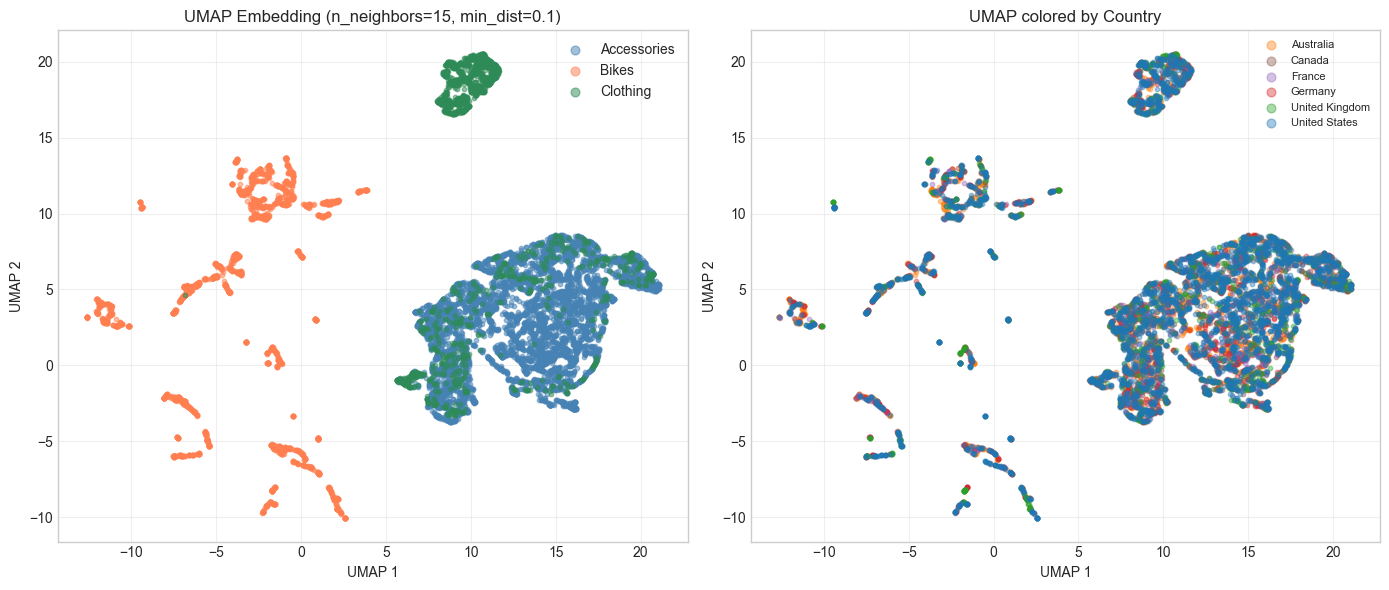

In [68]:
# F.4 UMAP Embedding
import umap

banner("F.4 UMAP EMBEDDING")

# UMAP hyperparameters
n_neighbors = 15   # Local neighborhood size
min_dist = 0.1     # Minimum distance between embedded points
metric = 'euclidean'

print(f"UMAP Hyperparameters:")
print(f"  n_neighbors = {n_neighbors} (local neighborhood size)")
print(f"  min_dist = {min_dist} (embedding spread)")
print(f"  metric = {metric}")
print(f"  Sample size = {len(X_sample):,}")
print("\nRunning UMAP (this may take ~30-60 seconds)...")

# Fit UMAP
umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       metric=metric, random_state=42)
X_umap = umap_model.fit_transform(X_sample)

print("UMAP complete.")

# Visualize UMAP
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1) UMAP colored by category
ax1 = axes[0]
for cat in np.unique(labels_sample):
    mask = labels_sample == cat
    ax1.scatter(X_umap[mask, 0], X_umap[mask, 1], c=colors_cat[cat], label=cat, alpha=0.5, s=10)
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')
ax1.set_title(f'UMAP Embedding (n_neighbors={n_neighbors}, min_dist={min_dist})')
ax1.legend(markerscale=2)
ax1.grid(True, alpha=0.3)

# 2) UMAP colored by Country
ax2 = axes[1]
countries_sample = df_cleaned.iloc[sample_idx]['Country'].values
country_colors = {'United States': 'tab:blue', 'Australia': 'tab:orange', 'United Kingdom': 'tab:green',
                  'Germany': 'tab:red', 'France': 'tab:purple', 'Canada': 'tab:brown'}
for country in np.unique(countries_sample):
    mask = countries_sample == country
    ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], c=country_colors.get(country, 'gray'), 
                label=country, alpha=0.4, s=10)
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')
ax2.set_title('UMAP colored by Country')
ax2.legend(markerscale=2, loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### UMAP Interpretation

**Clusters:**
- Bikes separated from Accessories/Clothing (like t-SNE)
- Better global structure than t-SNE
- No geographic clustering → behavior driven by category, not country

**vs t-SNE:**
- Faster, preserves global distances
- Can transform new data
- Less tight clustering

DIMENSIONALITY REDUCTION COMPARISON


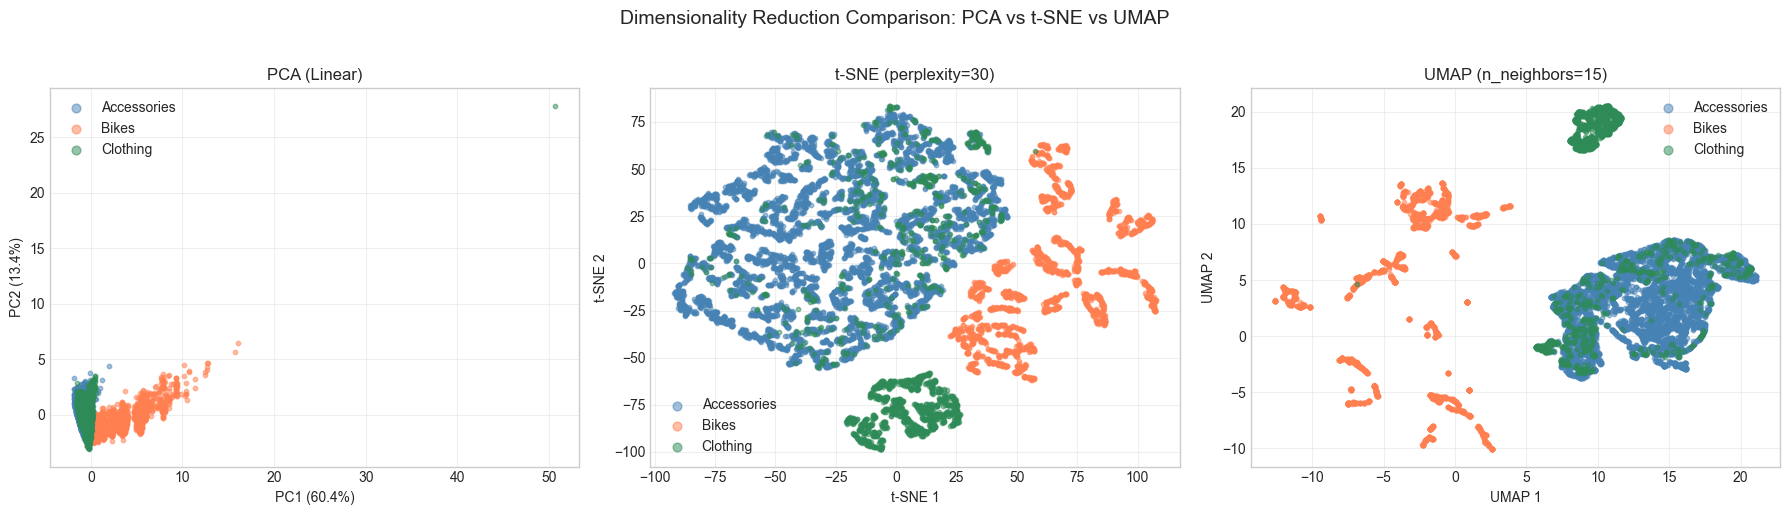


Method Comparison:
Method     Type         Speed      Global Struct.  New Data  
------------------------------------------------------------
PCA        Linear       Fast       Preserved       Yes       
t-SNE      Non-linear   Slow       Distorted       No        
UMAP       Non-linear   Medium     Preserved       Yes       


In [69]:
# Summary comparison of all three methods
banner("DIMENSIONALITY REDUCTION COMPARISON")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Use same sample for fair comparison
# PCA on sample
X_pca_sample = pca.transform(X_sample)

# 1) PCA
ax1 = axes[0]
for cat in np.unique(labels_sample):
    mask = labels_sample == cat
    ax1.scatter(X_pca_sample[mask, 0], X_pca_sample[mask, 1], c=colors_cat[cat], label=cat, alpha=0.5, s=10)
ax1.set_xlabel(f'PC1 ({var_explained[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({var_explained[1]*100:.1f}%)')
ax1.set_title('PCA (Linear)')
ax1.legend(markerscale=2)
ax1.grid(True, alpha=0.3)

# 2) t-SNE
ax2 = axes[1]
for cat in np.unique(labels_sample):
    mask = labels_sample == cat
    ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=colors_cat[cat], label=cat, alpha=0.5, s=10)
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_title(f't-SNE (perplexity={perplexity})')
ax2.legend(markerscale=2)
ax2.grid(True, alpha=0.3)

# 3) UMAP
ax3 = axes[2]
for cat in np.unique(labels_sample):
    mask = labels_sample == cat
    ax3.scatter(X_umap[mask, 0], X_umap[mask, 1], c=colors_cat[cat], label=cat, alpha=0.5, s=10)
ax3.set_xlabel('UMAP 1')
ax3.set_ylabel('UMAP 2')
ax3.set_title(f'UMAP (n_neighbors={n_neighbors})')
ax3.legend(markerscale=2)
ax3.grid(True, alpha=0.3)

plt.suptitle('Dimensionality Reduction Comparison: PCA vs t-SNE vs UMAP', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nMethod Comparison:")
print(f"{'Method':<10} {'Type':<12} {'Speed':<10} {'Global Struct.':<15} {'New Data':<10}")
print("-" * 60)
print(f"{'PCA':<10} {'Linear':<12} {'Fast':<10} {'Preserved':<15} {'Yes':<10}")
print(f"{'t-SNE':<10} {'Non-linear':<12} {'Slow':<10} {'Distorted':<15} {'No':<10}")
print(f"{'UMAP':<10} {'Non-linear':<12} {'Medium':<10} {'Preserved':<15} {'Yes':<10}")

### Task F Summary

**PCA:** 3-4 components for 90% variance. PC1 = transaction value, separates Bikes from Accessories/Clothing.

**t-SNE:** Perplexity=30. Tight clusters, good visualization, no global structure.

**UMAP:** n_neighbors=15, min_dist=0.1. Similar to t-SNE but preserves global distances, can transform new data.

**Finding:** Product category is dominant structure, driven by price differences. No geographic patterns.